Python module to perform machine learning on the ST data and to visualize the results, on the 4 slides of the patient 34 and without mixed cells

# Import

In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
from seaborn import objects as so
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import umap.umap_ as umap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Input

An AnnData object containing a dataset where each row is a spot and each column is a gene. The AnnData object contains also a obs where you can find pathologist's annotation. Moreover, you can find the gene expression data processed with a PCA in the obsm part of the AnnData object.

In [2]:
adata = ad.read_h5ad('/disk2/user/cormey/outputs/Transcription_objects/034_RJ_QC')

# Output

Some graphs to visualize the performance of the machine learning and the quality of the transcriptomics data

# Exclude out and mixed from the dataset

In [3]:
#Remove out spots from the dataset
# Define the cell type to filter out
cell_type_to_remove = 'Out'

# Create a boolean mask for rows where the cell type is not 'out'
mask = adata.obs['annotation'] != cell_type_to_remove

# Apply the mask to subset the AnnData object
adata = adata[mask, :]

In [4]:
#Remove mixed spots from the dataset
# Define the cell type to filter out
cell_type_to_remove = 'Mixed'

# Create a boolean mask for rows where the cell type is not 'out'
mask = adata.obs['annotation'] != cell_type_to_remove

# Apply the mask to subset the AnnData object
adata = adata[mask, :]

# Visualize the AnnData object

In [5]:
print(adata.var_names)

Index(['ENSG00000131591', 'ENSG00000162572', 'ENSG00000221978',
       'ENSG00000215915', 'ENSG00000197530', 'ENSG00000162585',
       'ENSG00000048707', 'ENSG00000162552', 'ENSG00000011009',
       'ENSG00000117614',
       ...
       'ENSG00000205560', 'ENSG00000046651', 'ENSG00000130066',
       'ENSG00000005889', 'ENSG00000102265', 'ENSG00000086758',
       'ENSG00000181704', 'ENSG00000125676', 'ENSG00000101972',
       'ENSG00000102181'],
      dtype='object', length=350)


In [6]:
adata.obs.head()

batch     annotation
AAACAATCTACTAGCA-1#V10F03-034_A  V10F03-034_A  Benign breast
AAACACCAATAACTGC-1#V10F03-034_A  V10F03-034_A         Stroma
AAACAGTGTTCCTGGG-1#V10F03-034_A  V10F03-034_A         Stroma
AAACATTTCCCGGATT-1#V10F03-034_A  V10F03-034_A         Stroma
AAACCCGAACGAAATC-1#V10F03-034_A  V10F03-034_A         Stroma

In [7]:
print(adata.X[:10, :20])

  (2, 5)	1.1150397628100577


# Visualize the PCA

In [8]:
X=adata.X

# Create an PCA object with the number of wanted principal componants
pca = PCA(n_components=10)  # 5 PC

# Perform the PCA on the matrix X
reduced_features = pca.fit_transform(X)

#Add PCA data in adata object
adata.obsm['X_pca'] = reduced_features

# Check the results
print("Shape of reduced features:", reduced_features.shape)


Shape of reduced features: (7344, 10)


/tmp/ipykernel_759960/4028030406.py:10: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = reduced_features


In [9]:
#See how much each components explain the total variance of the dataset

explained_variance_ratio = pca.explained_variance_ratio_

# Display results
for i, variance in enumerate(explained_variance_ratio):
    print(f"Principal component {i+1}: {variance:.2%} of the variance")

Principal component 1: 9.68% of the variance
Principal component 2: 6.14% of the variance
Principal component 3: 4.75% of the variance
Principal component 4: 4.37% of the variance
Principal component 5: 4.10% of the variance
Principal component 6: 3.43% of the variance
Principal component 7: 2.95% of the variance
Principal component 8: 2.27% of the variance
Principal component 9: 2.26% of the variance
Principal component 10: 1.85% of the variance


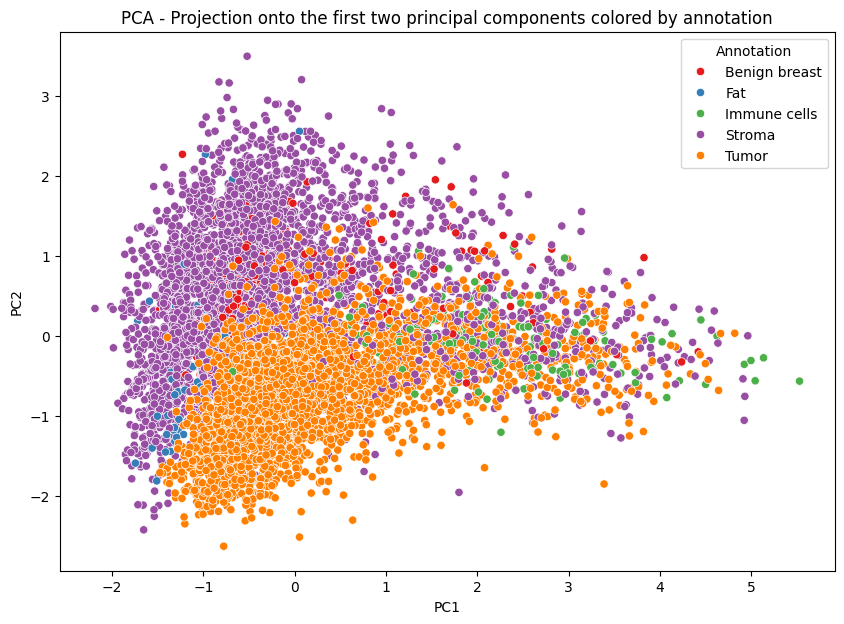

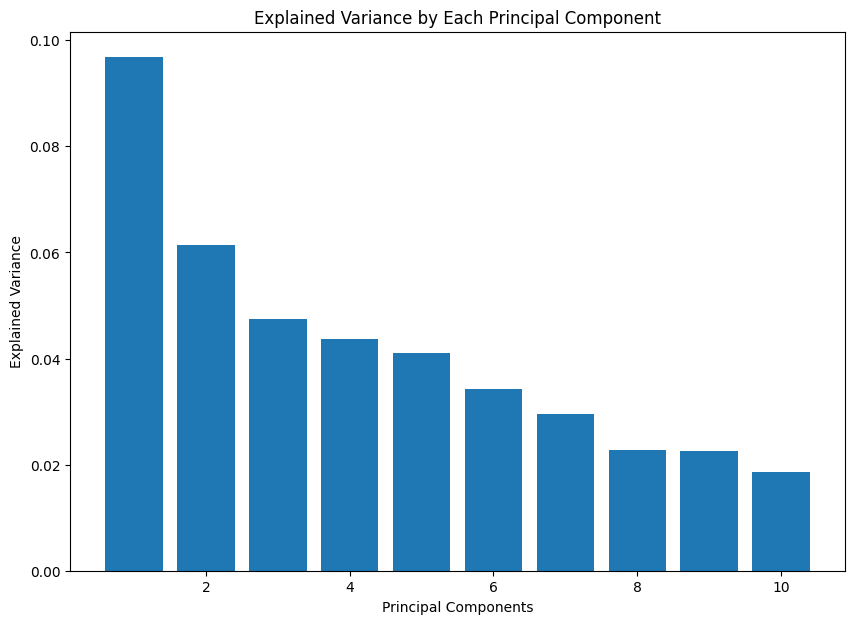

In [10]:
# Extract the first two principal components
pc1 = reduced_features[:, 0]
pc2 = reduced_features[:, 1]

# Stock the annotation in a variable
labels = adata.obs['annotation']

# Scatter plot of the first two principal components
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pc1, y=pc2, hue=labels, palette='Set1')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA - Projection onto the first two principal components colored by annotation')
plt.legend(title='Annotation')
plt.show()

# Explained variance by each principal component
explained_variance = pca.explained_variance_ratio_

# Create the explained variance plot
plt.figure(figsize=(10, 7))
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Each Principal Component')
plt.show()

# Visualize with a Umap

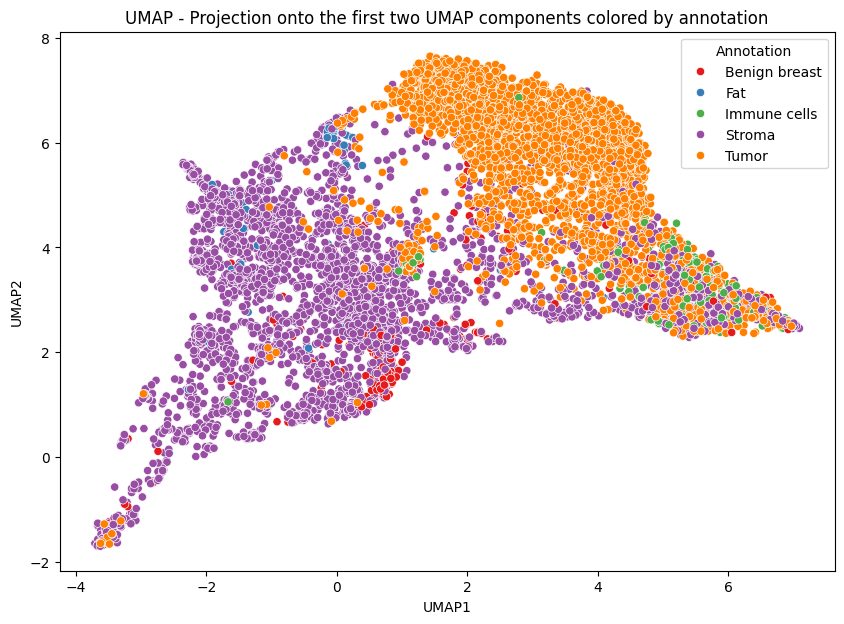

In [11]:
# Load the transcription dataset
X = adata.X
y = adata.obs['annotation']

# Dimensionality reduction with UMAP
reducer = umap.UMAP(n_components=2)
X_umap = reducer.fit_transform(X)

# Convert the UMAP result to a DataFrame for easier data manipulation
df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
df_umap['Label'] = y.values  # Ensure y is correctly assigned

# Scatter plot of the first two UMAP components colored by annotation
plt.figure(figsize=(10, 7))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Label', palette='Set1', data=df_umap)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP - Projection onto the first two UMAP components colored by annotation')
plt.legend(title='Annotation')
plt.show()


# Perform the Machine Learning

In [12]:
##Perform a machine learning algorithm on the expression dataset

labels = adata.obs["annotation"]  # Extraction of pathologist's annotation

# Extract segmentation features and annotation
X = adata.X
y = labels

# Split data in a train dataset and a test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the classification model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test dataset
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)  # Get probabilities for each class

# Display the classification report
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

Benign breast       1.00      0.08      0.15        97
          Fat       0.00      0.00      0.00        25
 Immune cells       0.00      0.00      0.00        41
       Stroma       0.89      0.93      0.91      1173
        Tumor       0.86      0.95      0.90       868

     accuracy                           0.87      2204
    macro avg       0.55      0.39      0.39      2204
 weighted avg       0.85      0.87      0.84      2204



/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/disk2/user/cormey/environments/test_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

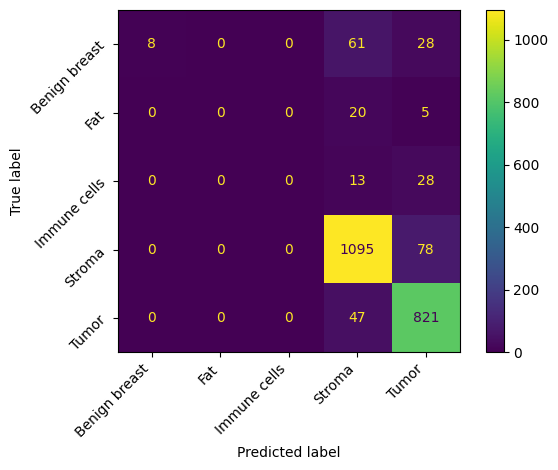

In [13]:
cm = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

# Adjust the rotation of the x-axis labels and y-axis labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)

# Adjust layout to ensure everything fits without overlapping
plt.tight_layout()

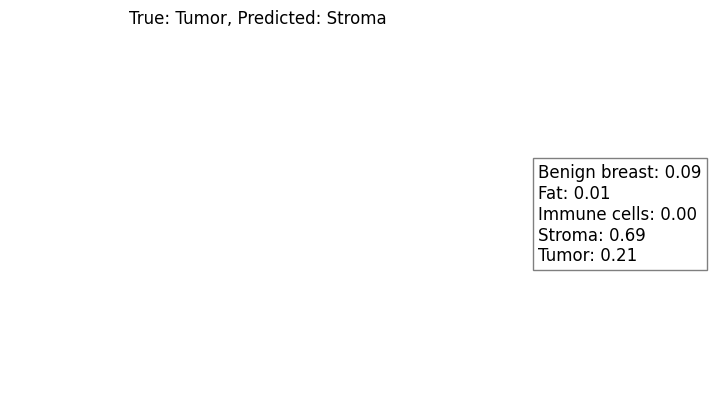

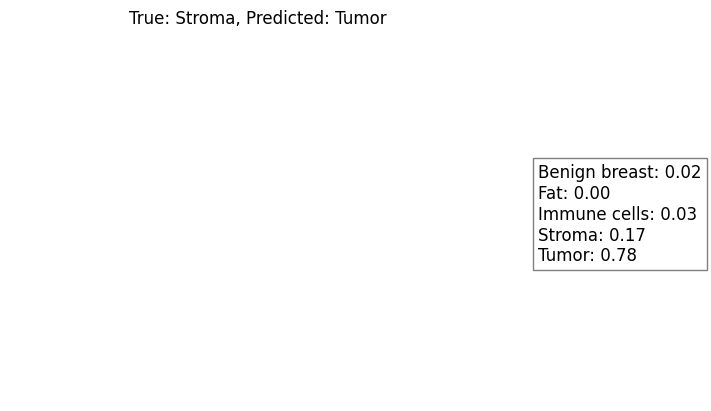

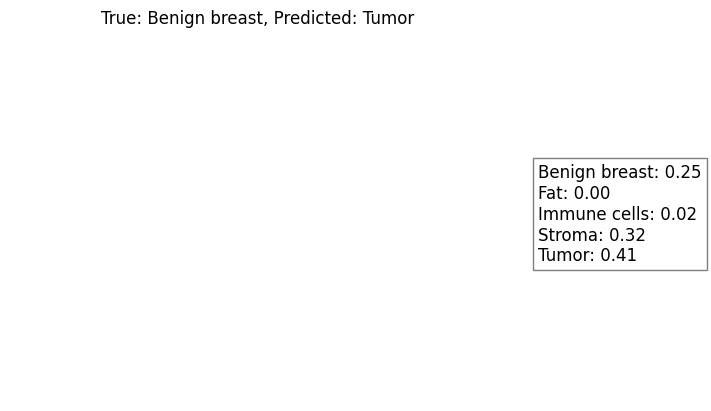

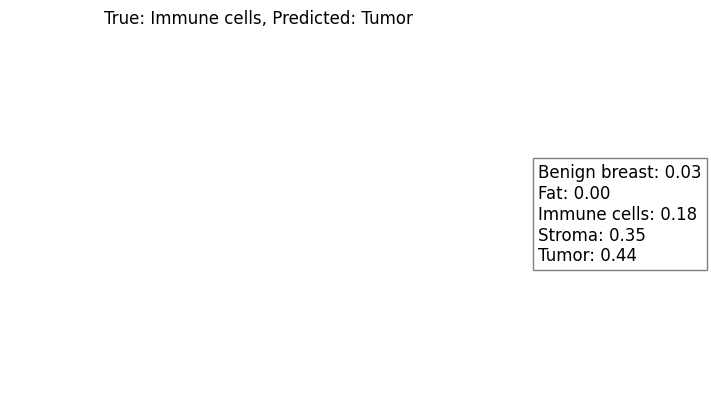

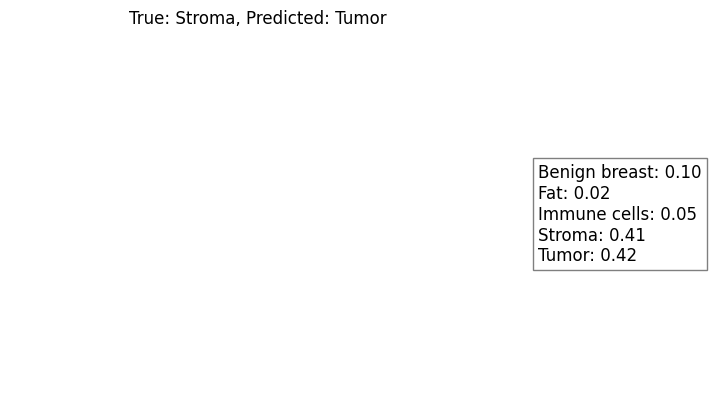

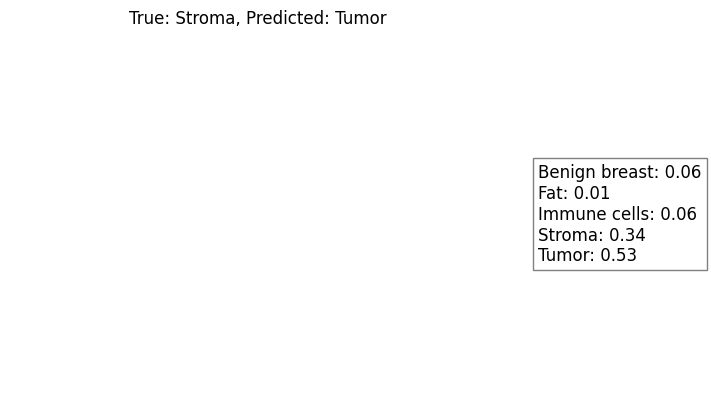

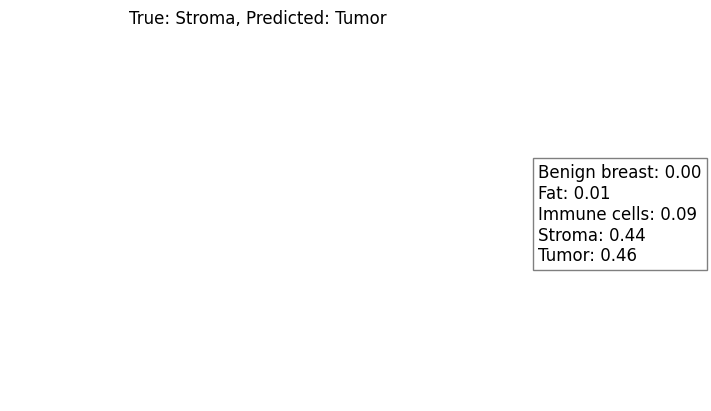

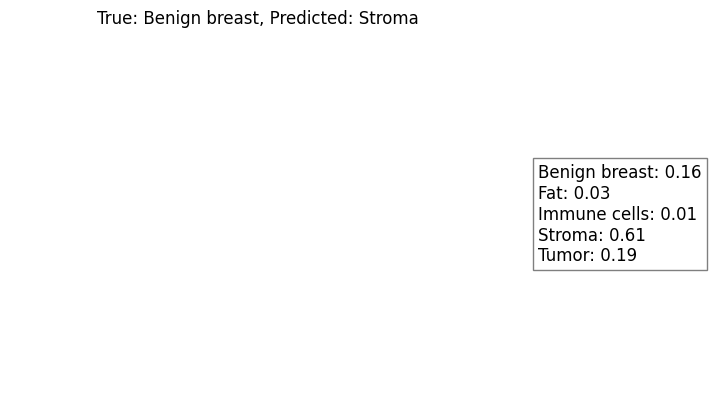

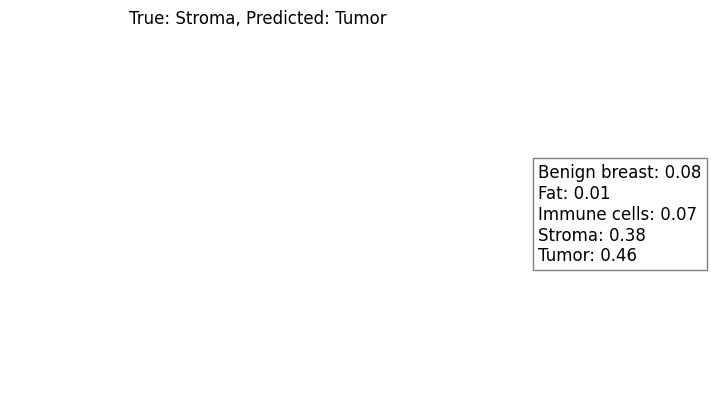

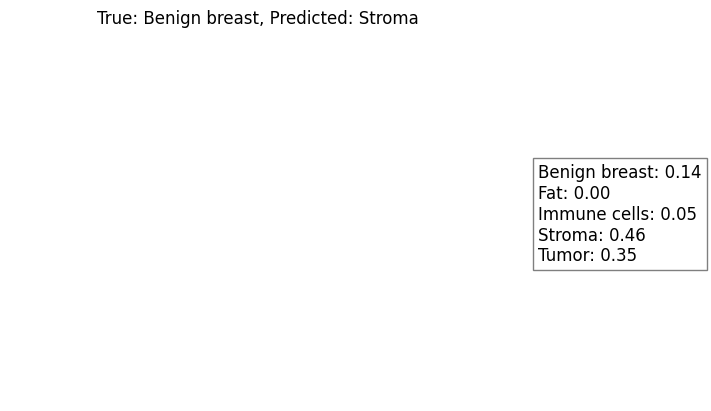

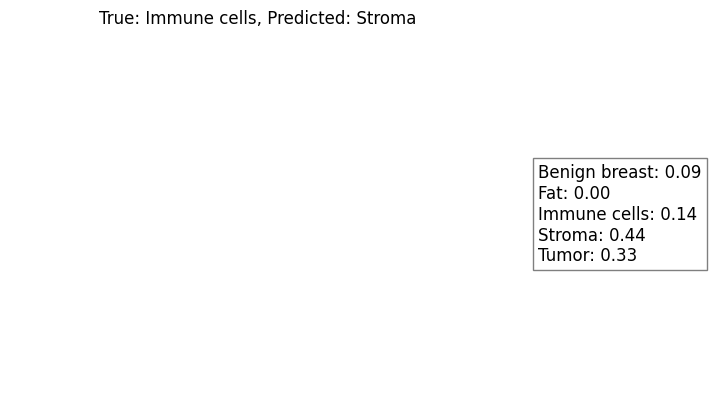

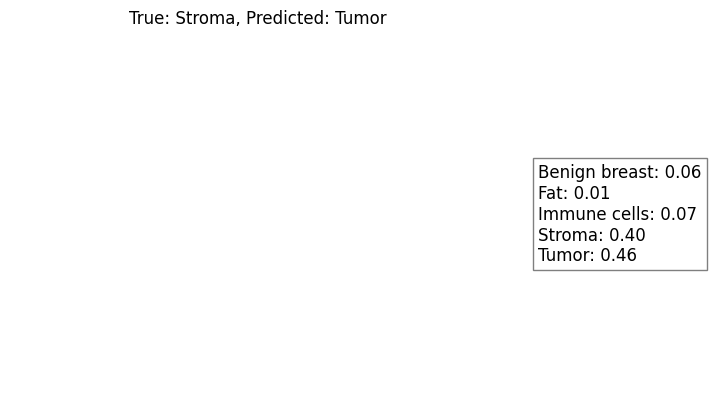

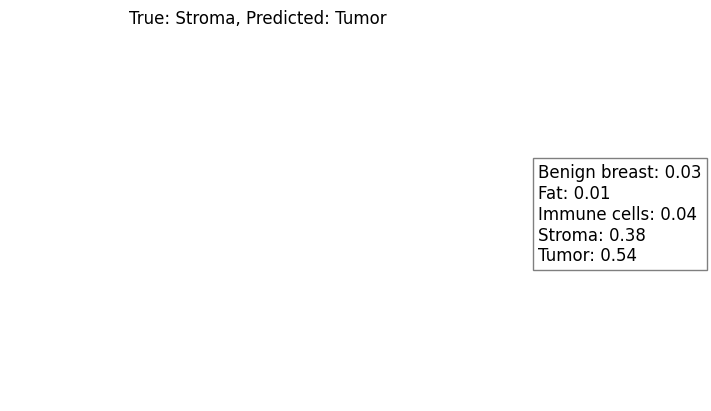

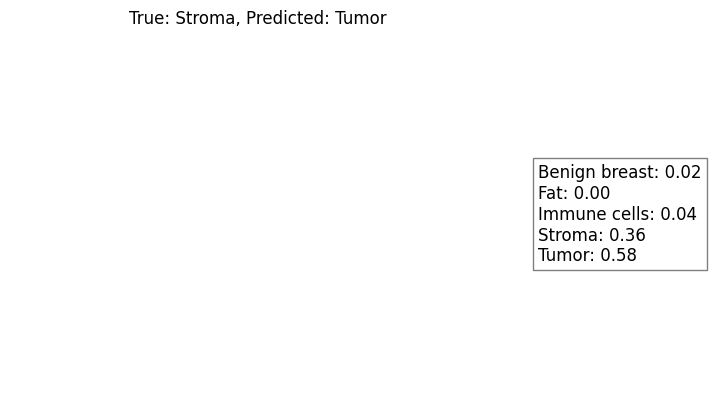

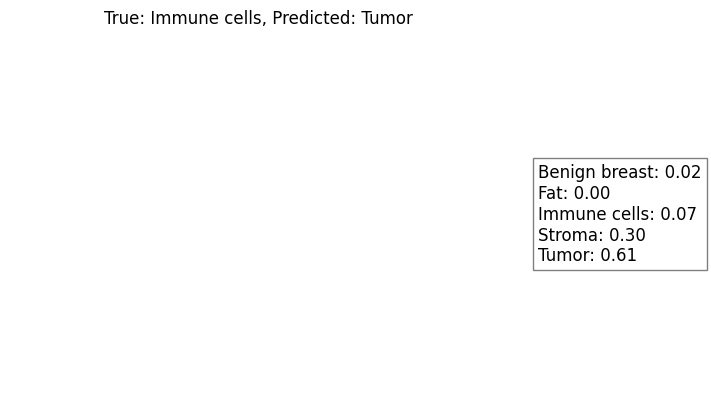

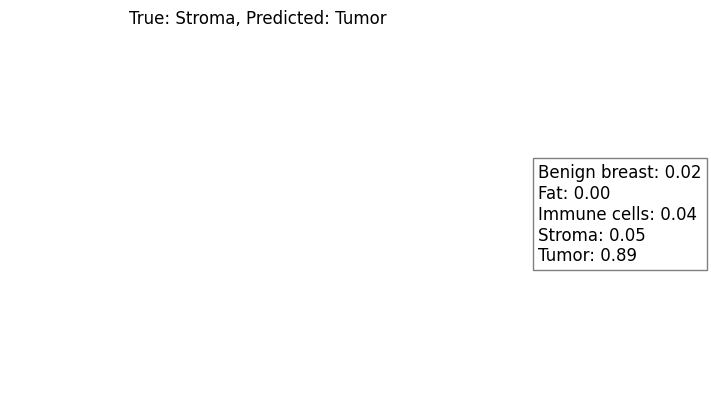

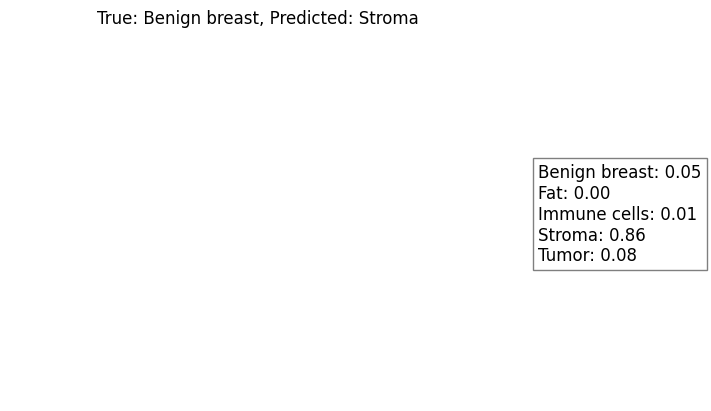

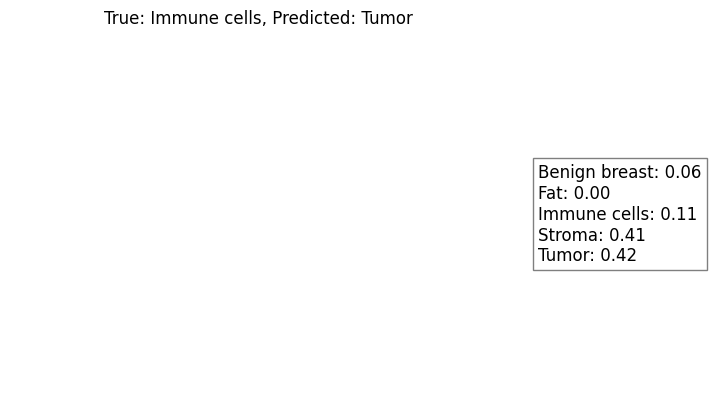

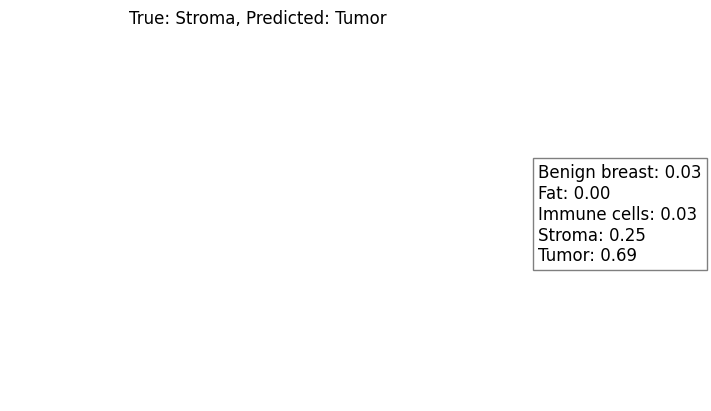

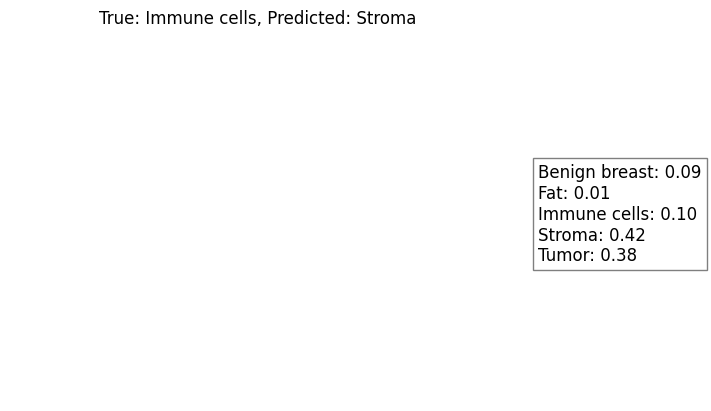

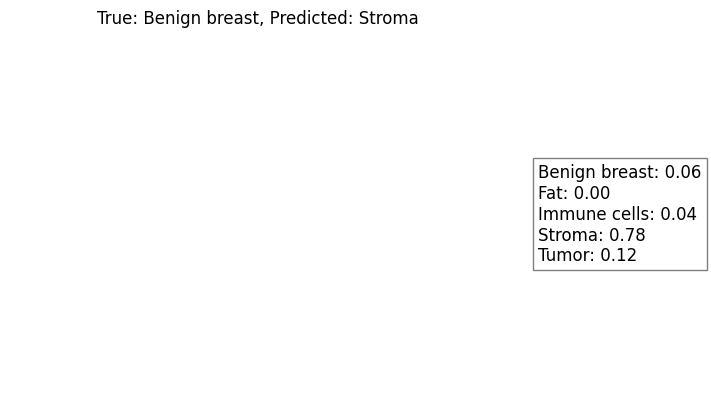

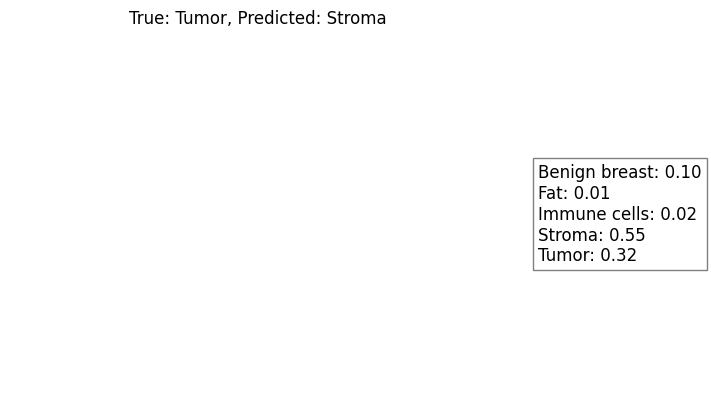

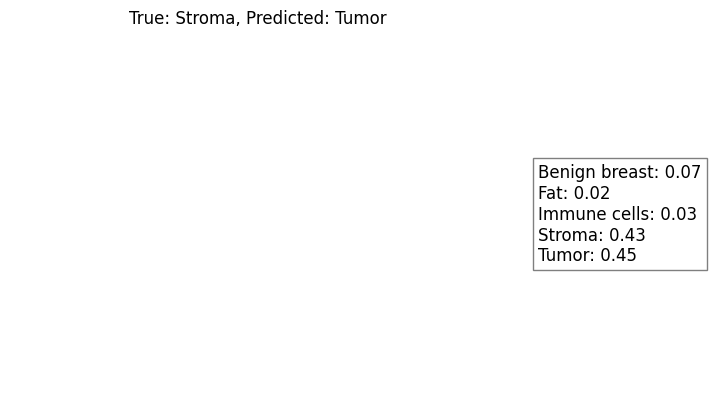

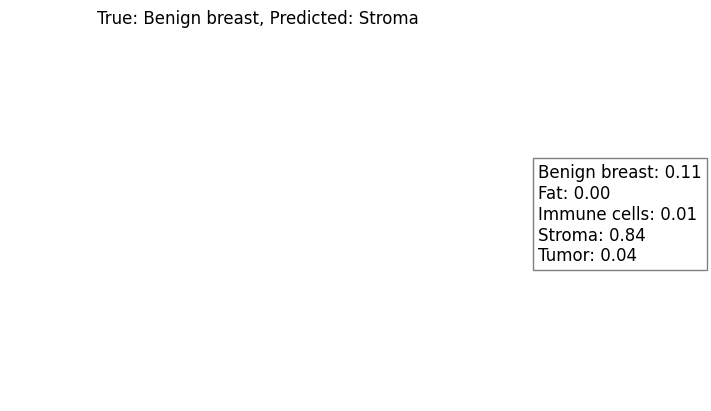

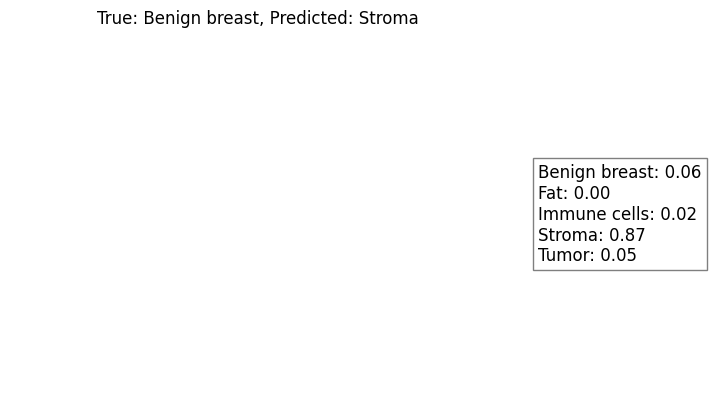

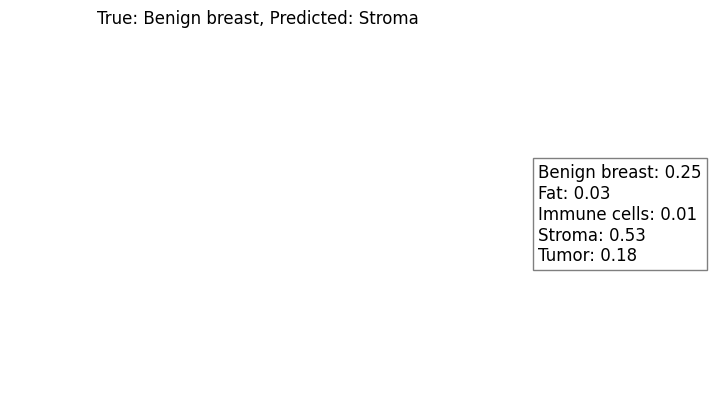

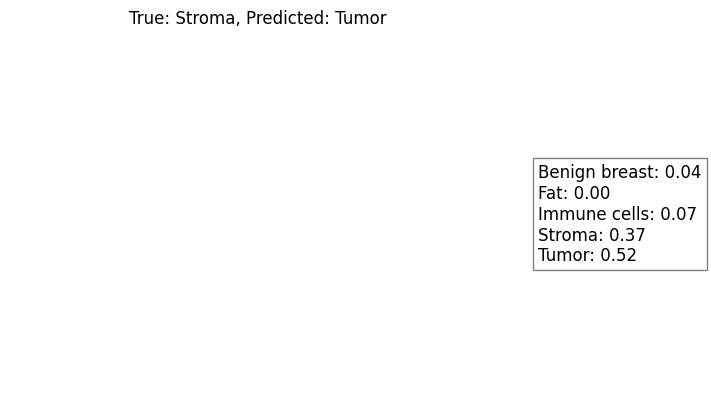

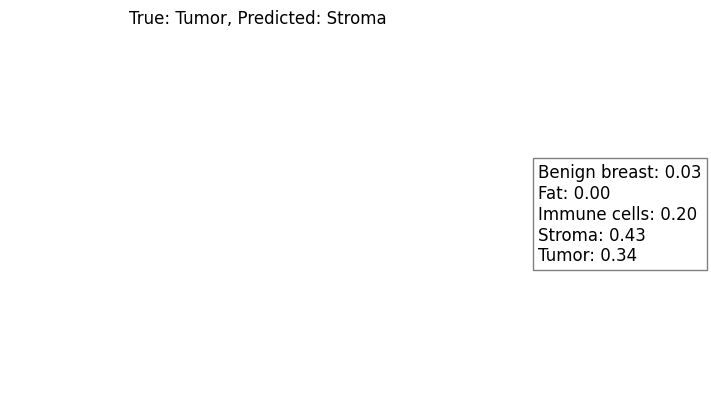

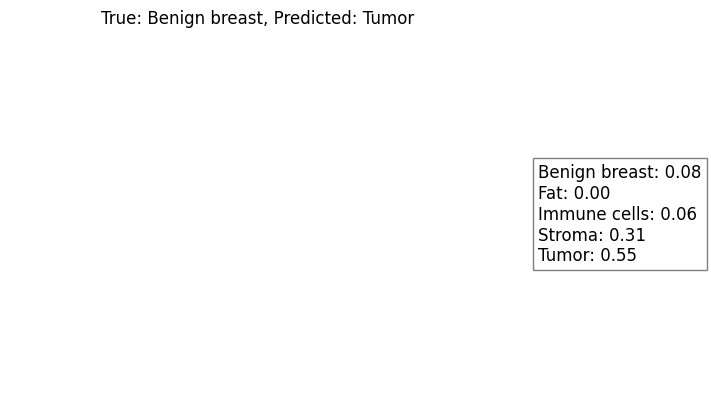

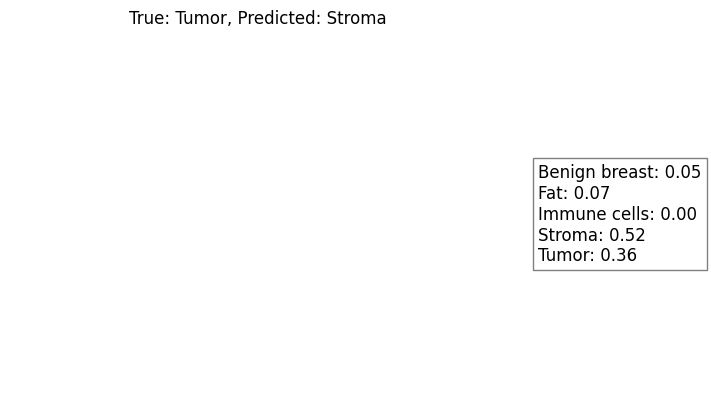

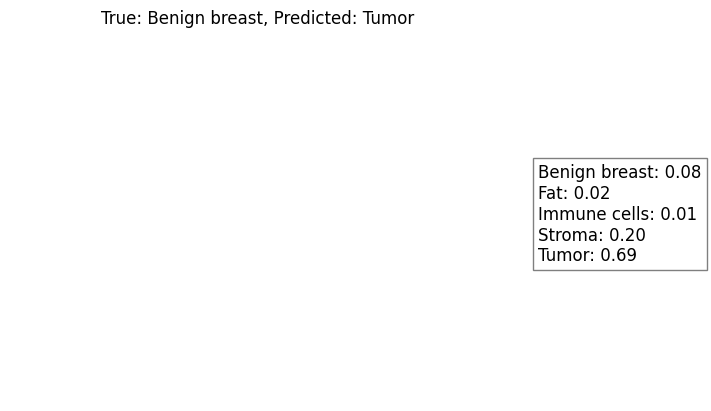

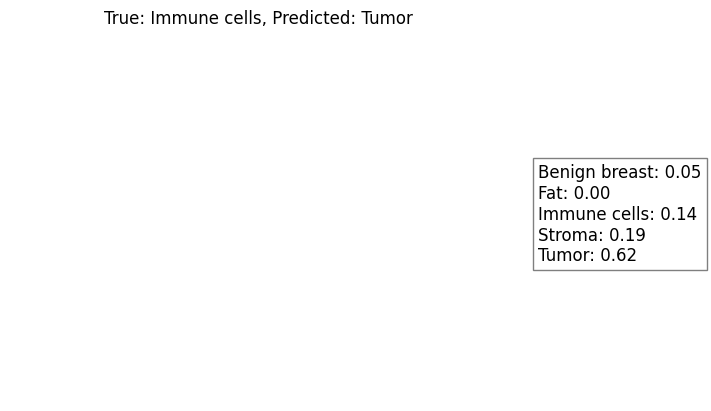

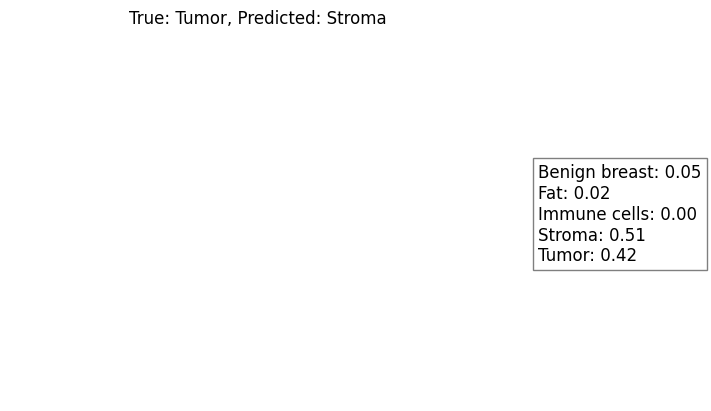

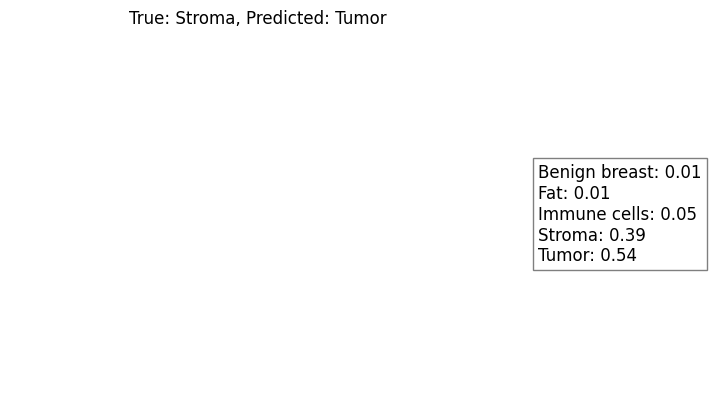

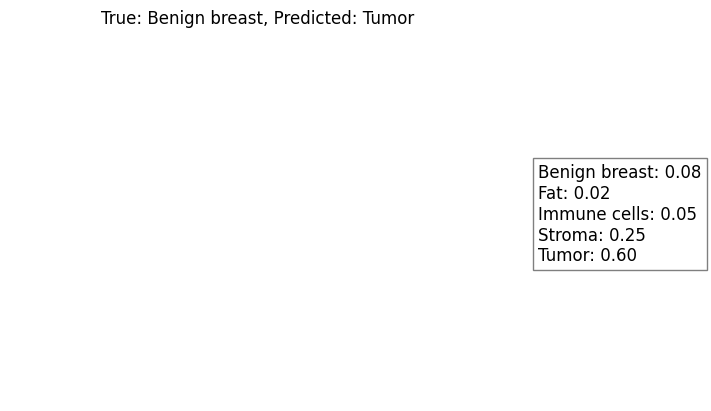

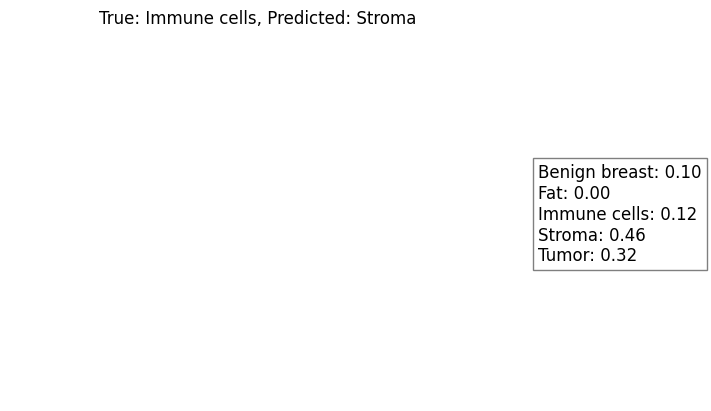

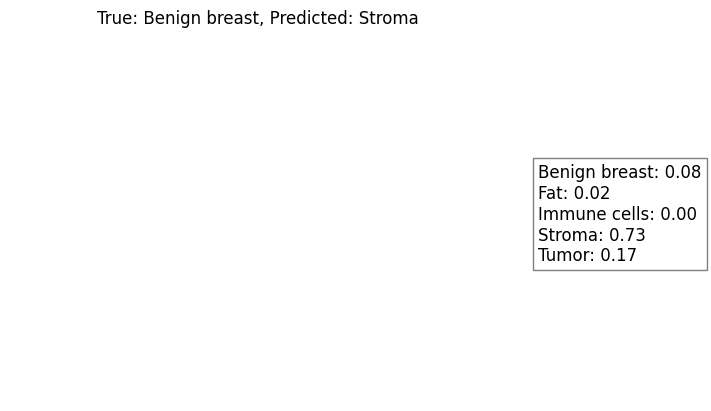

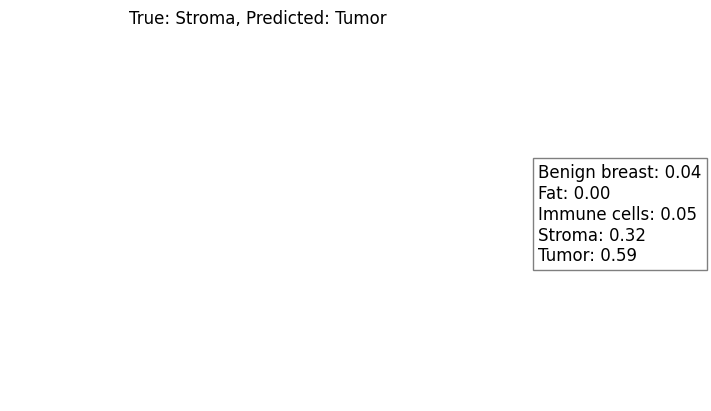

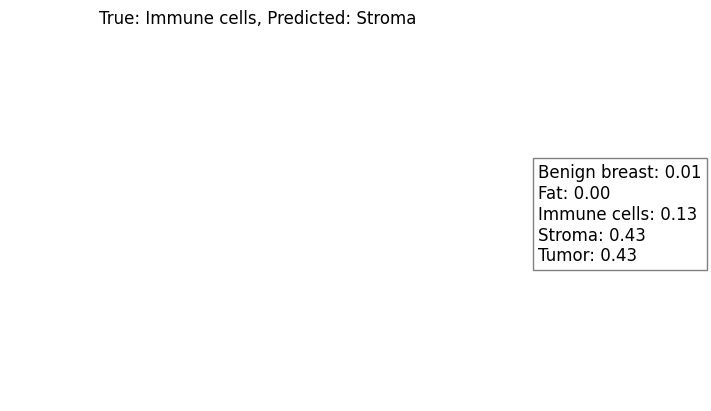

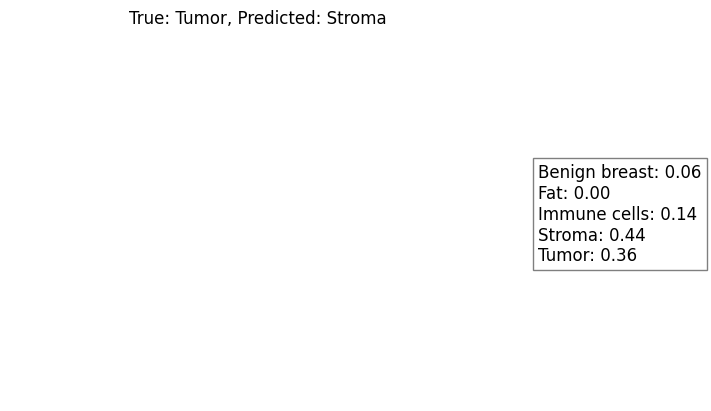

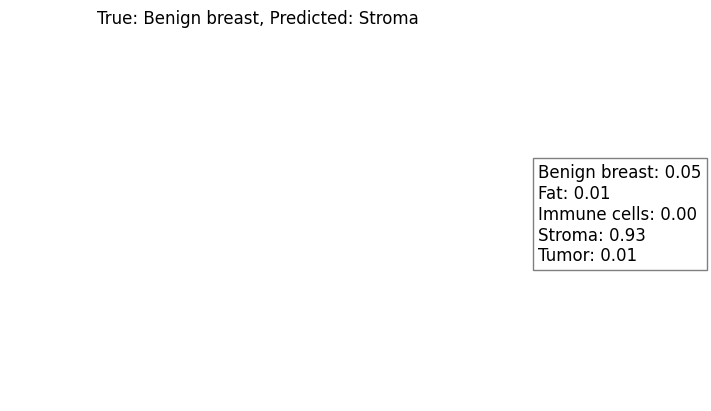

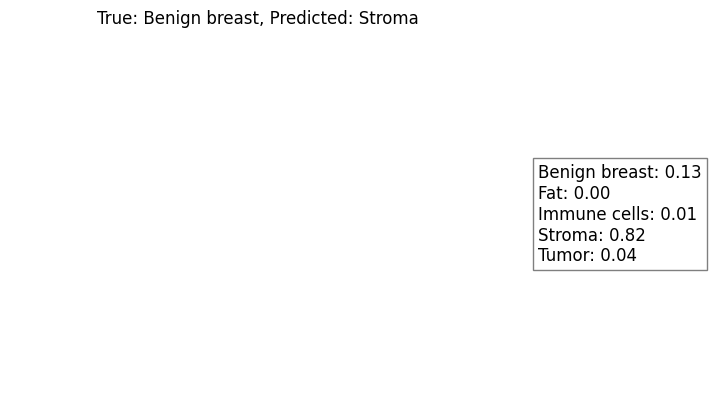

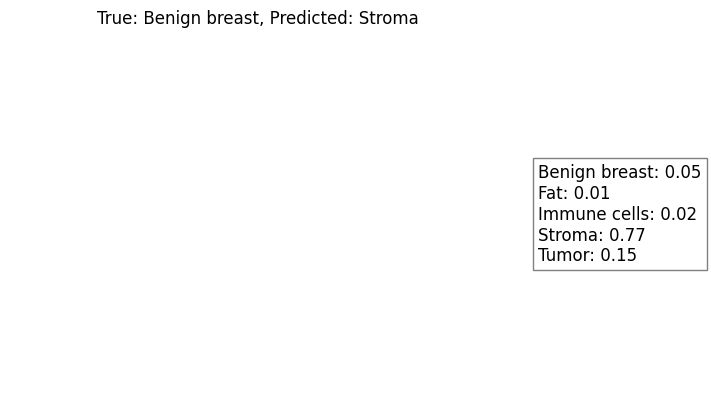

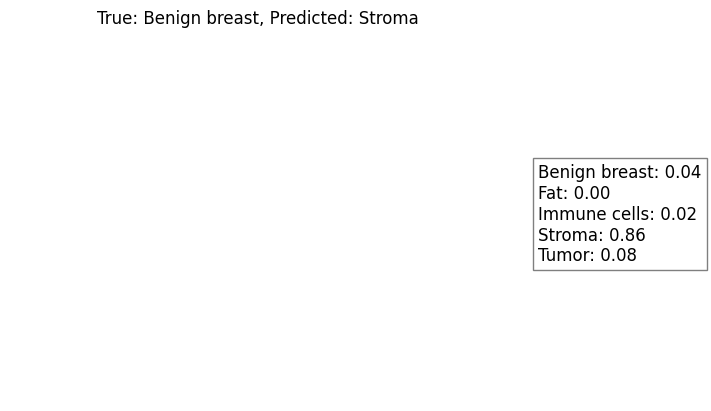

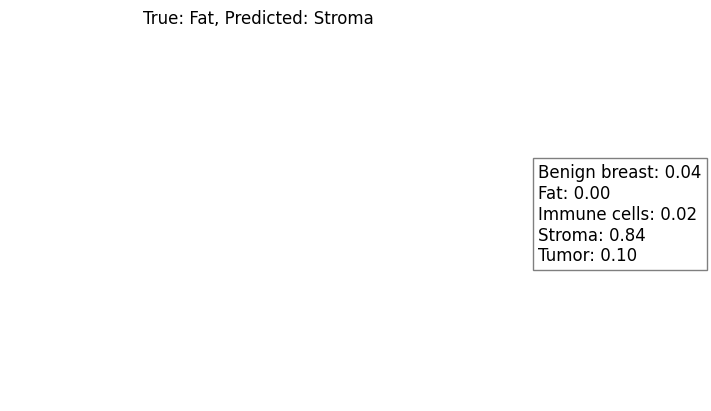

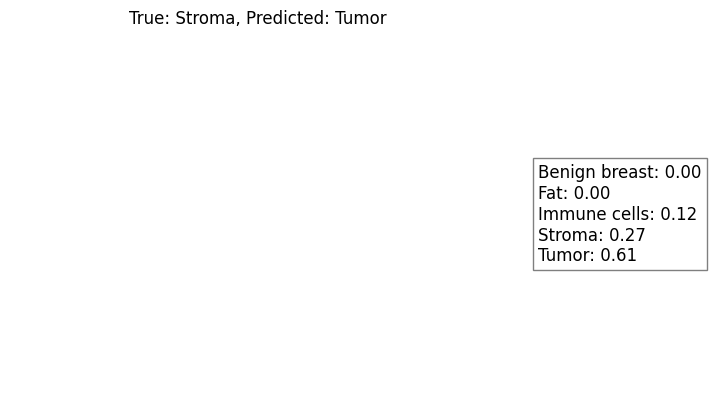

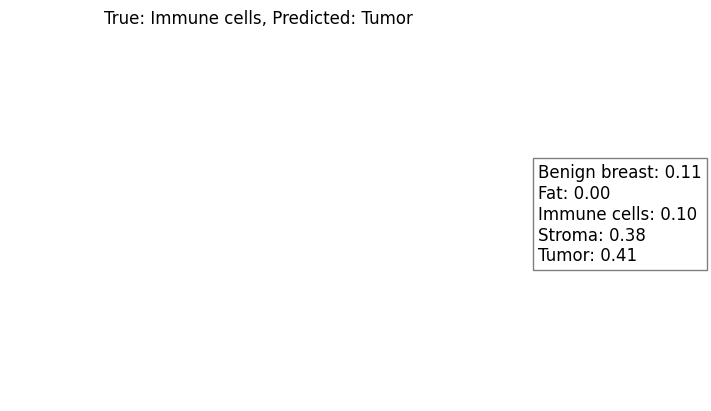

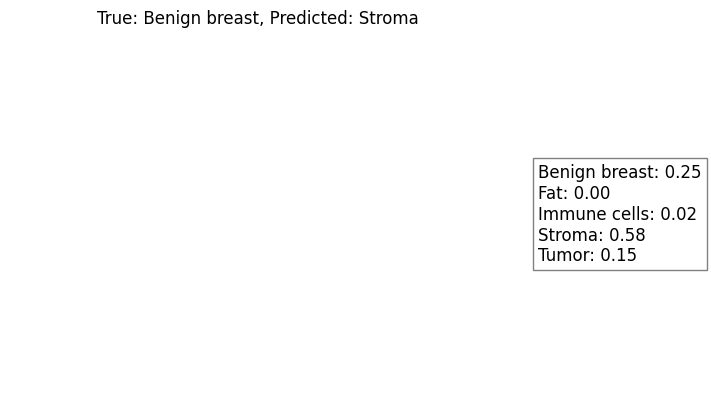

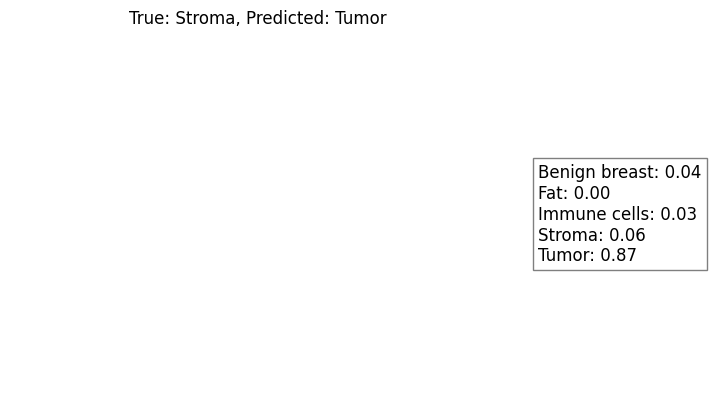

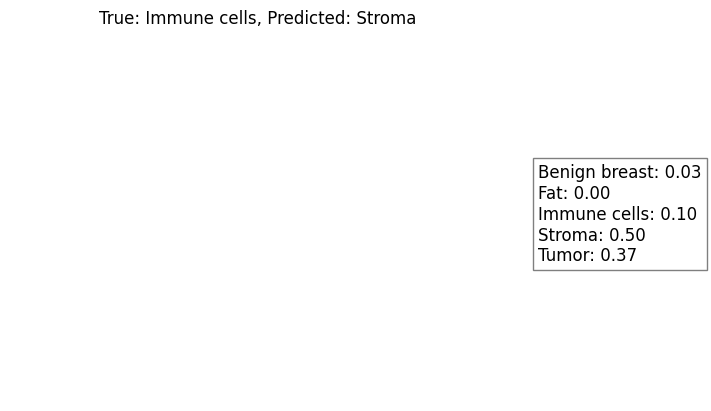

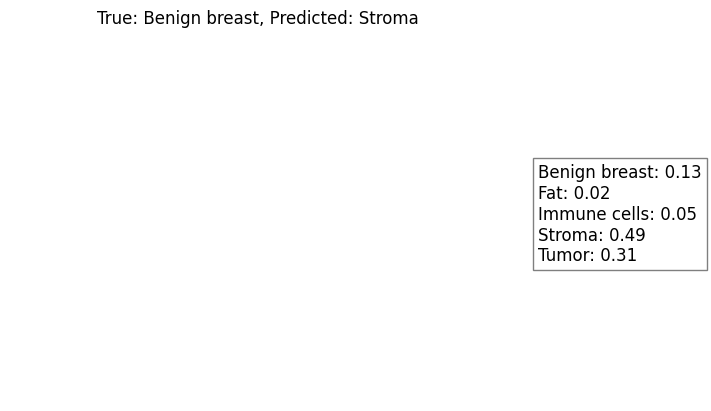

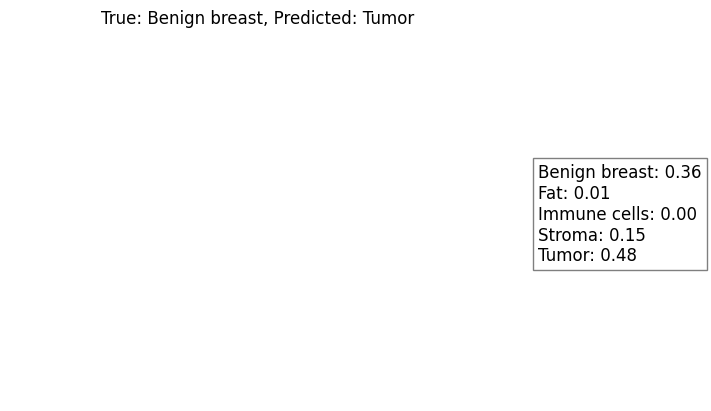

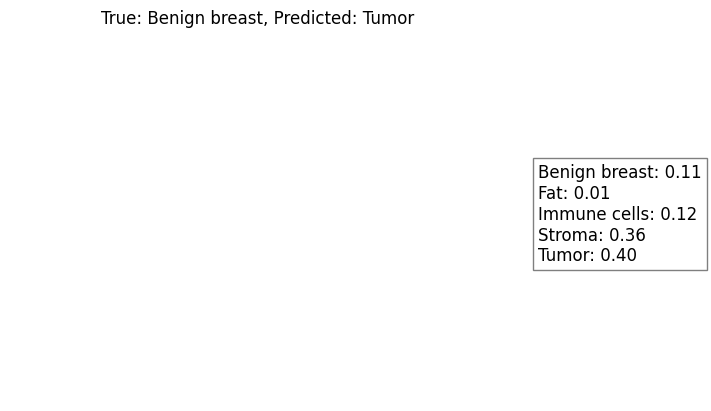

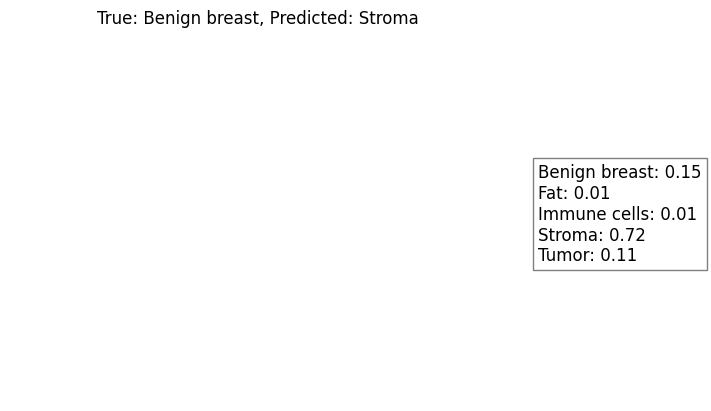

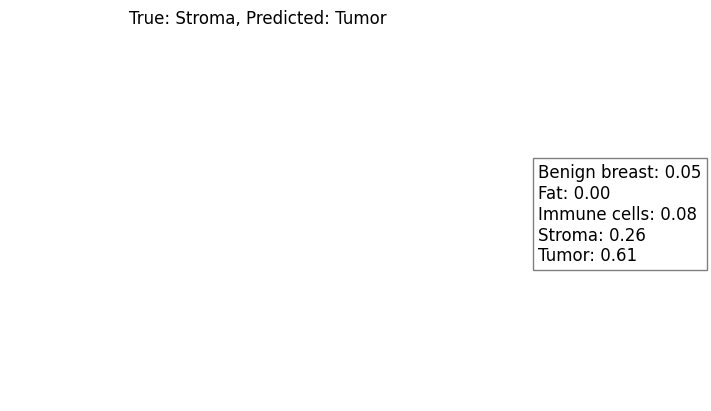

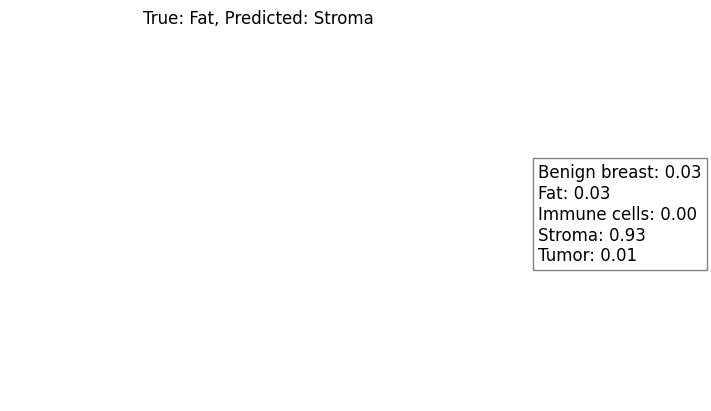

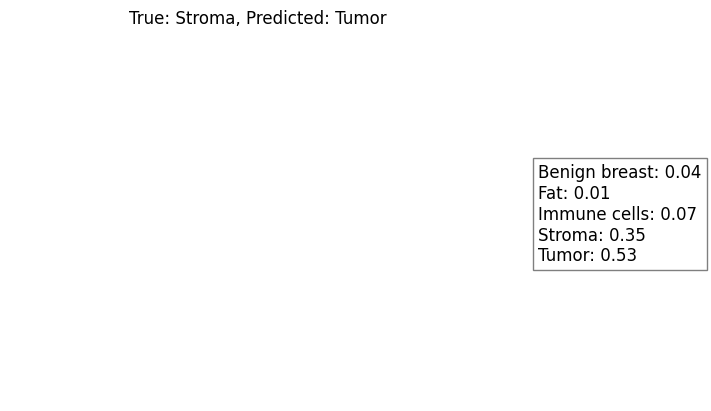

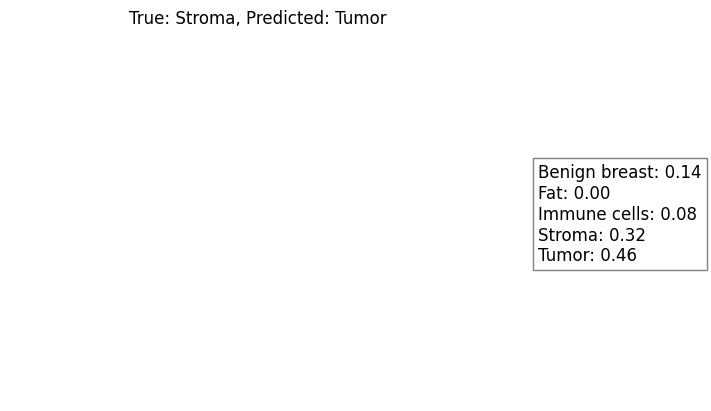

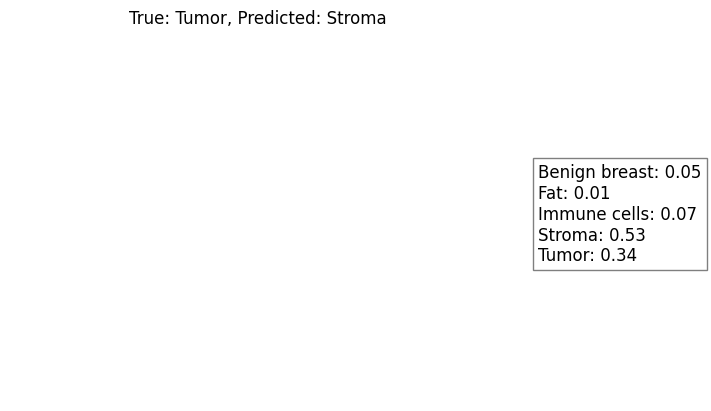

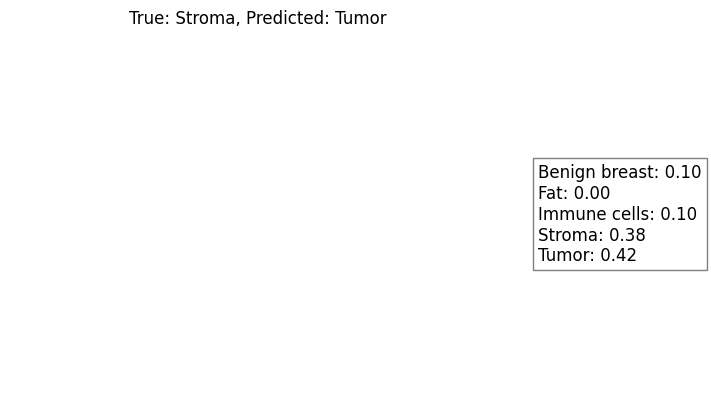

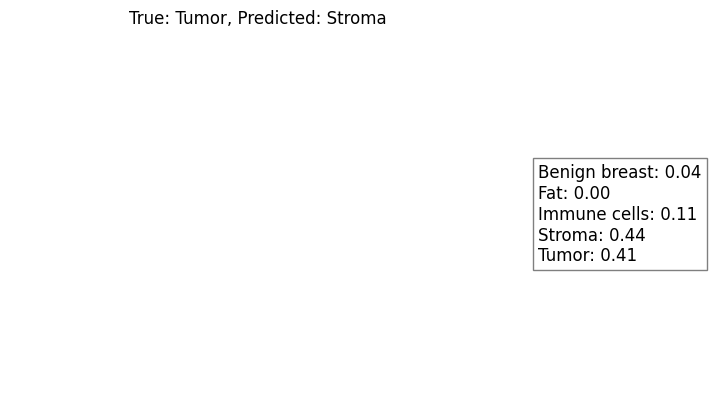

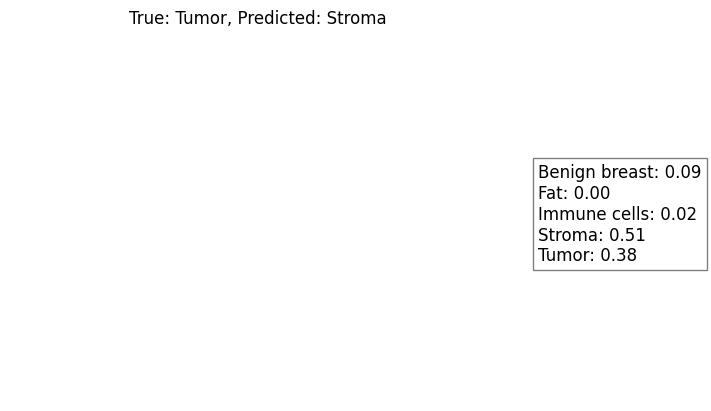

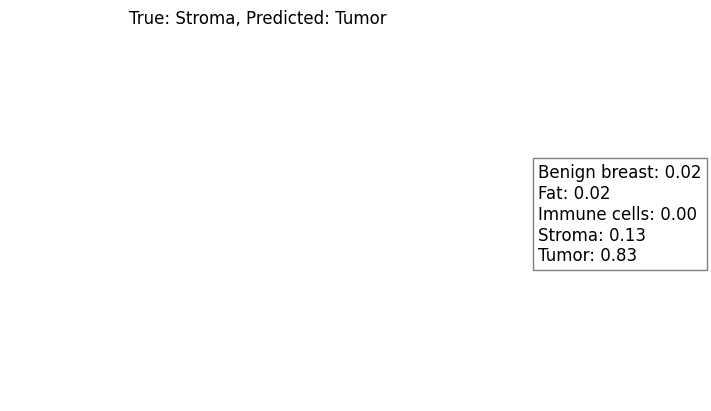

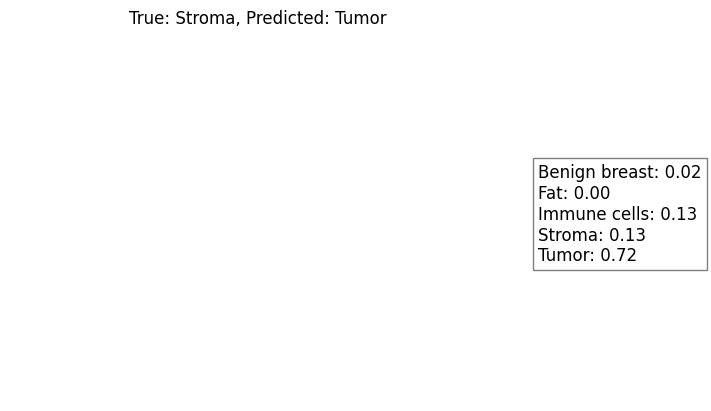

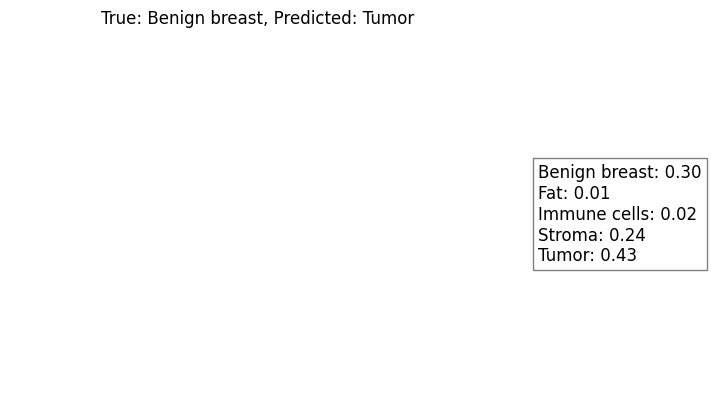

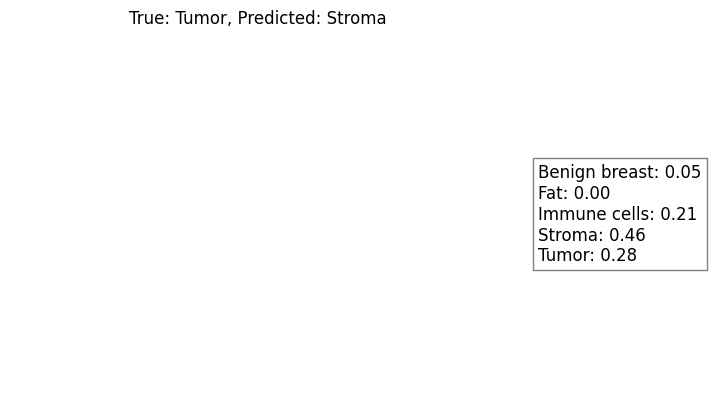

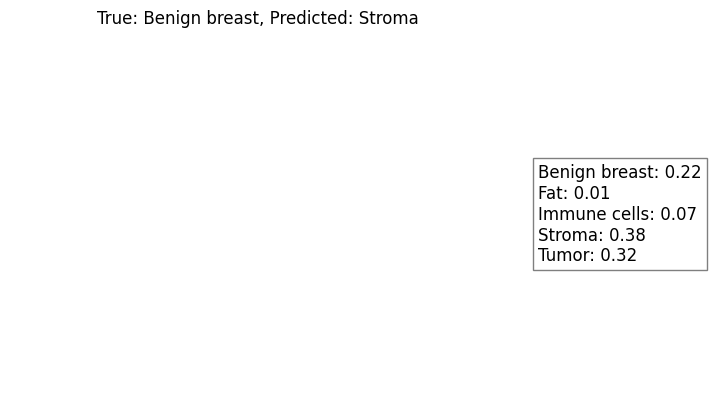

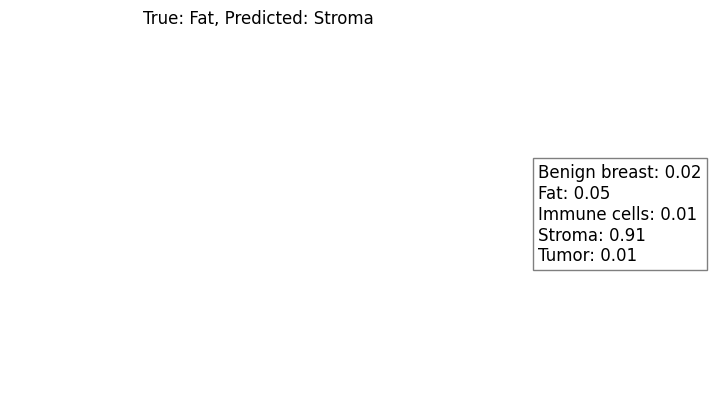

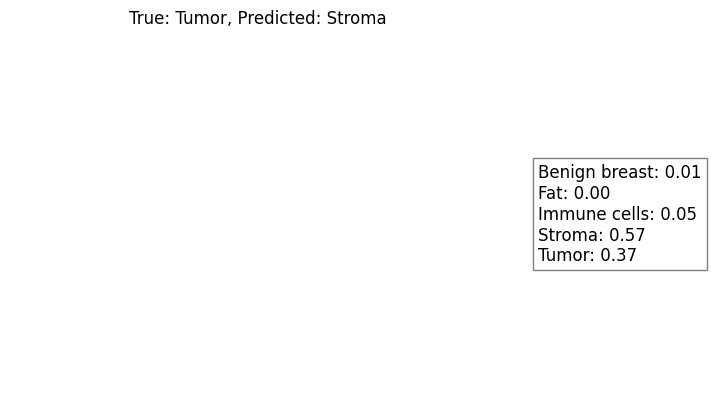

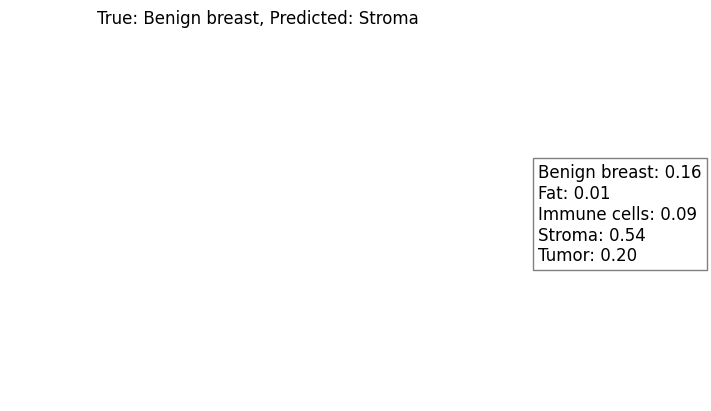

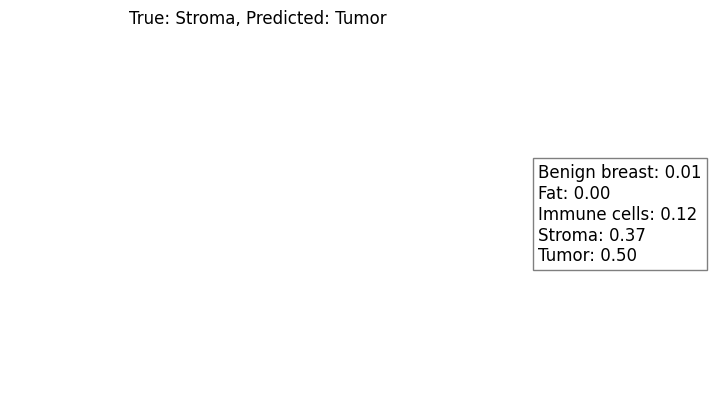

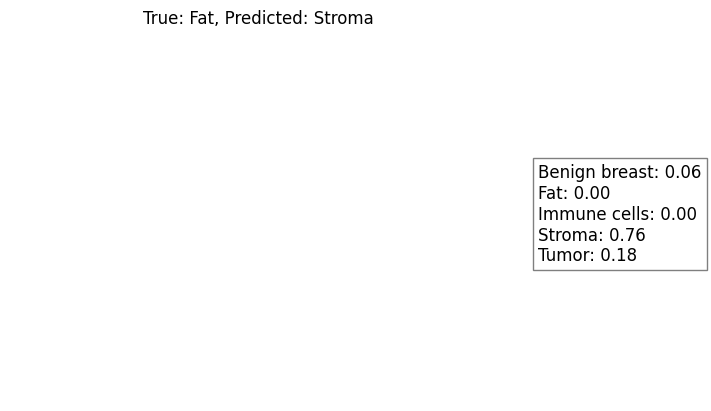

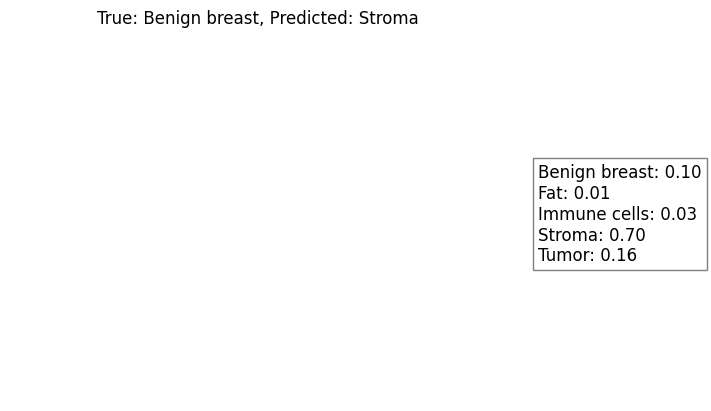

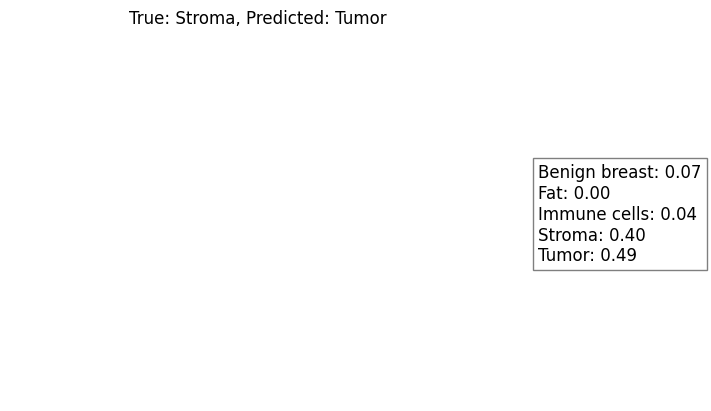

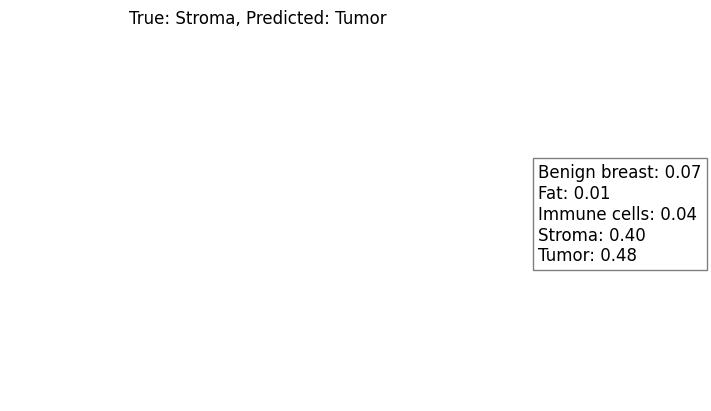

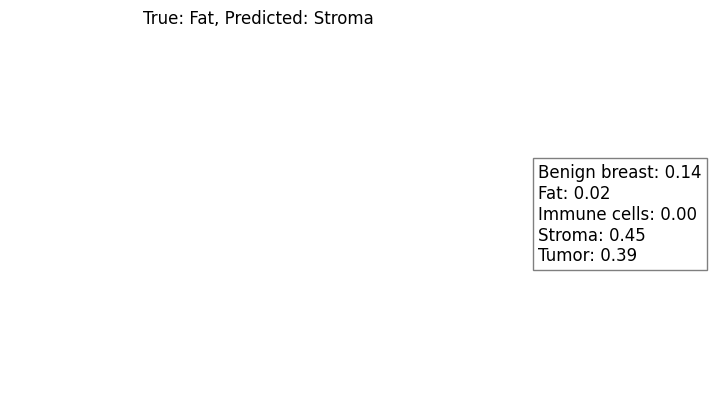

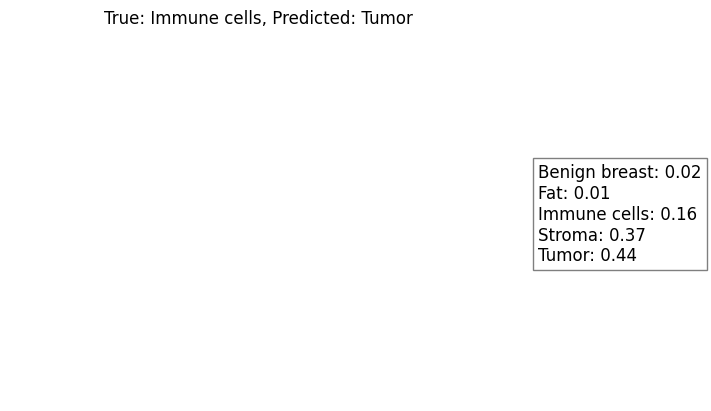

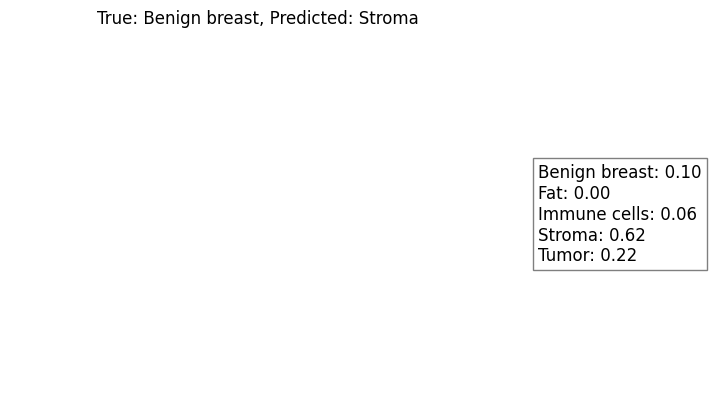

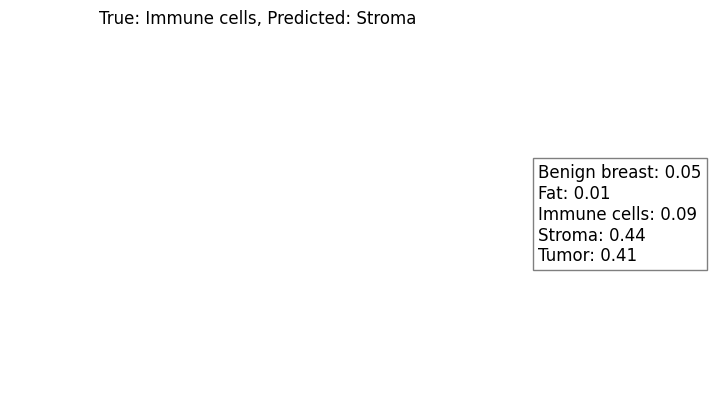

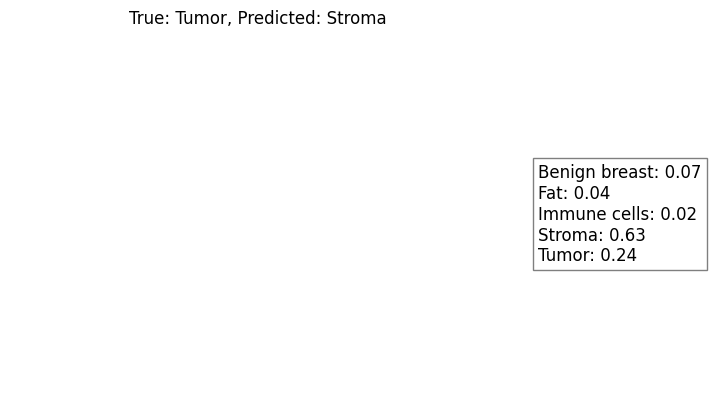

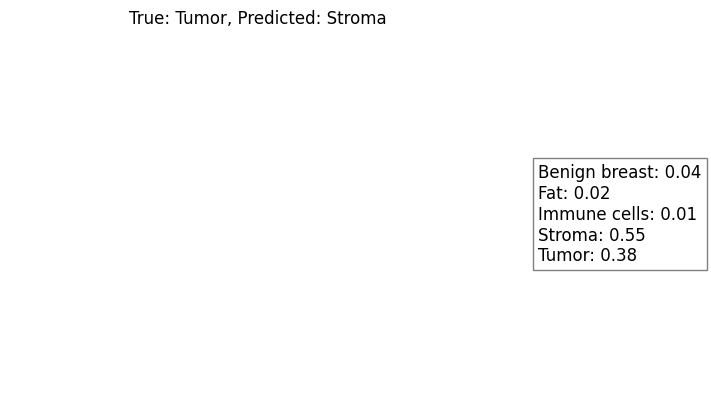

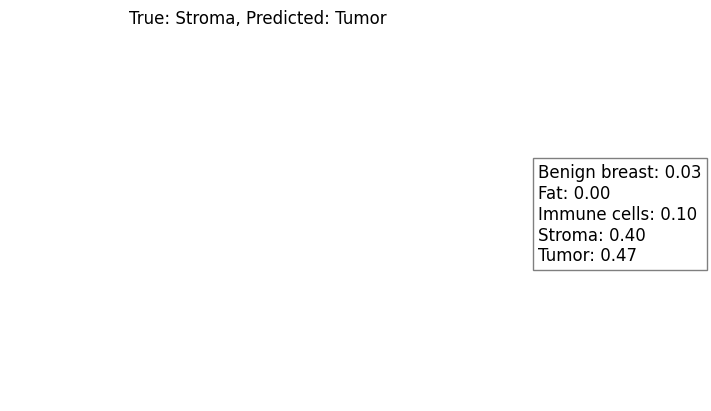

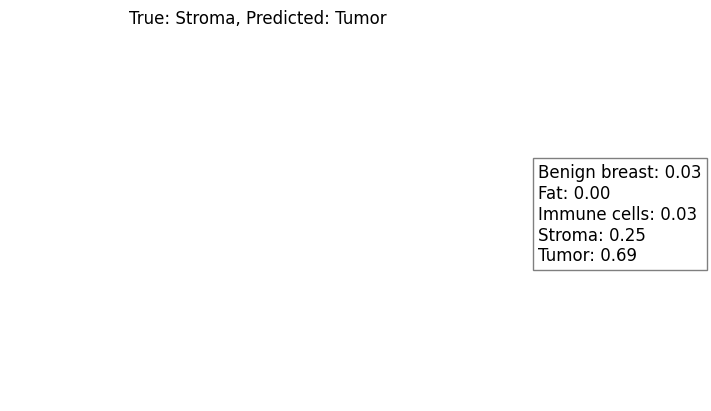

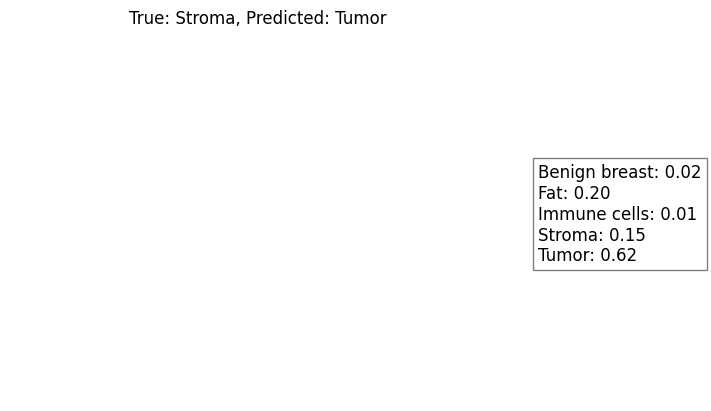

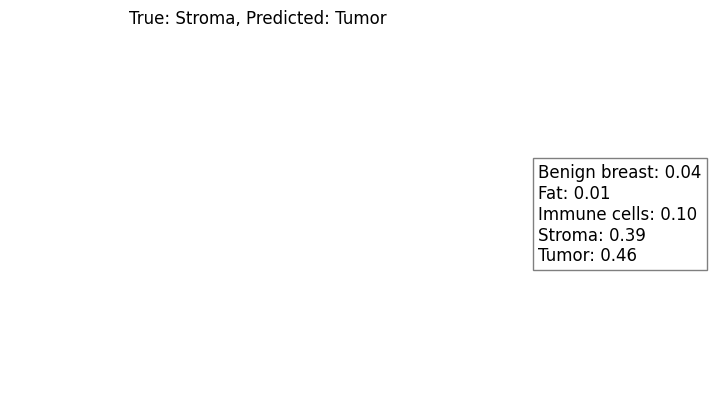

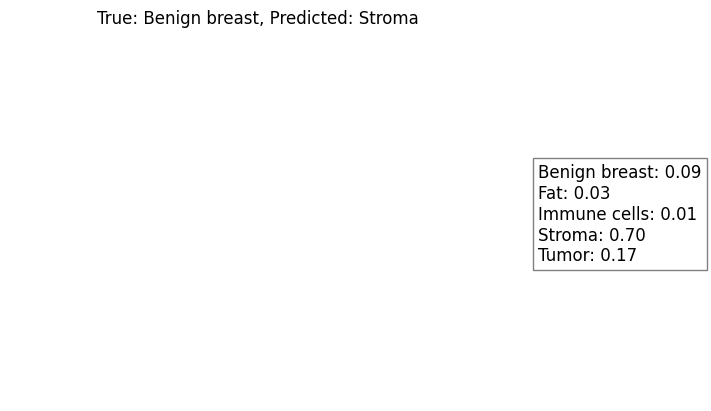

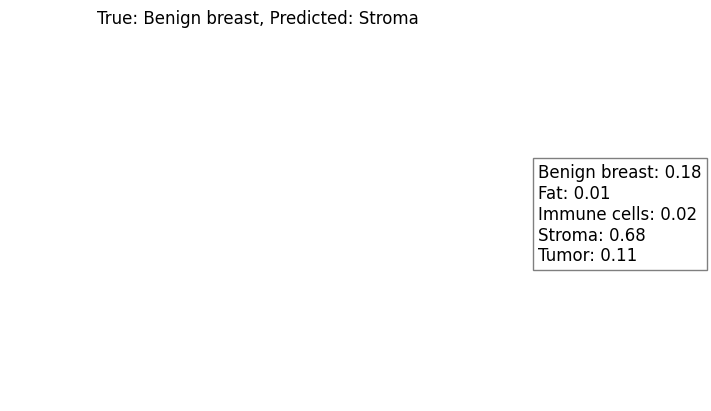

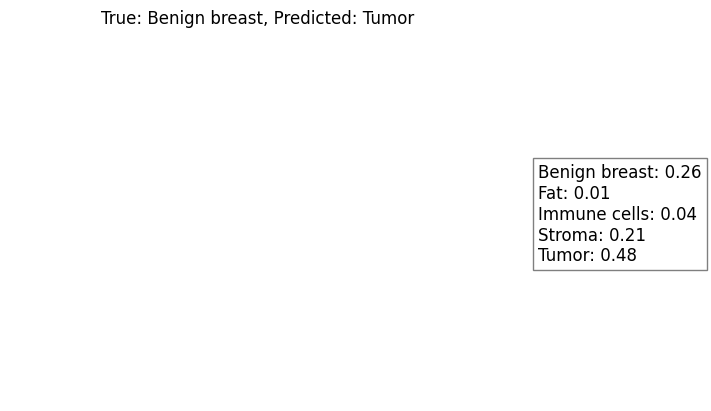

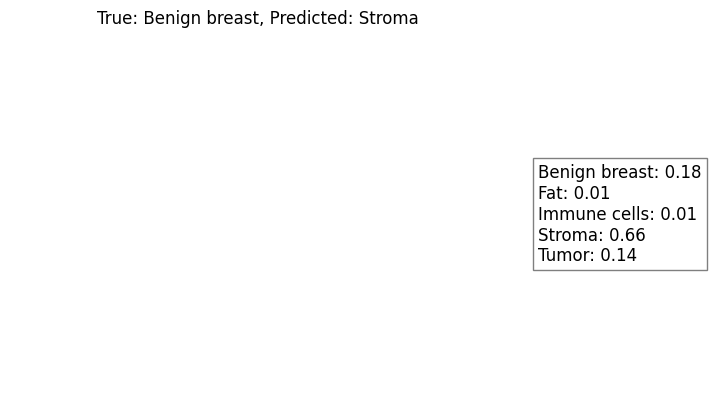

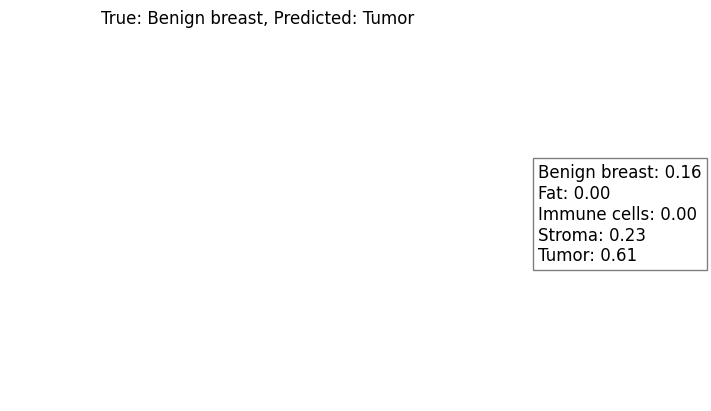

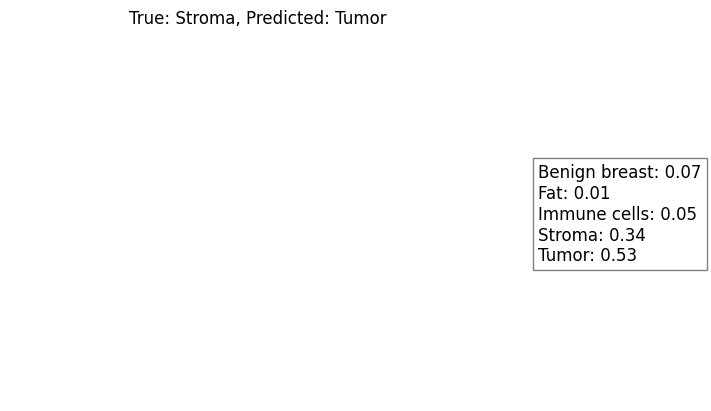

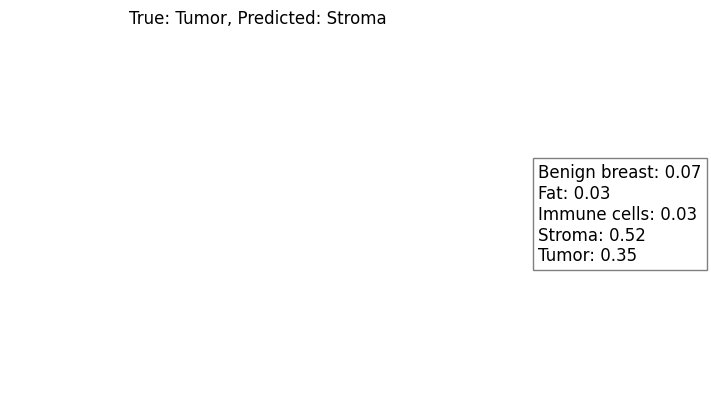

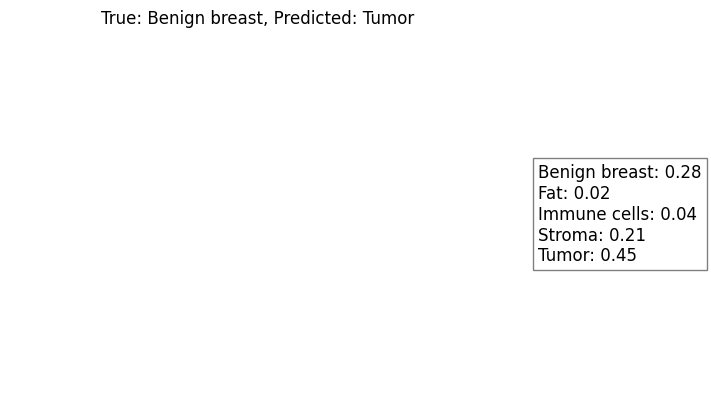

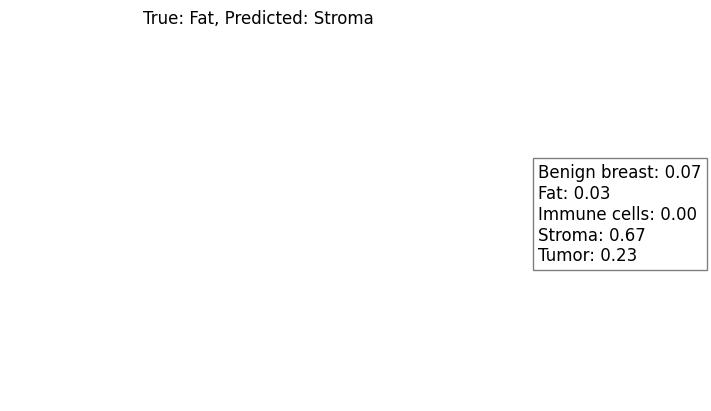

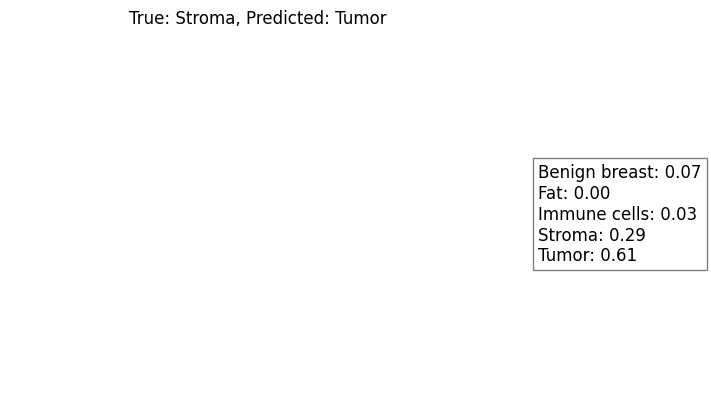

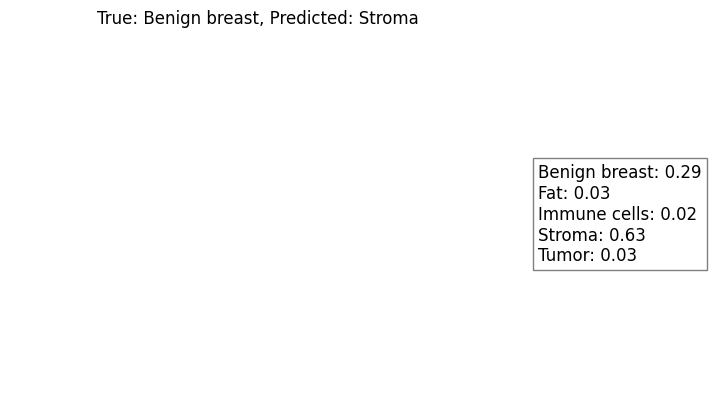

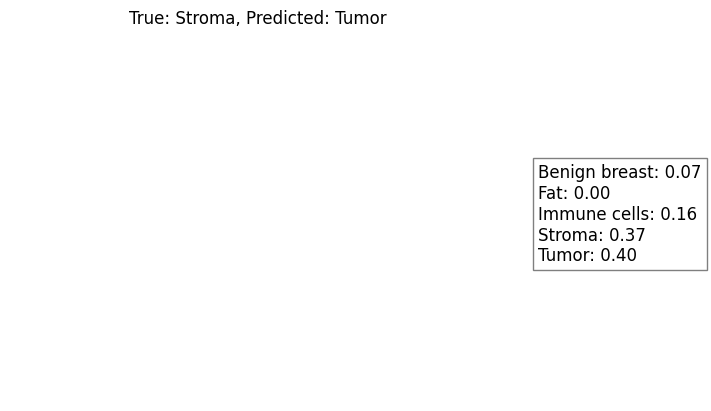

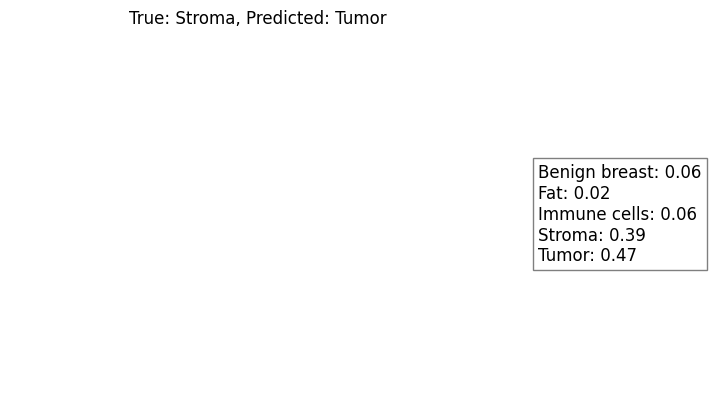

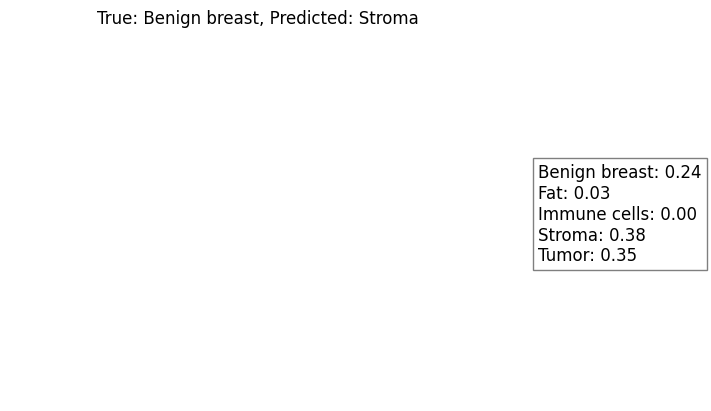

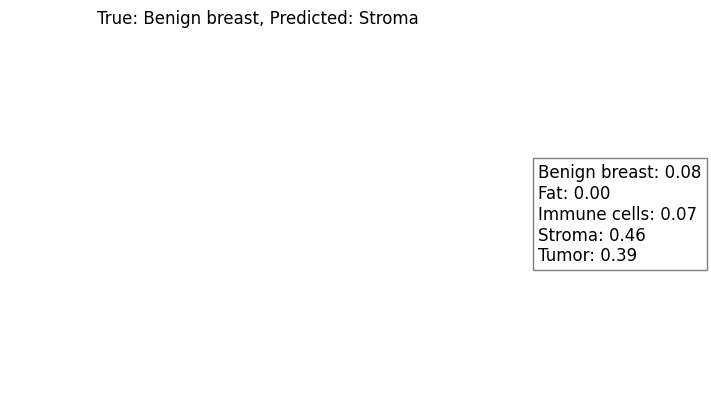

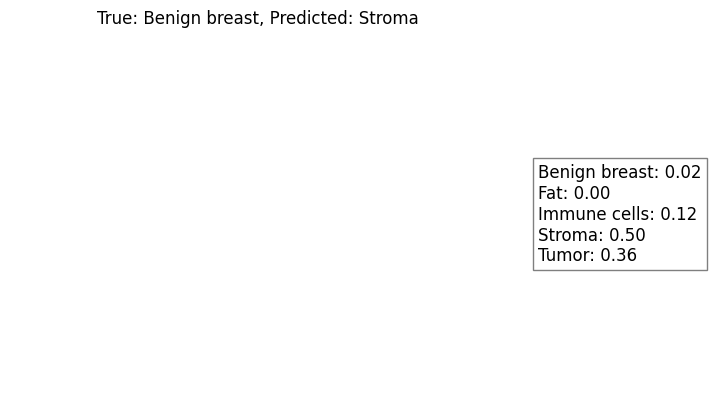

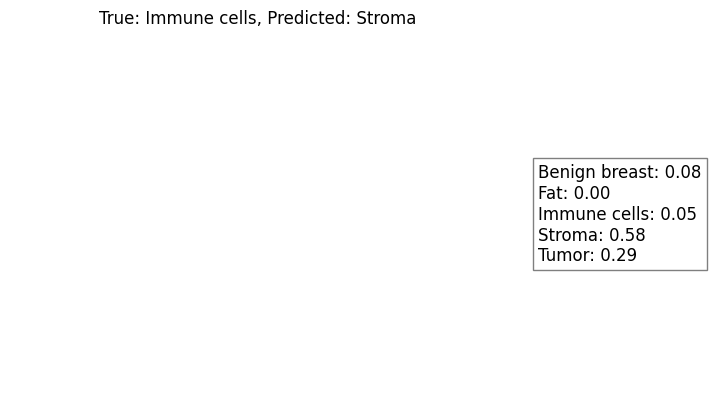

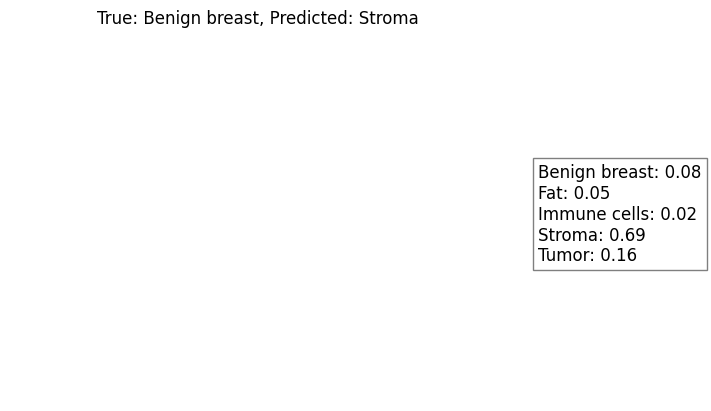

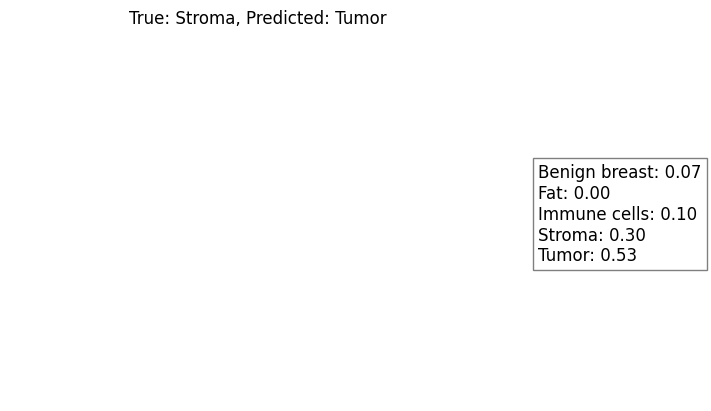

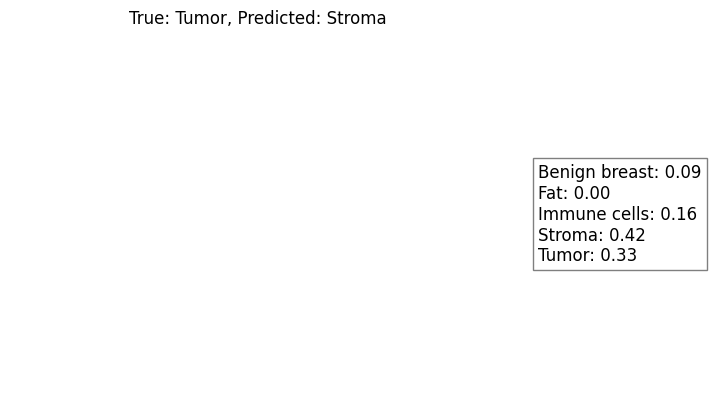

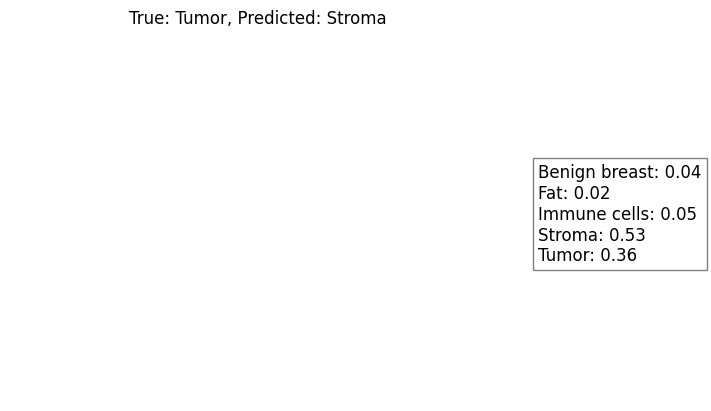

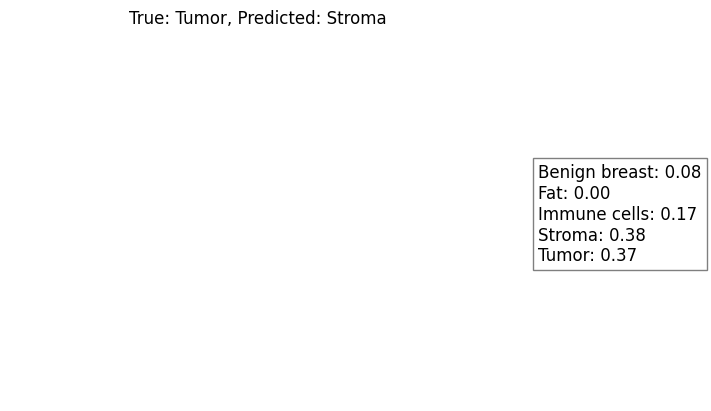

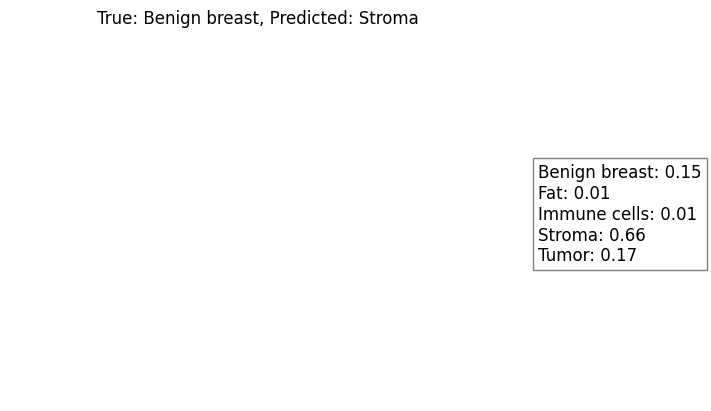

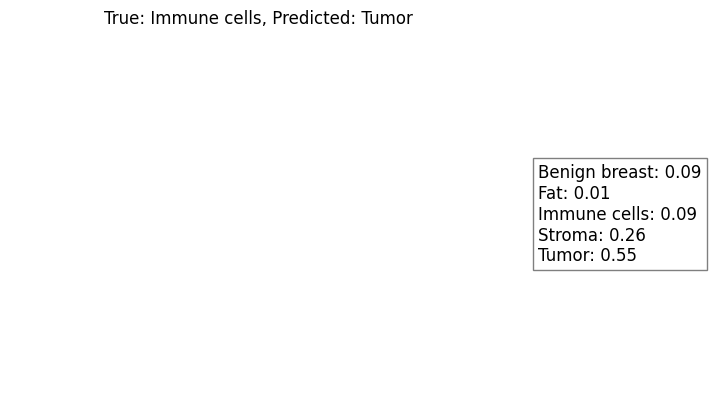

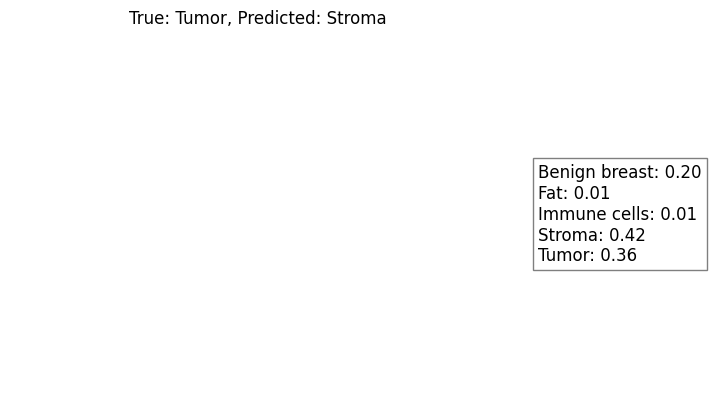

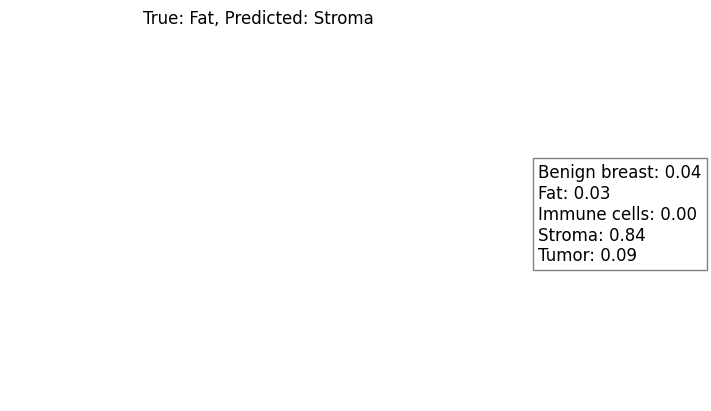

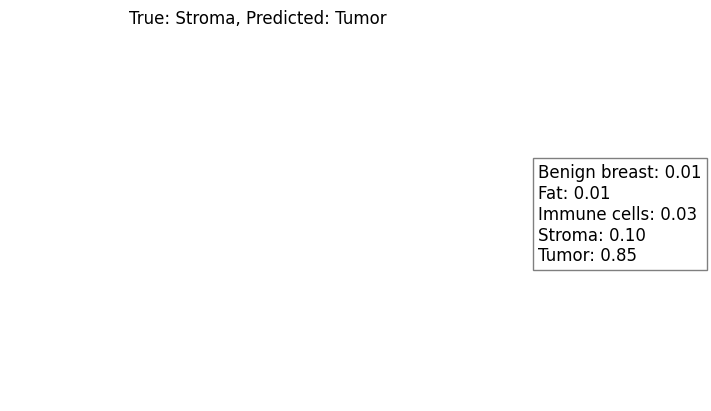

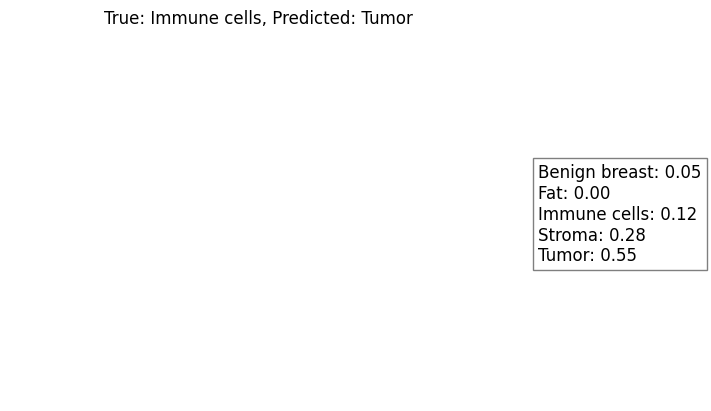

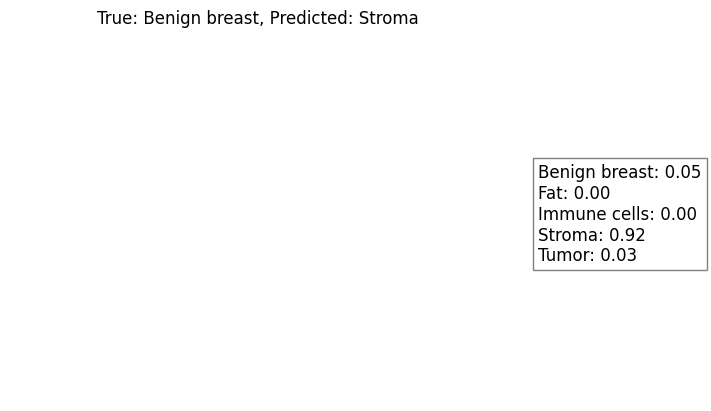

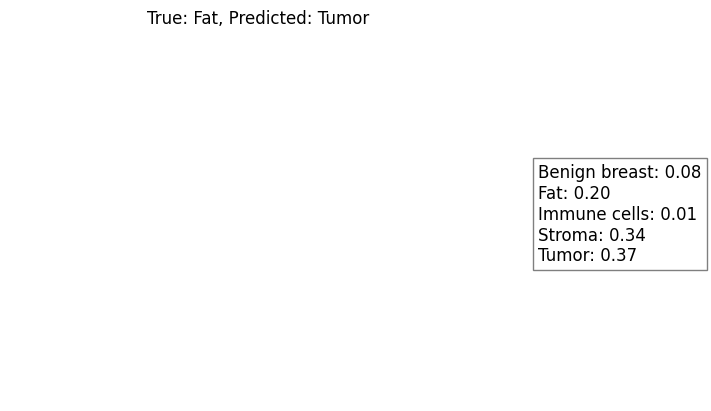

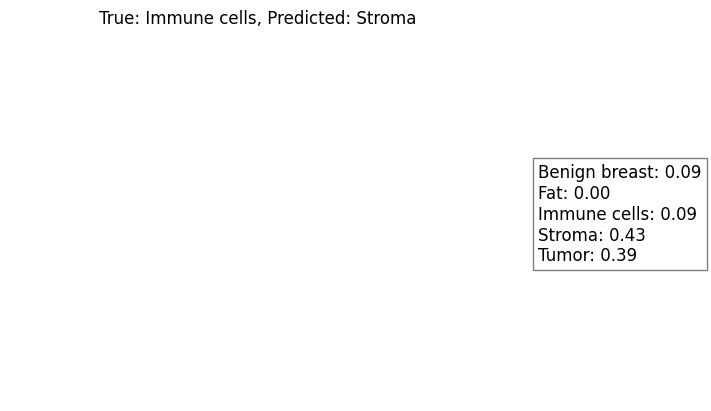

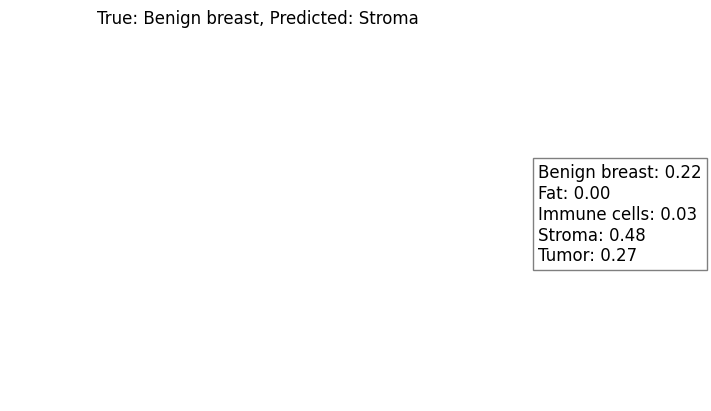

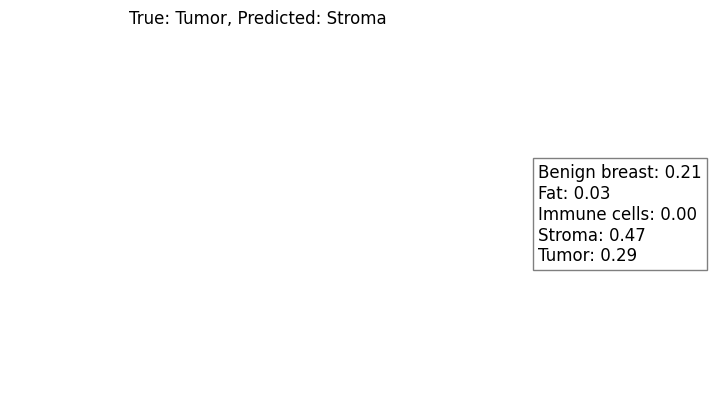

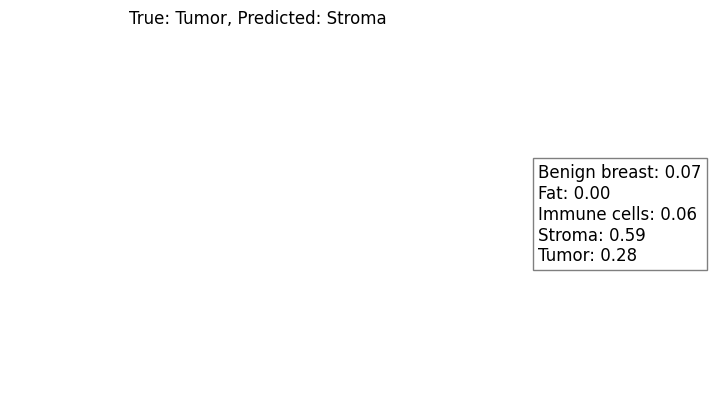

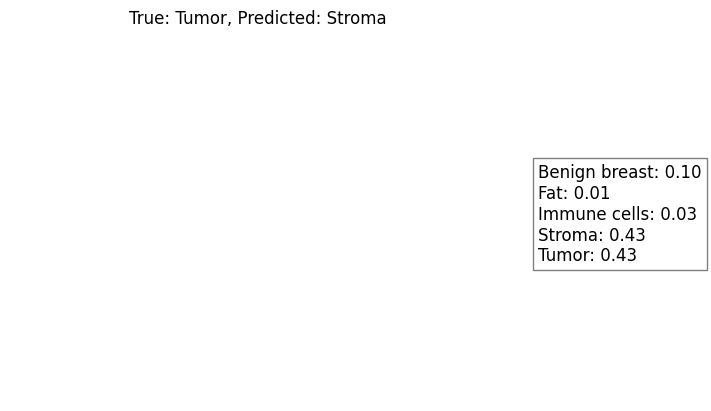

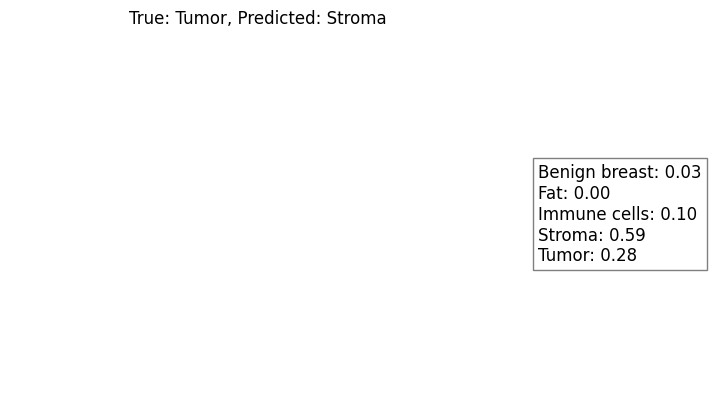

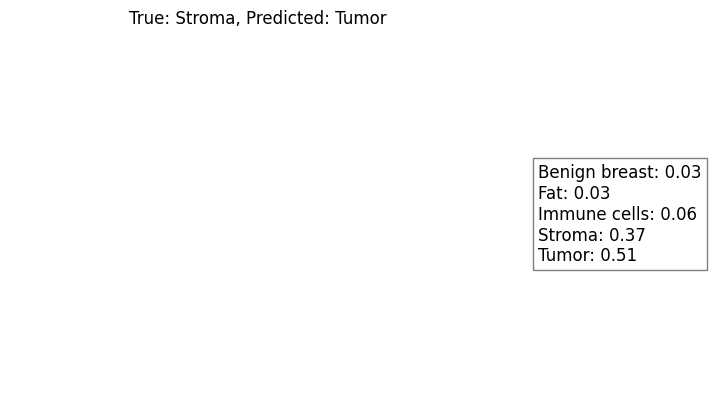

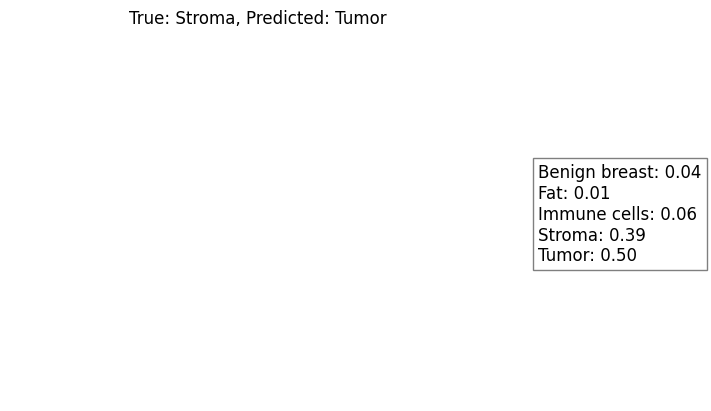

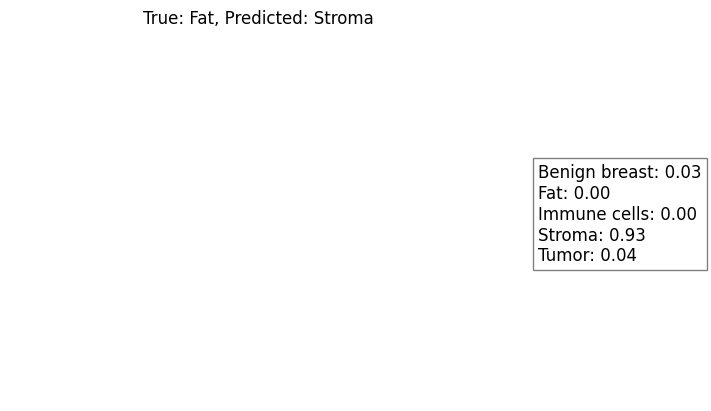

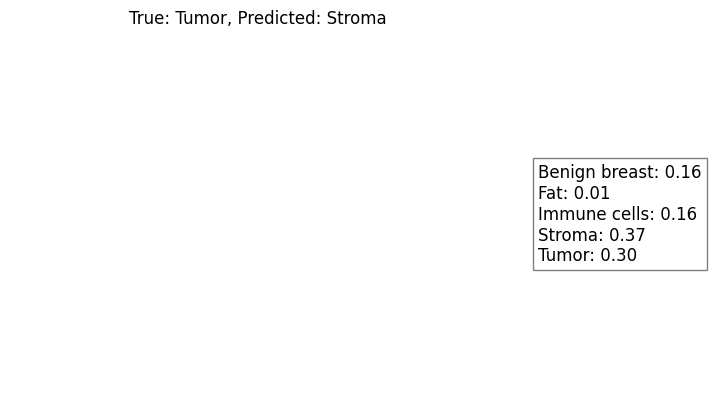

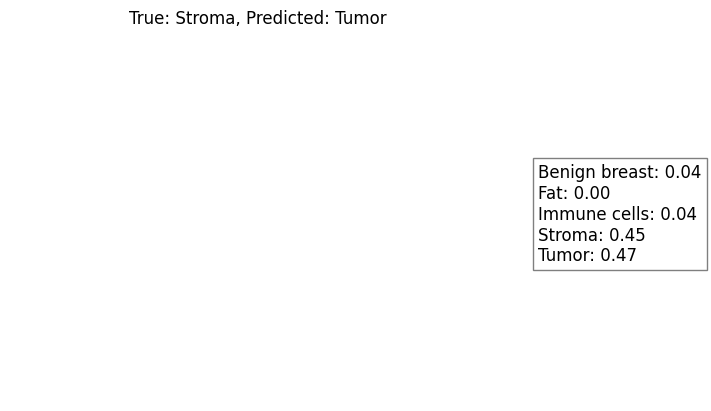

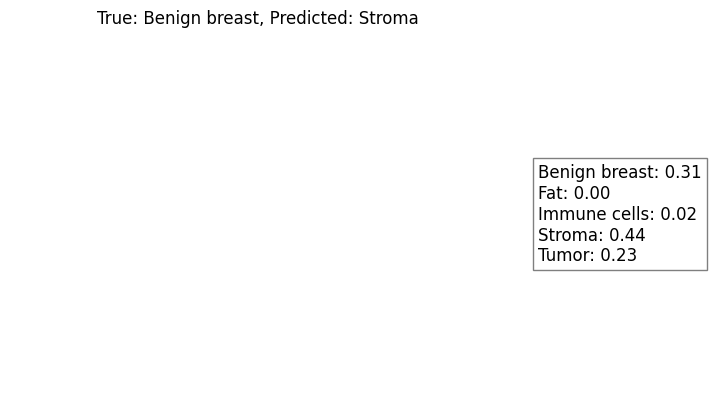

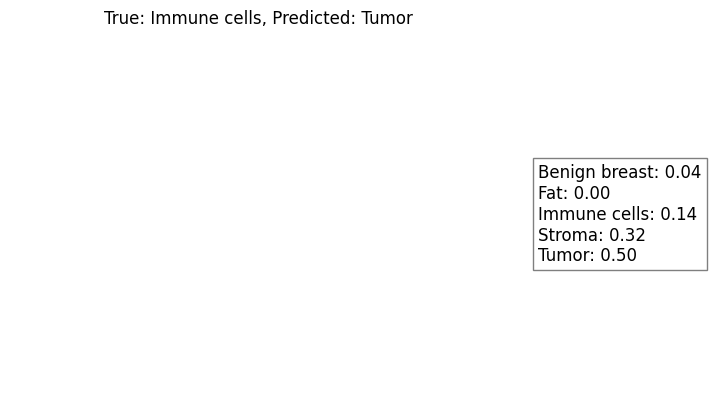

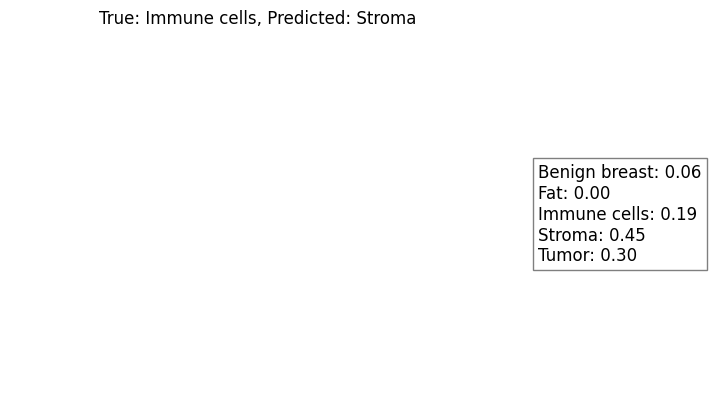

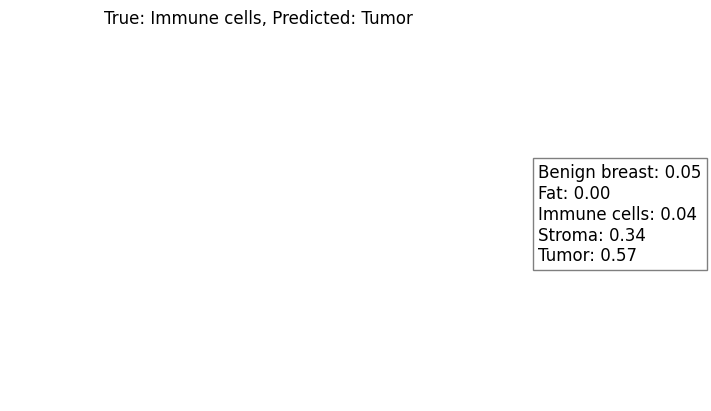

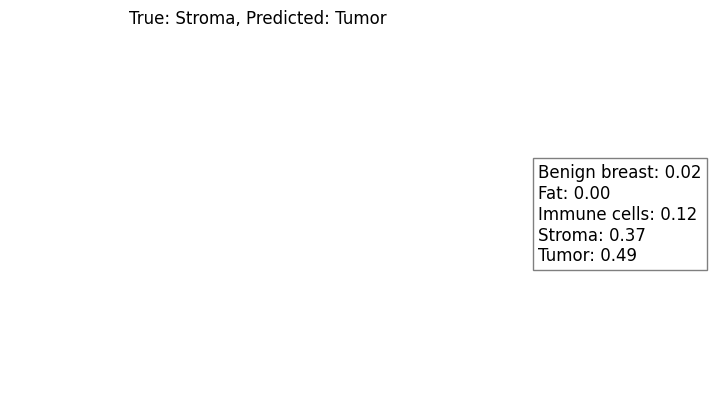

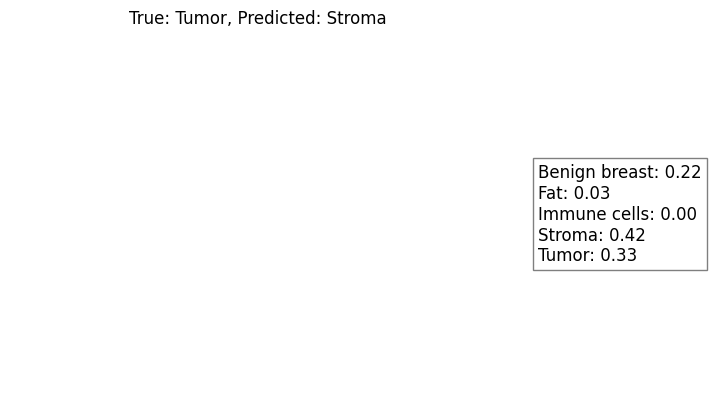

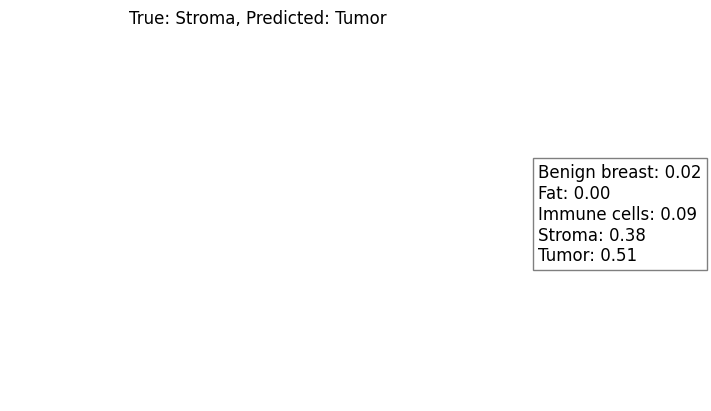

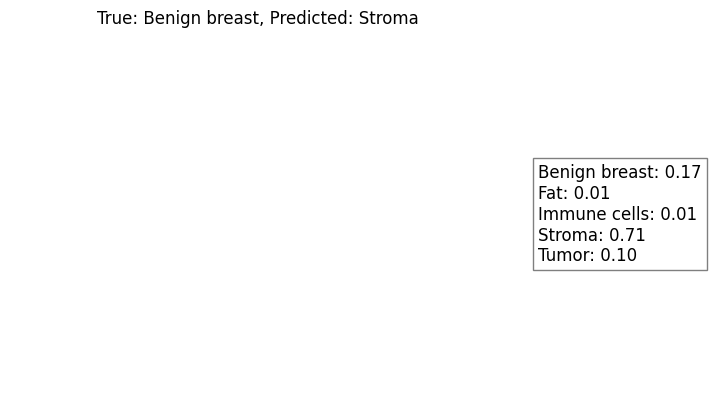

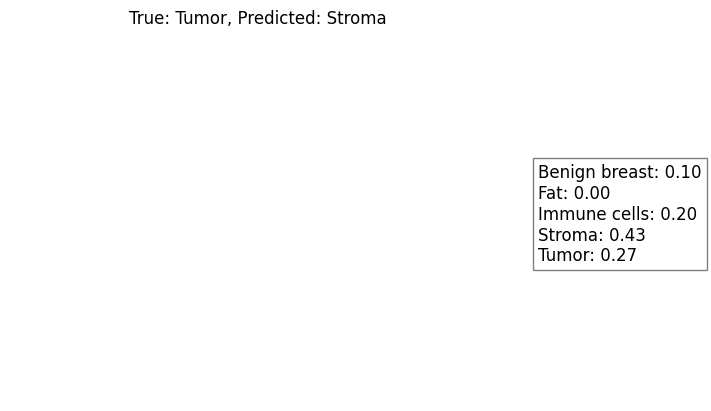

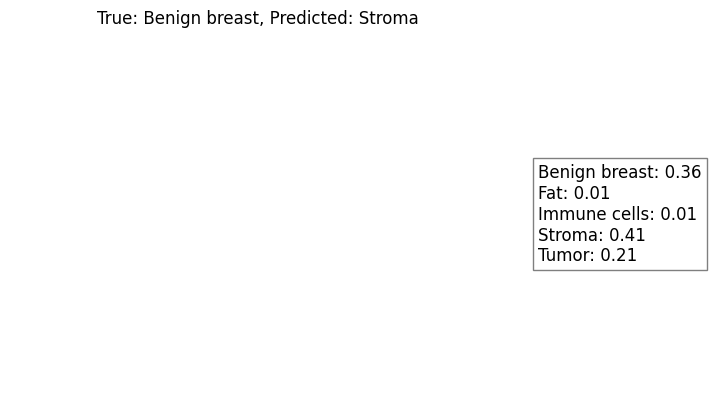

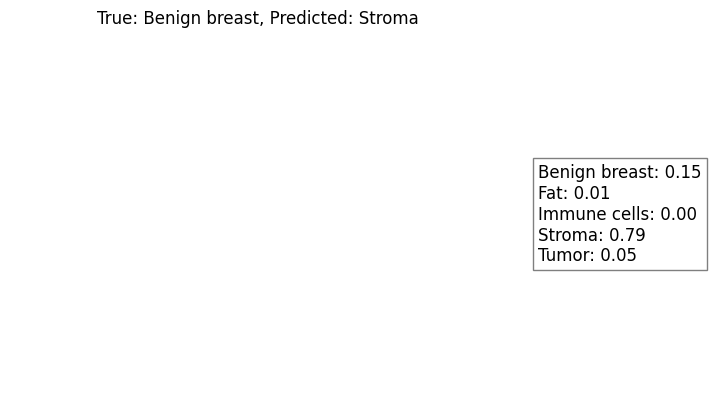

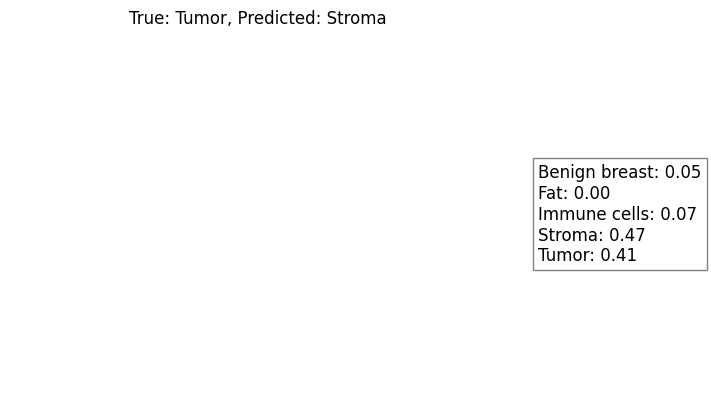

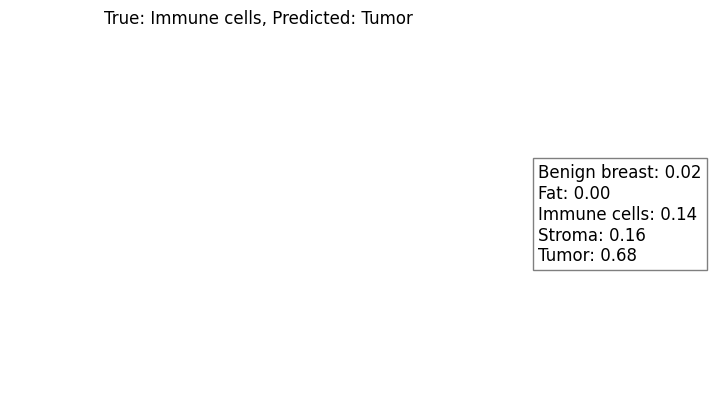

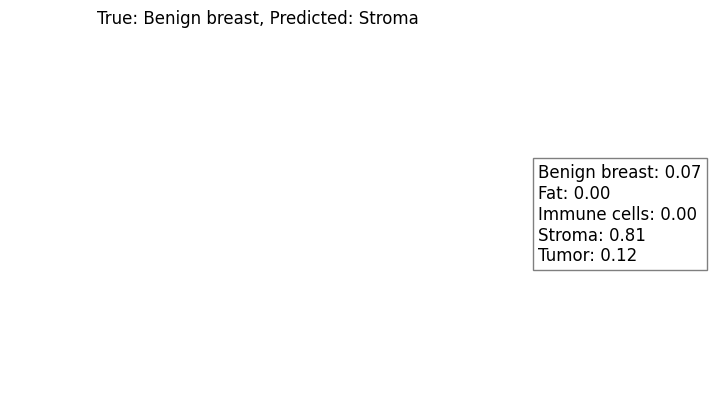

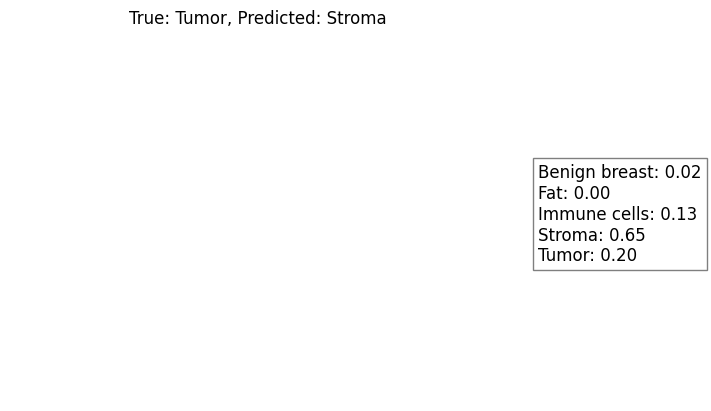

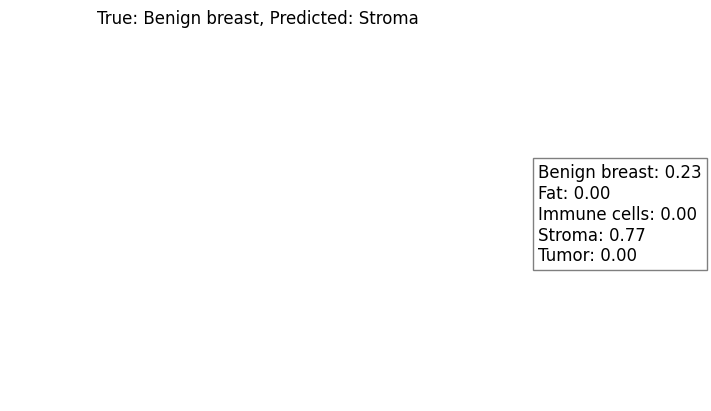

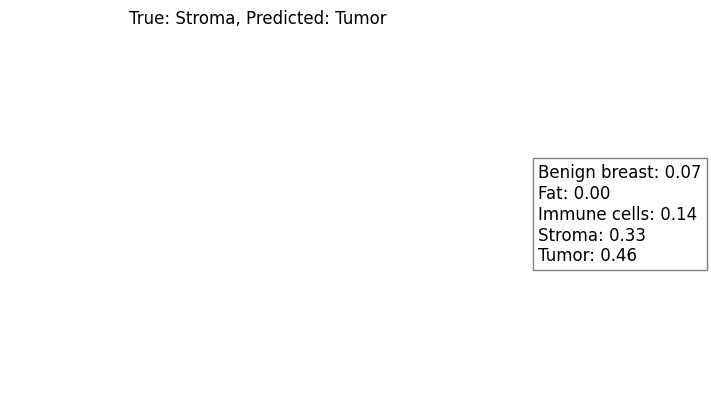

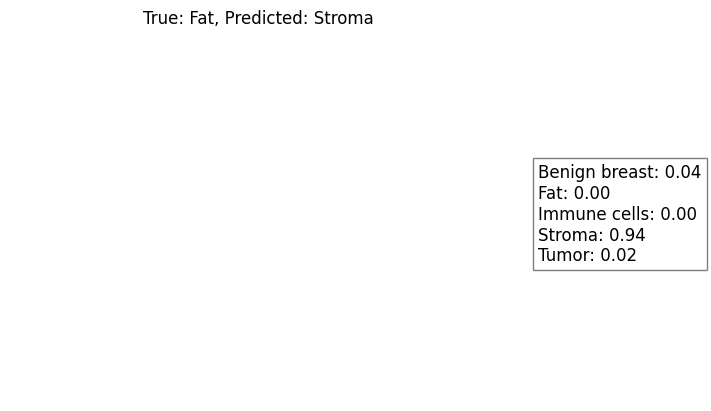

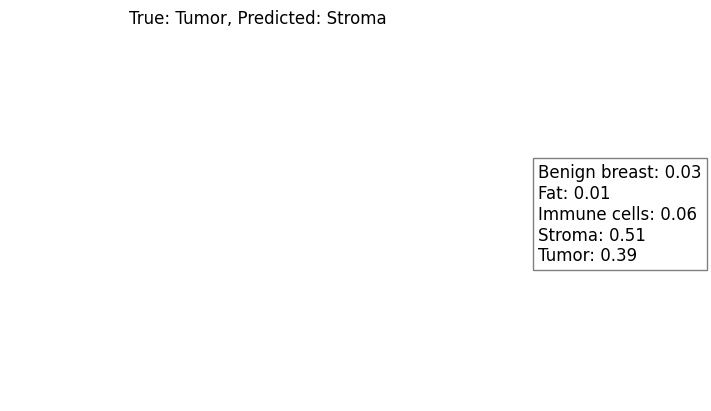

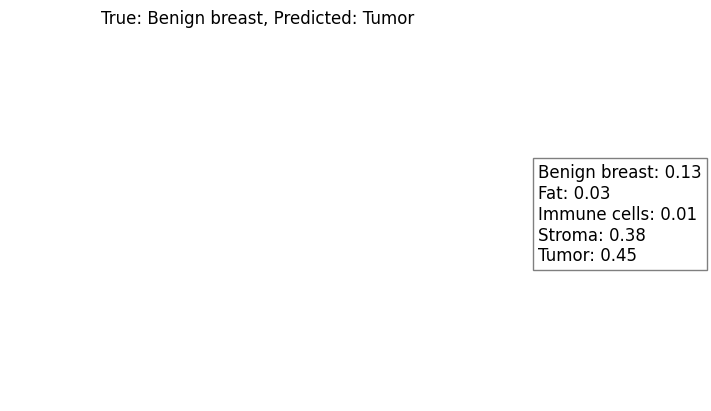

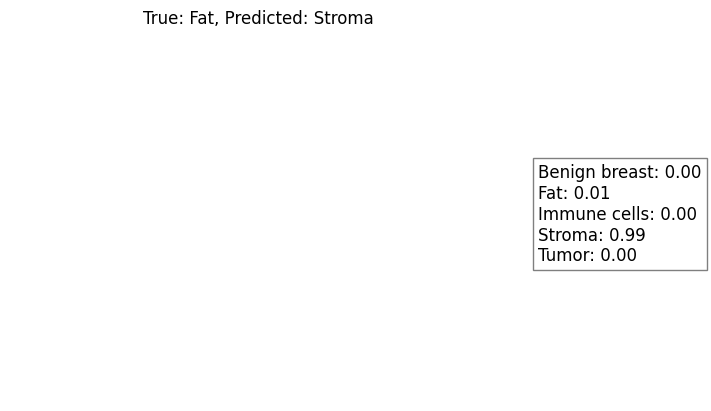

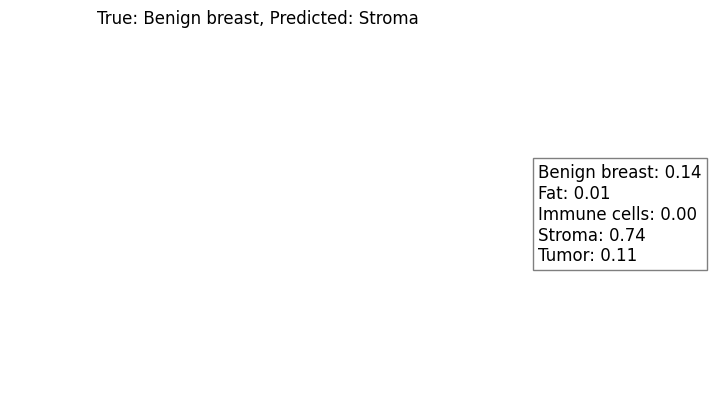

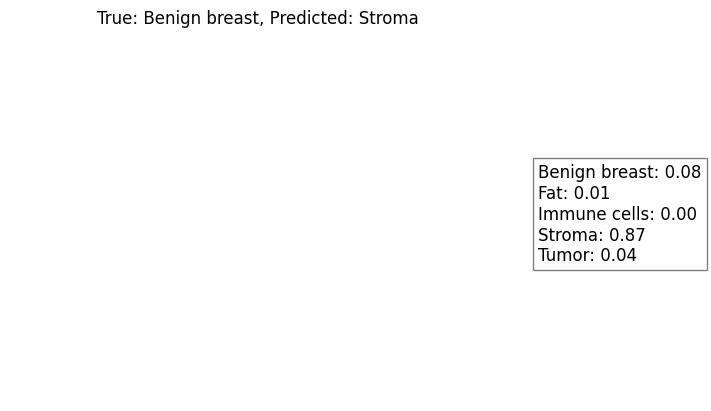

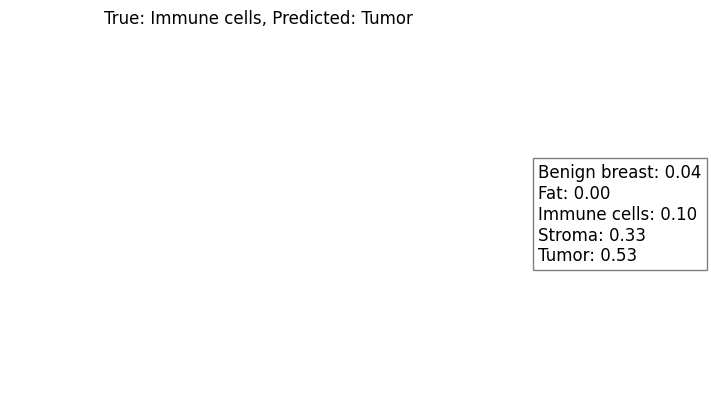

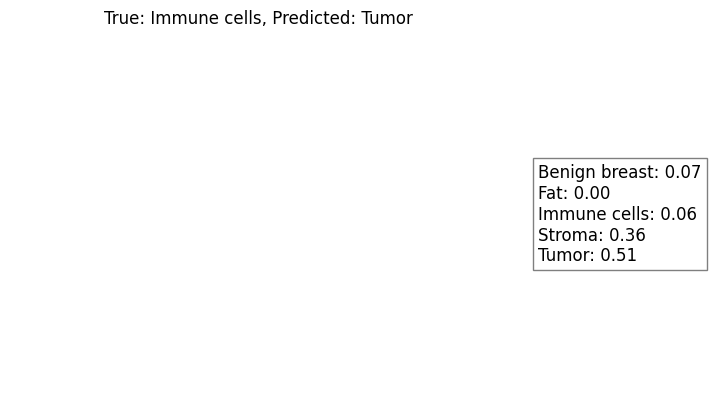

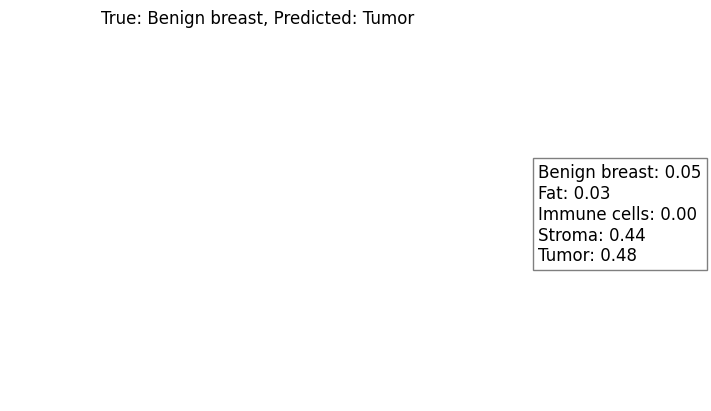

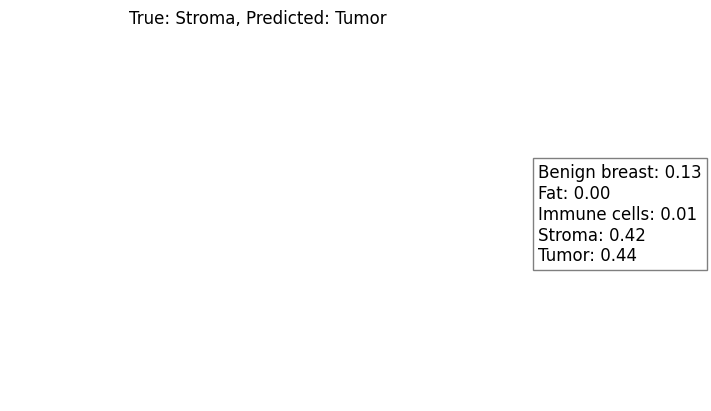

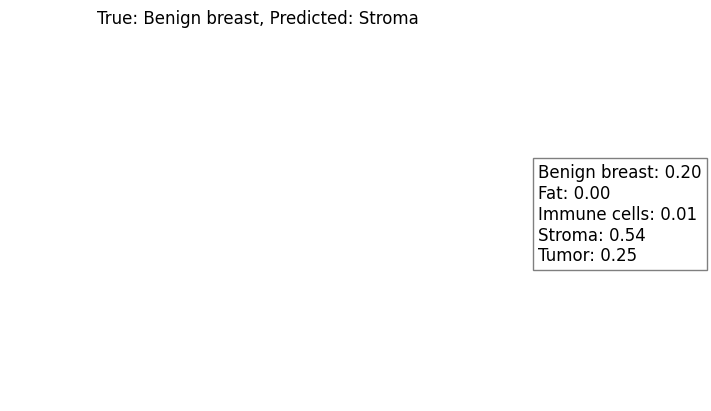

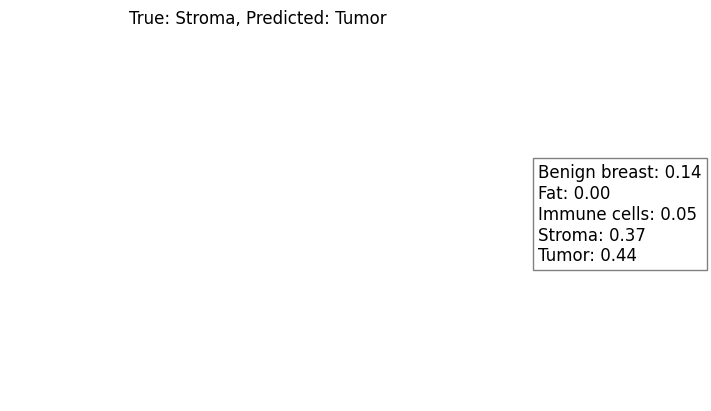

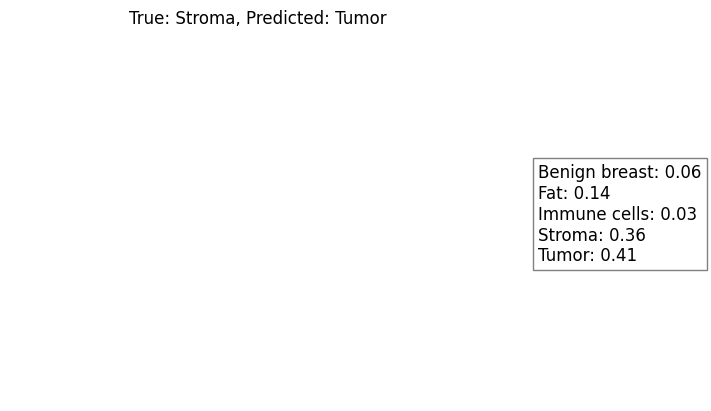

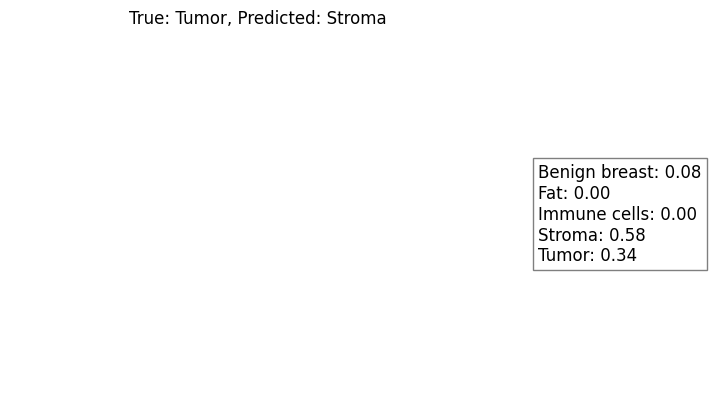

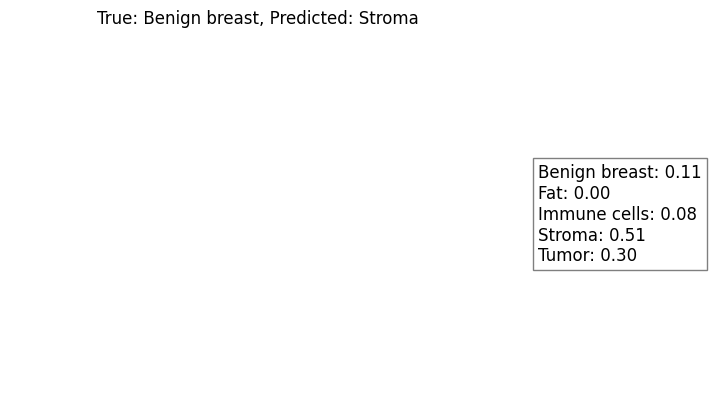

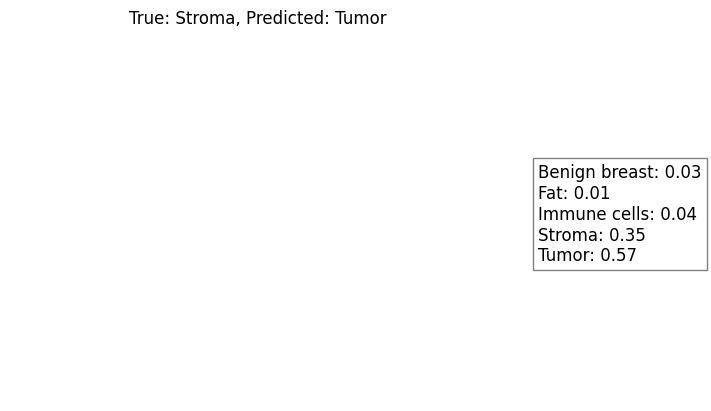

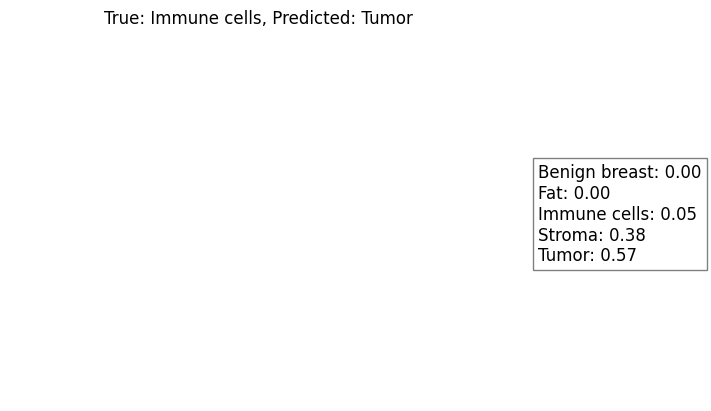

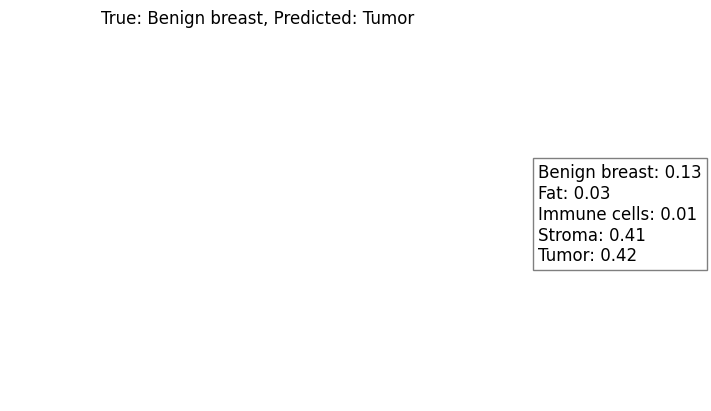

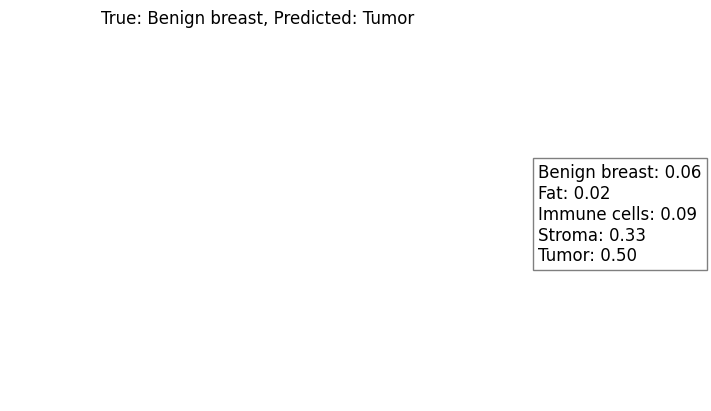

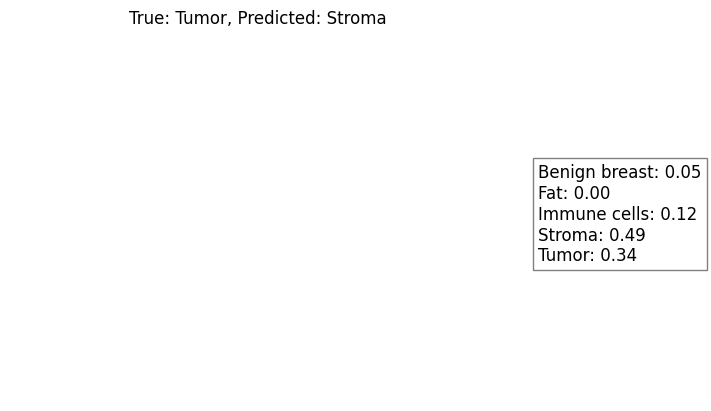

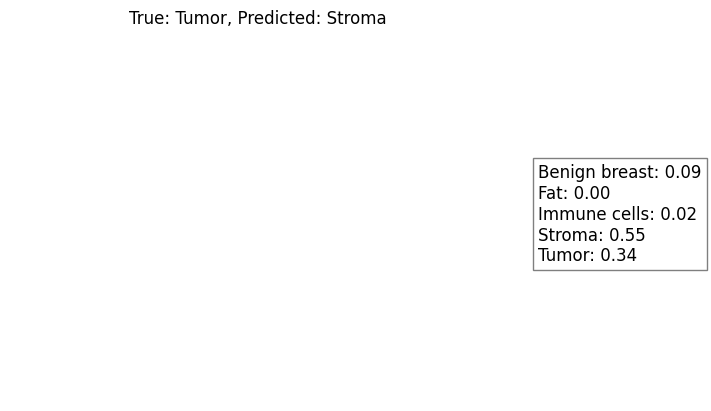

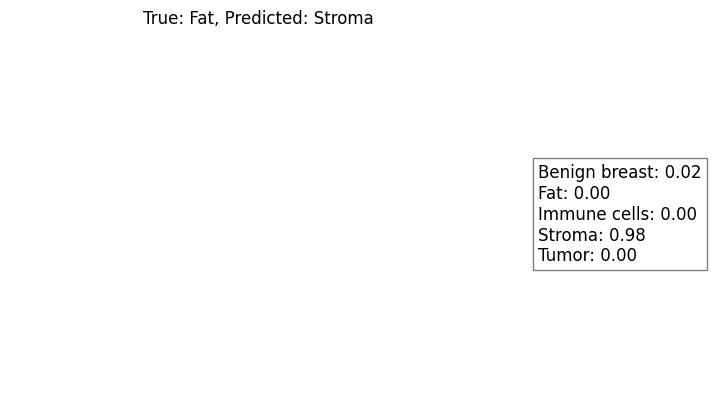

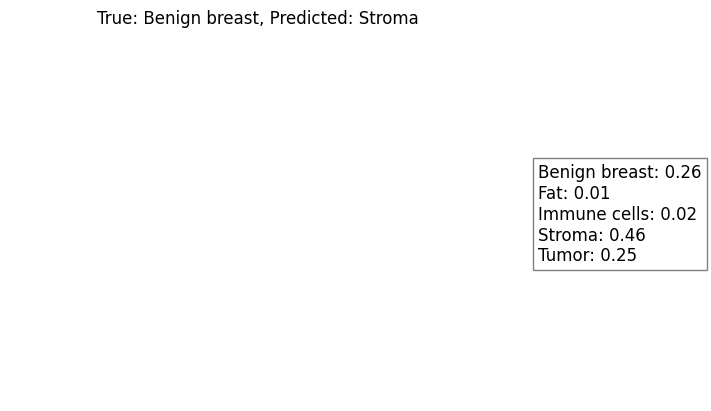

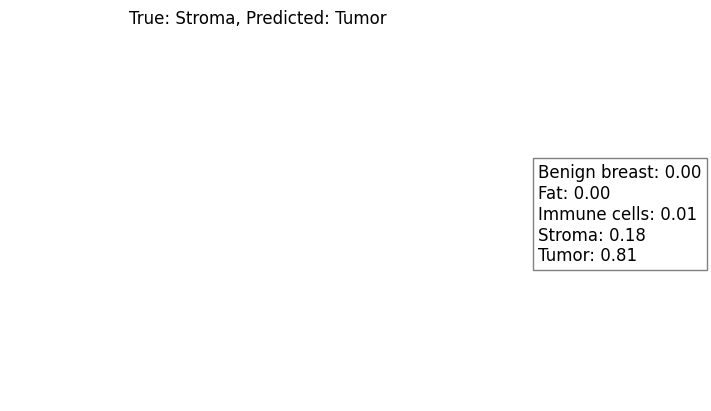

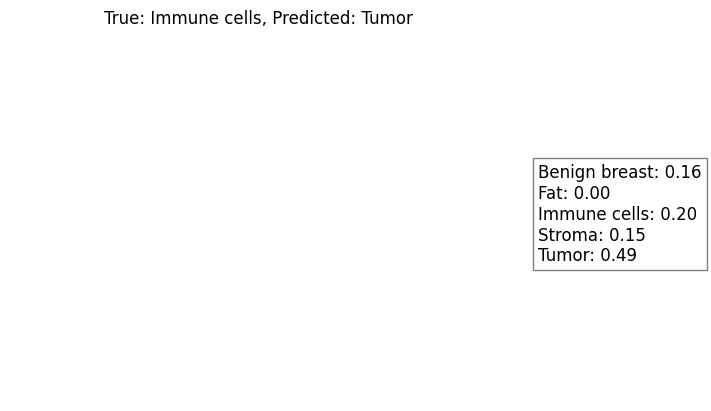

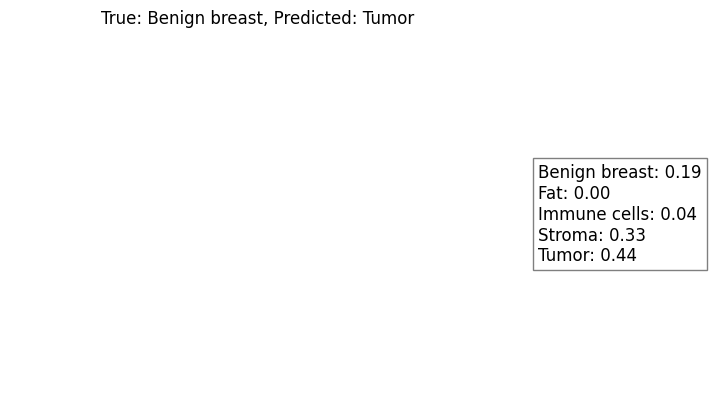

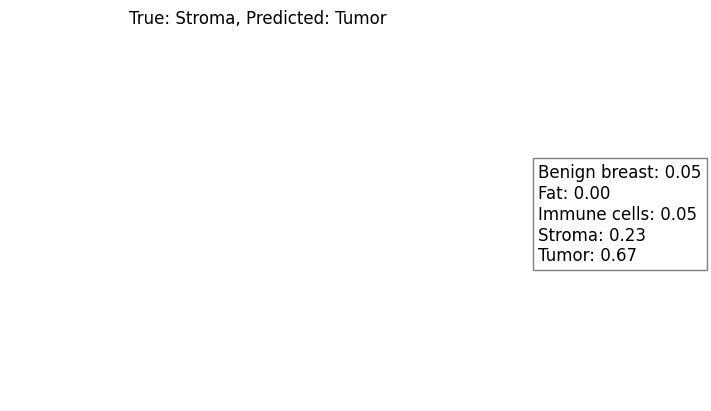

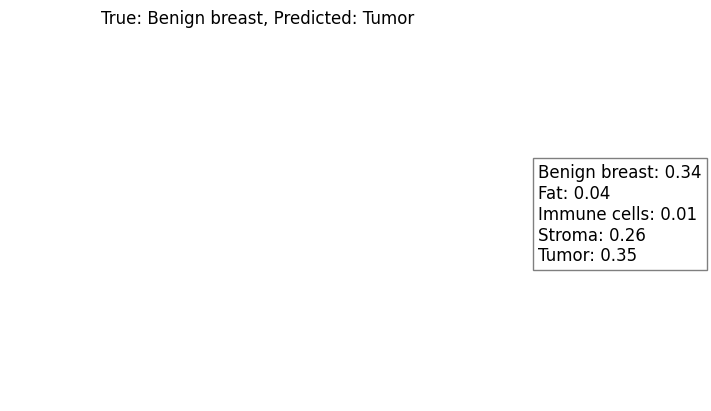

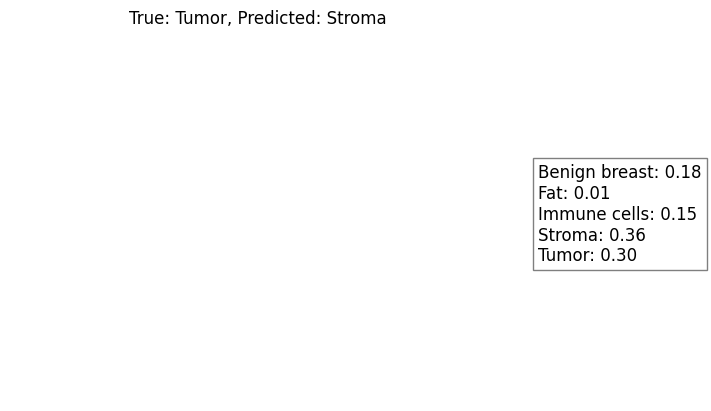

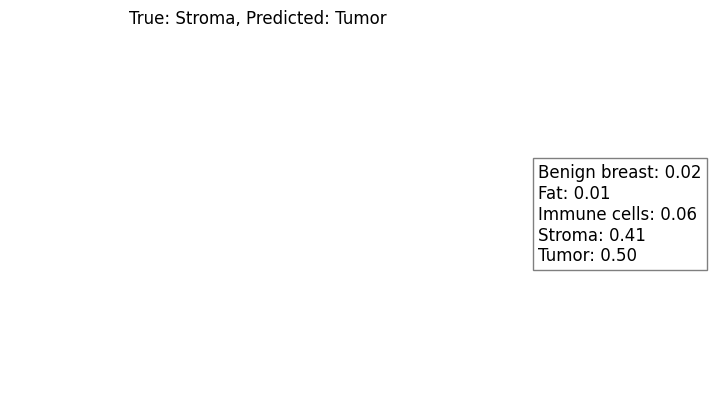

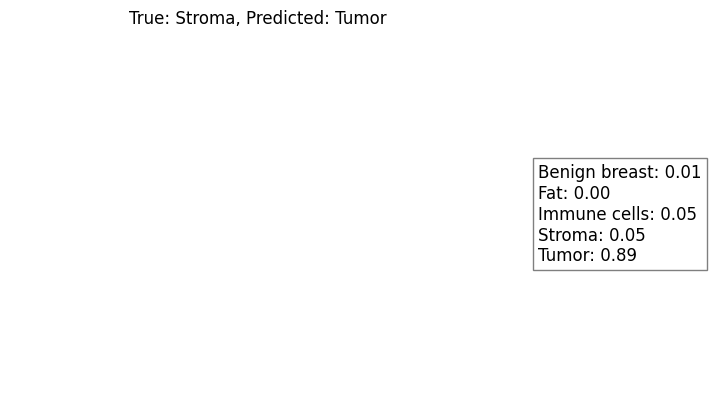

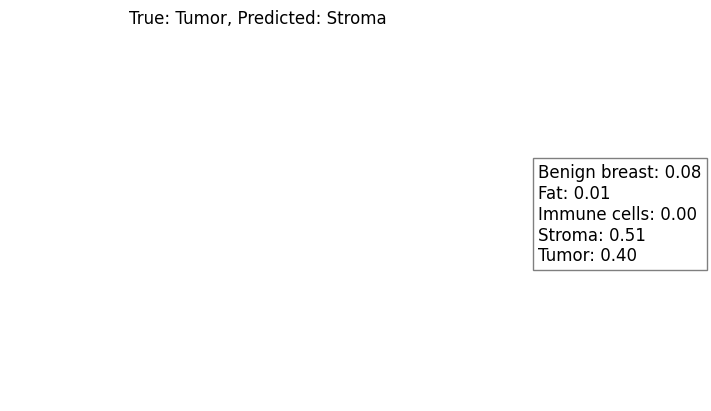

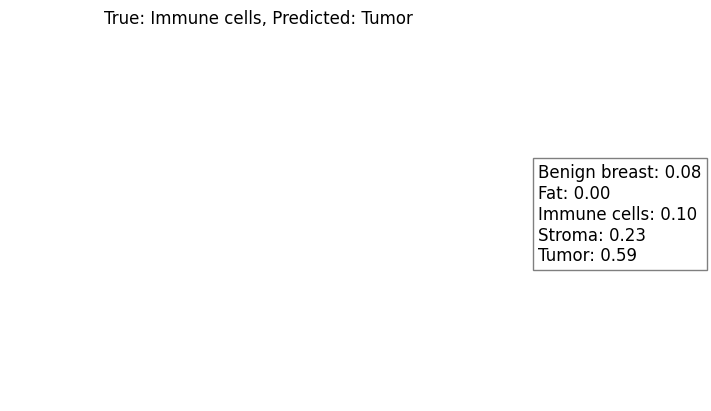

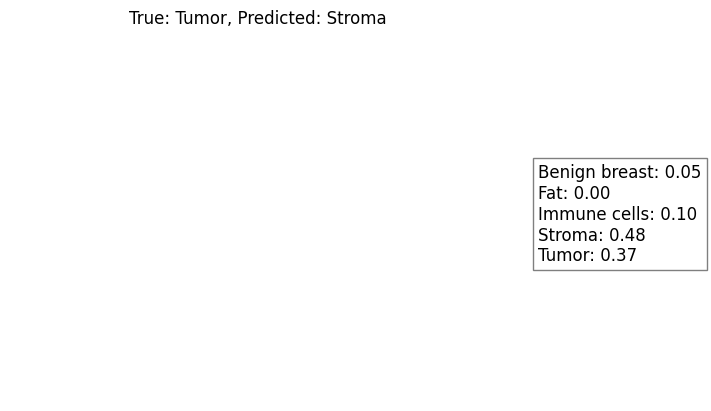

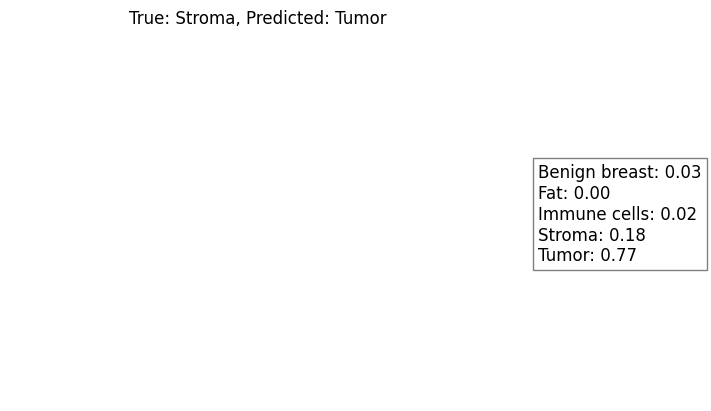

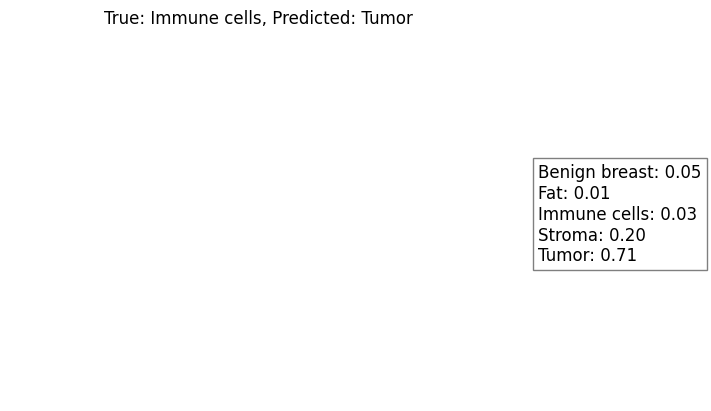

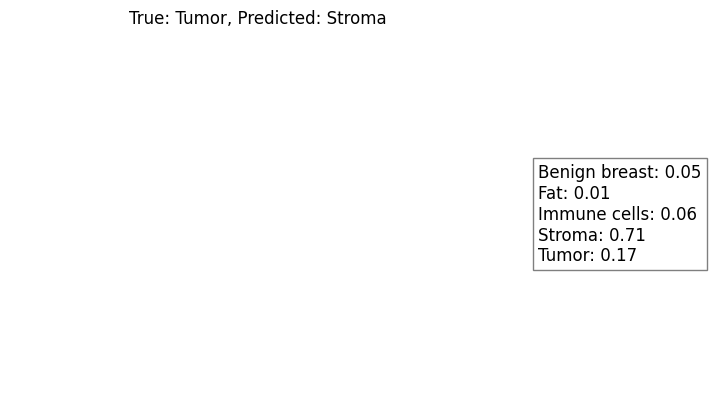

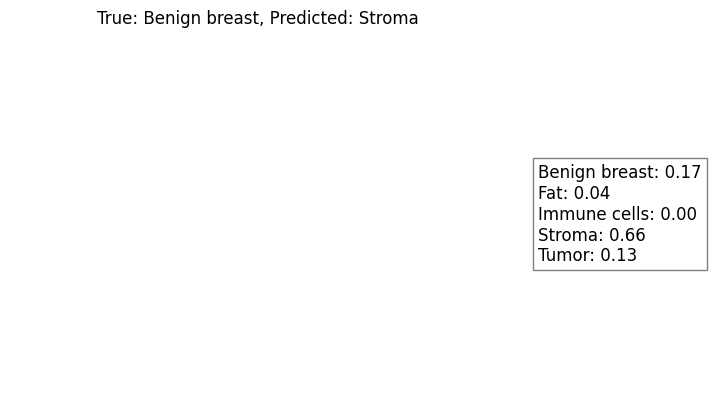

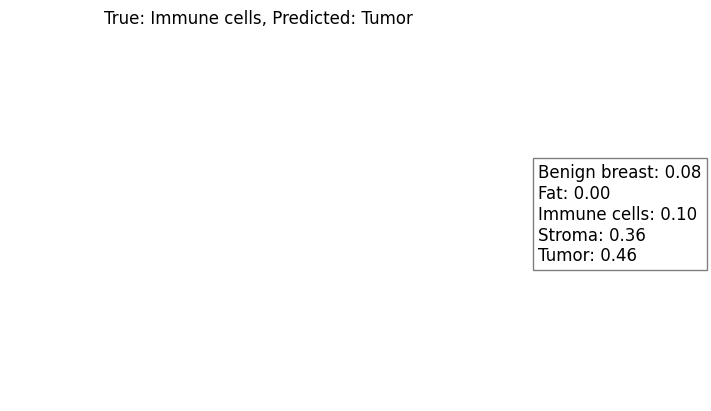

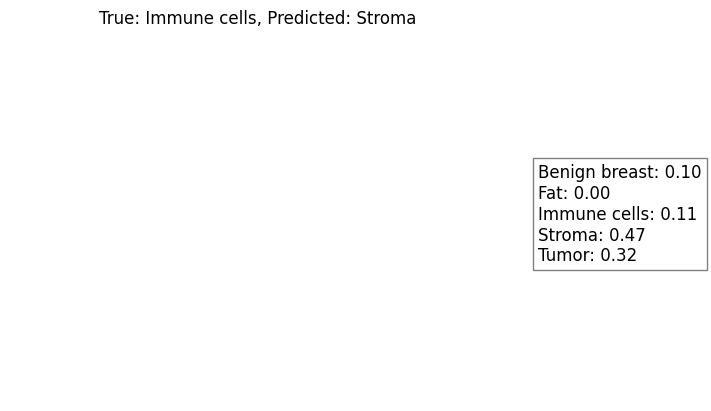

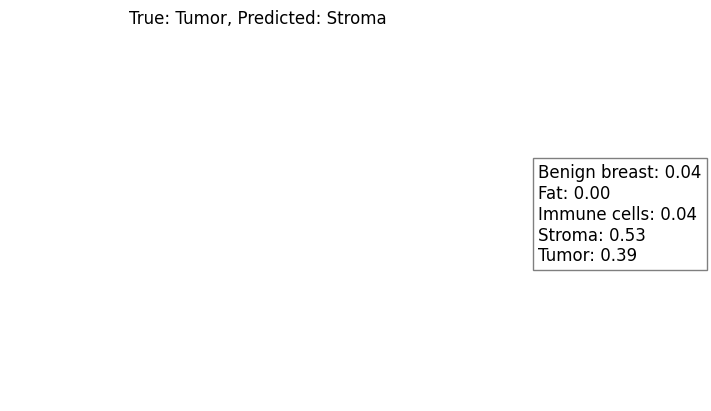

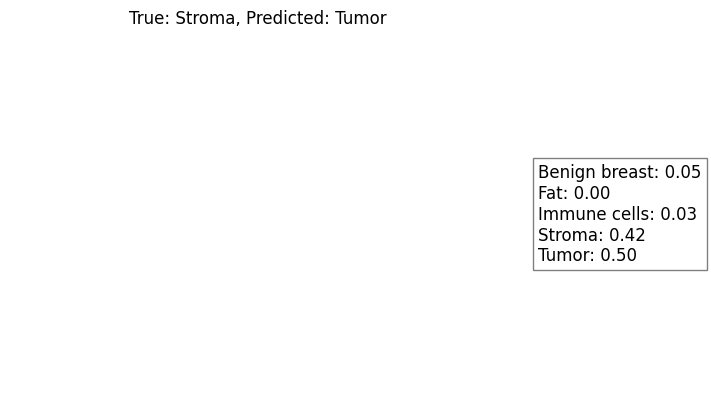

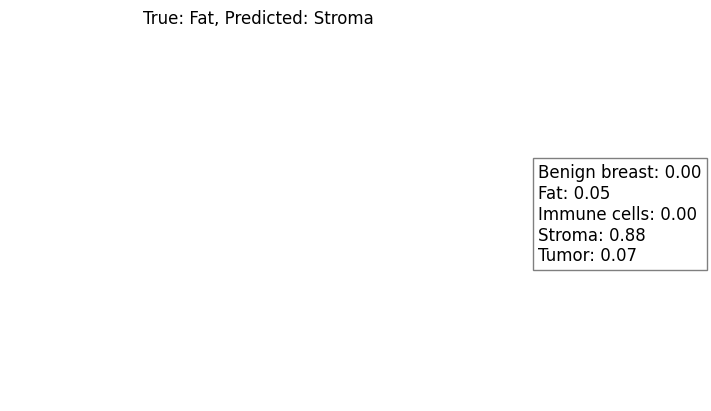

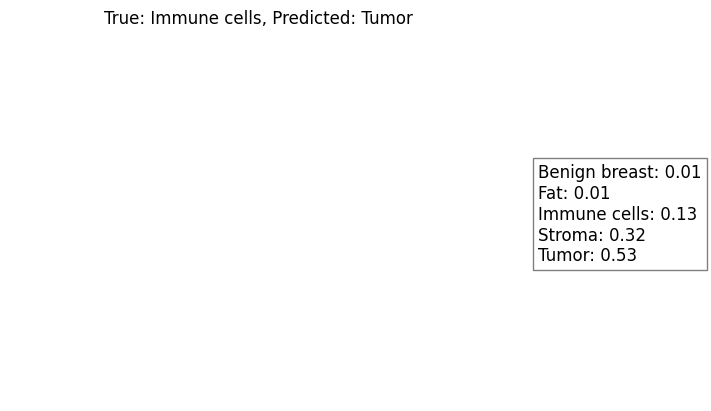

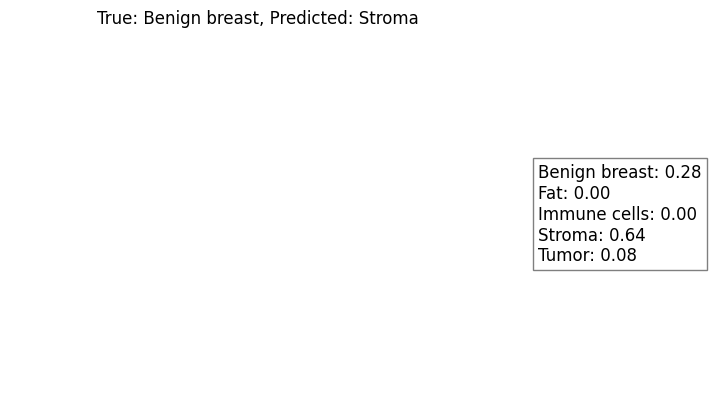

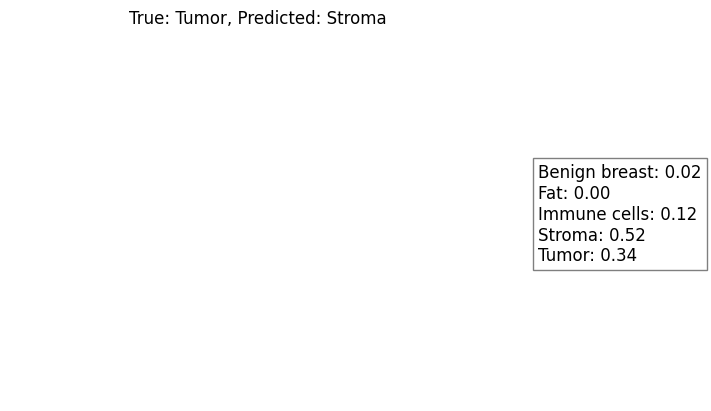

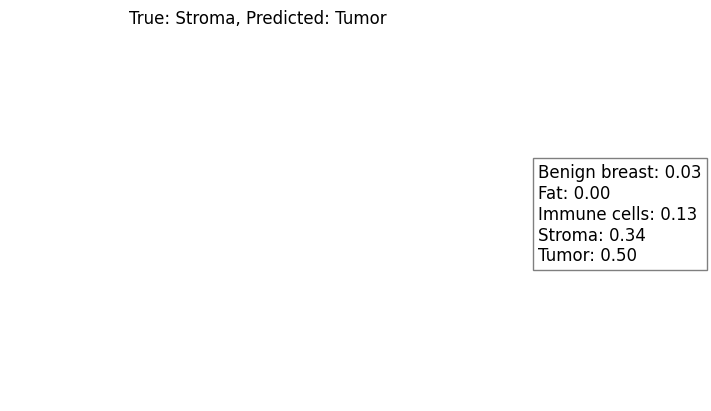

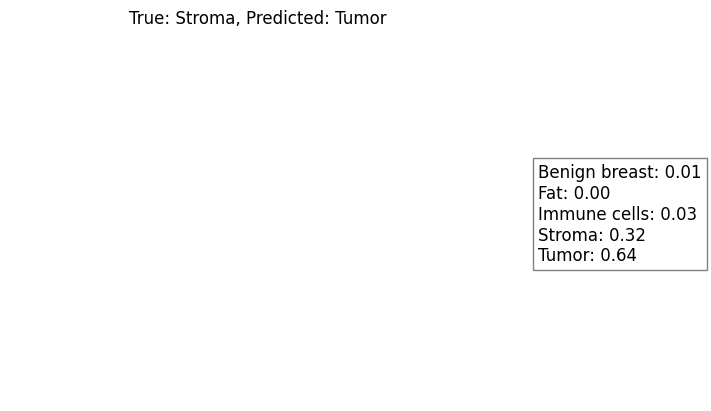

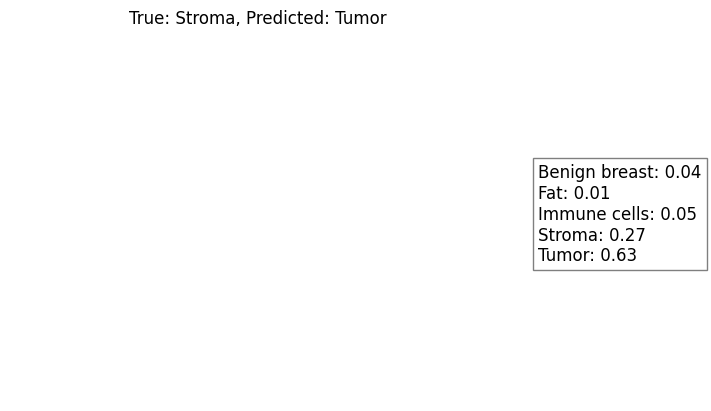

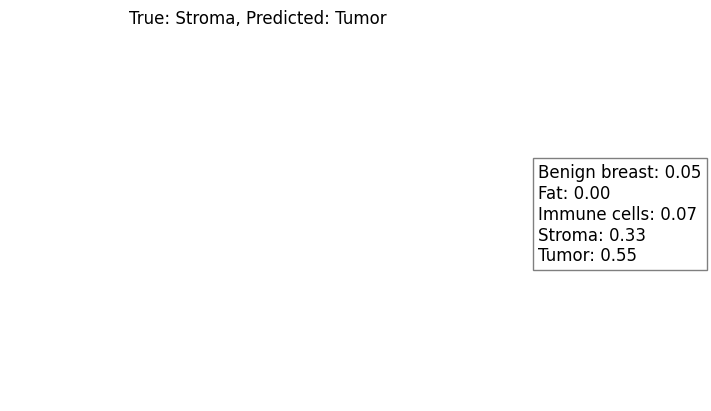

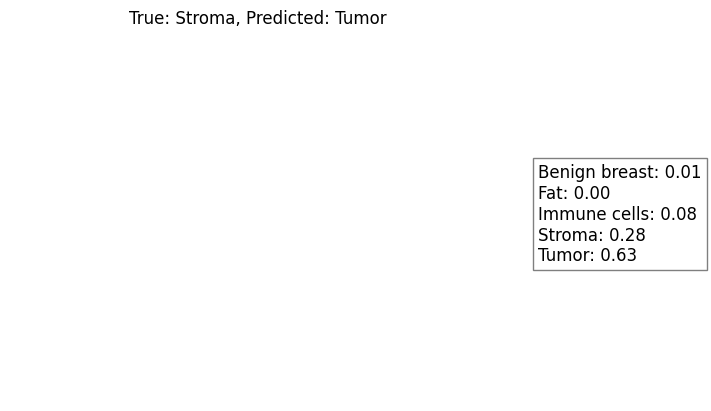

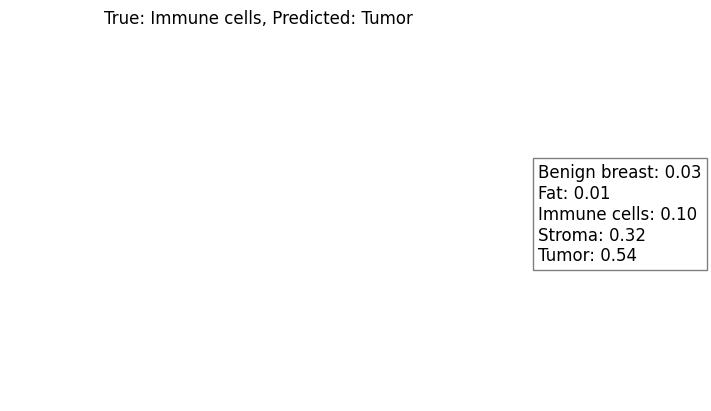

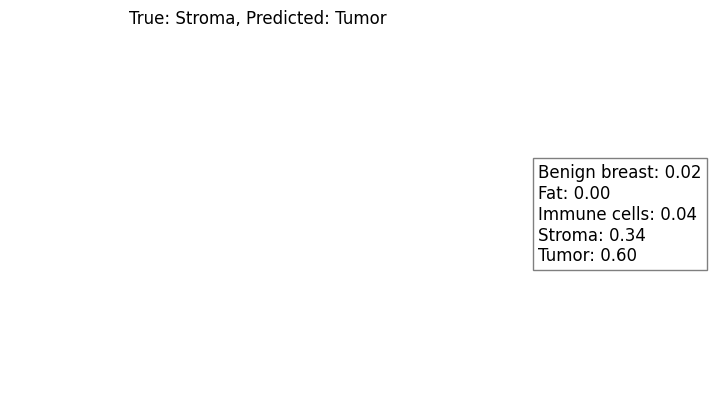

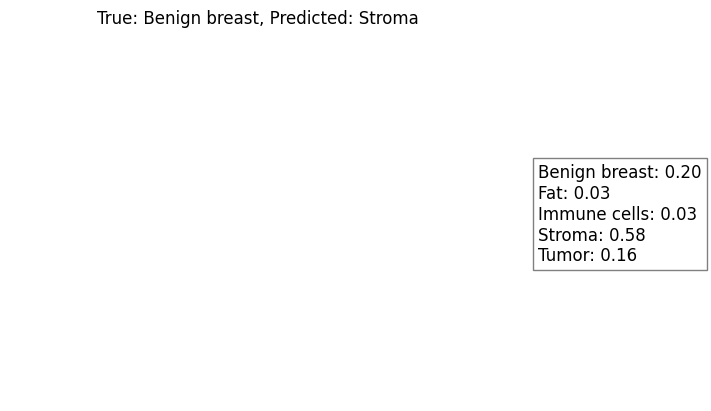

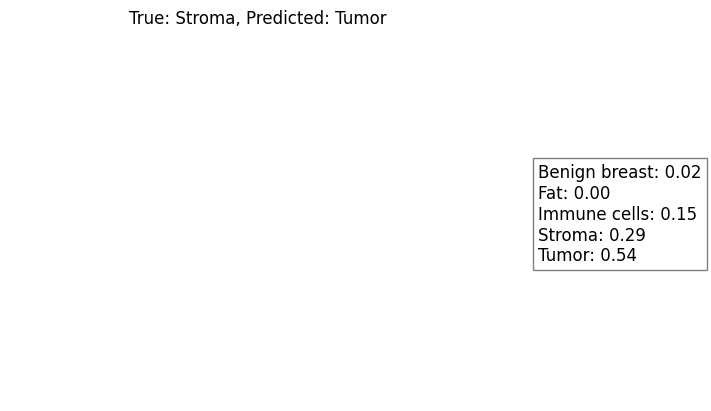

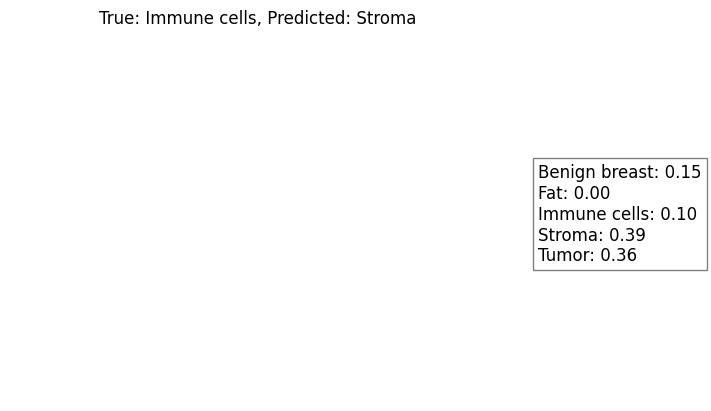

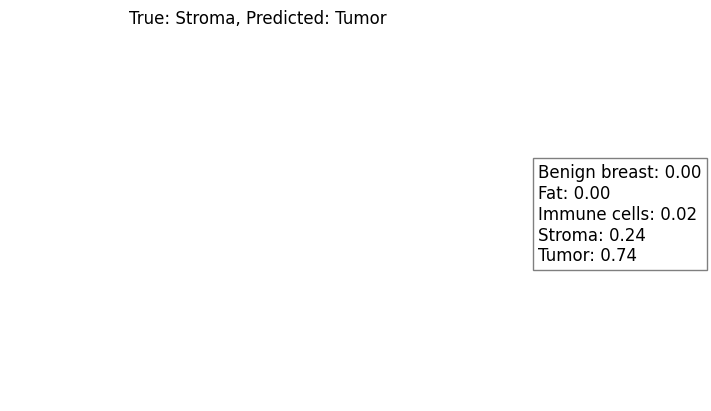

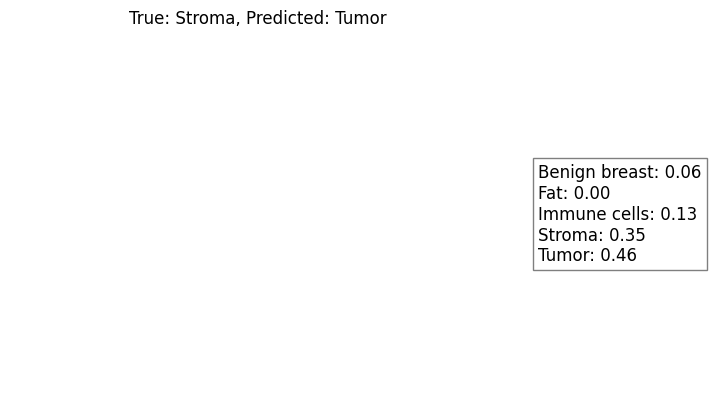

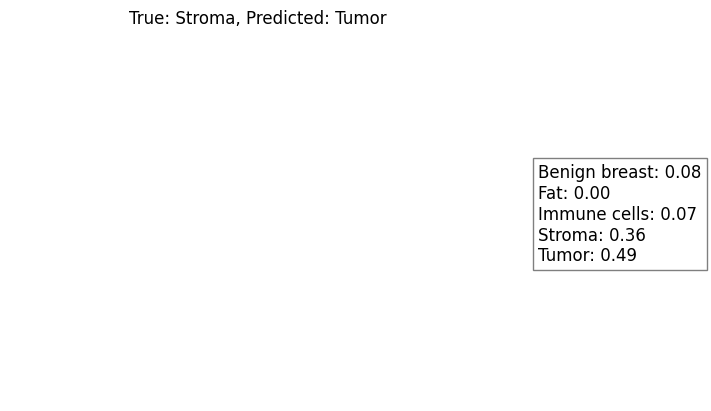

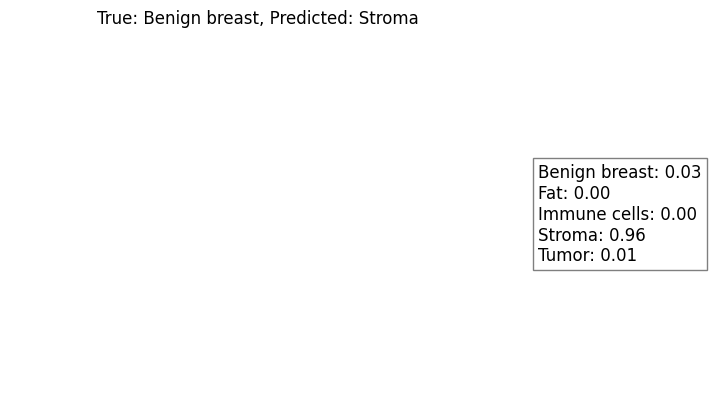

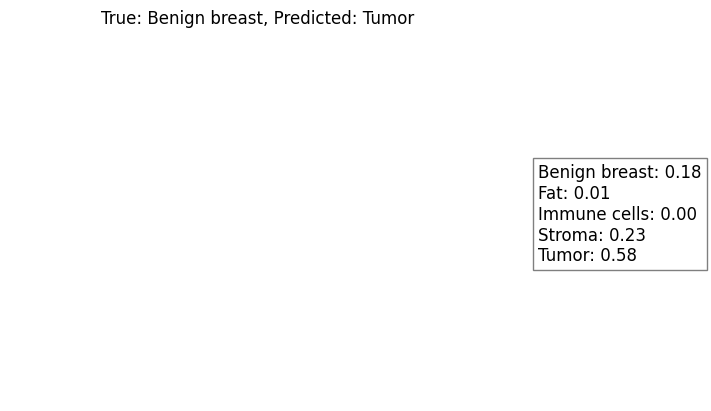

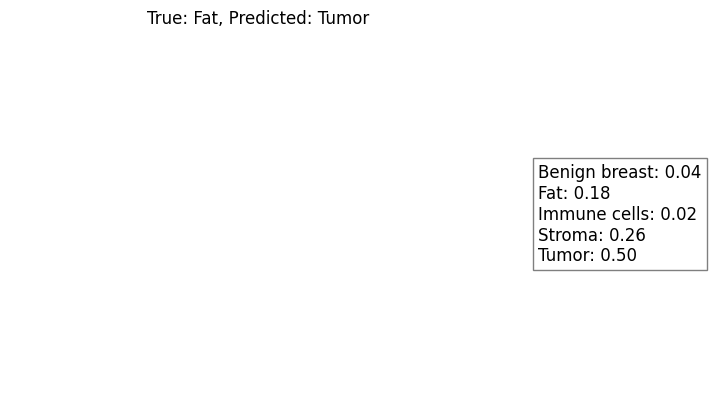

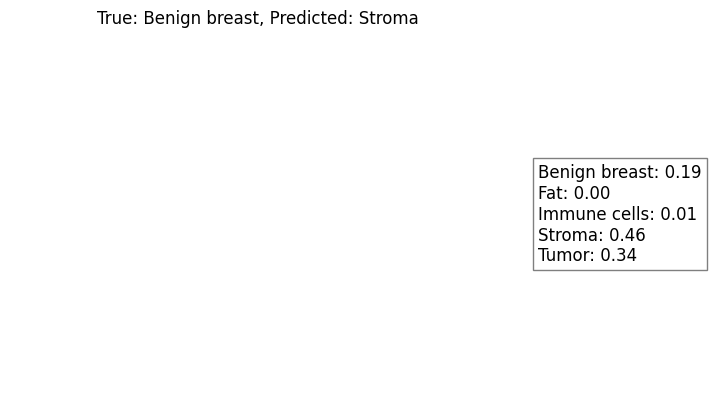

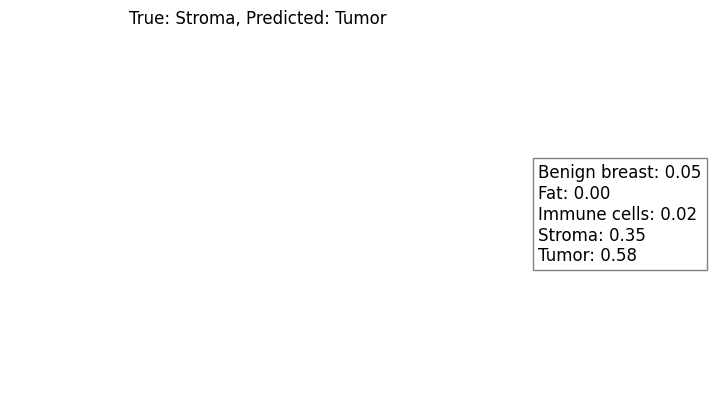

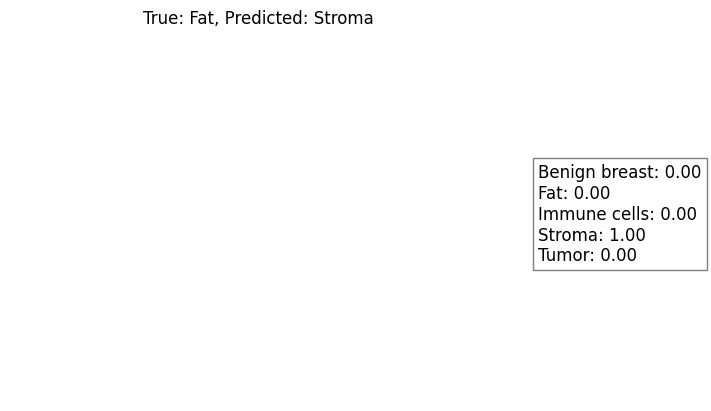

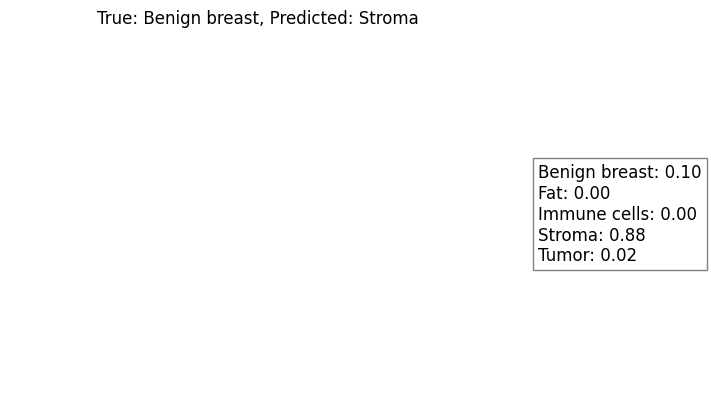

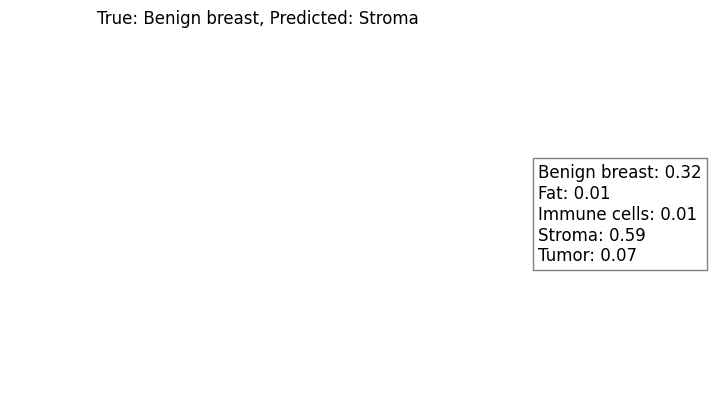

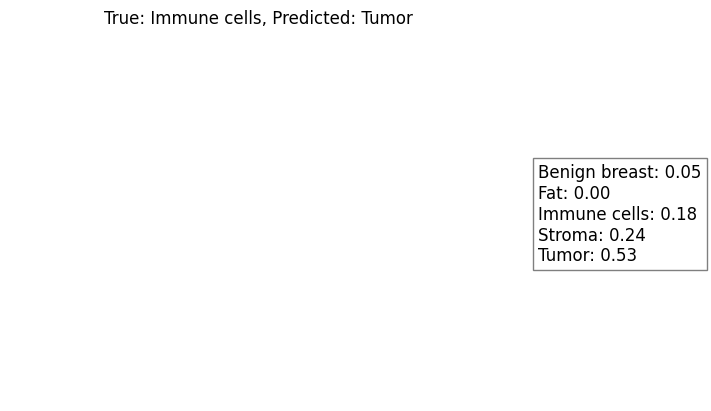

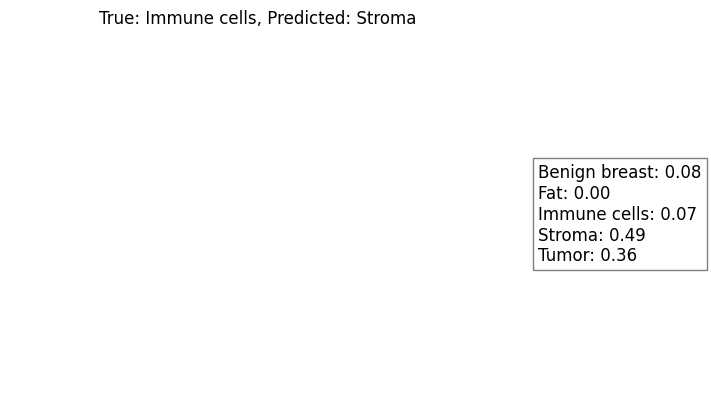

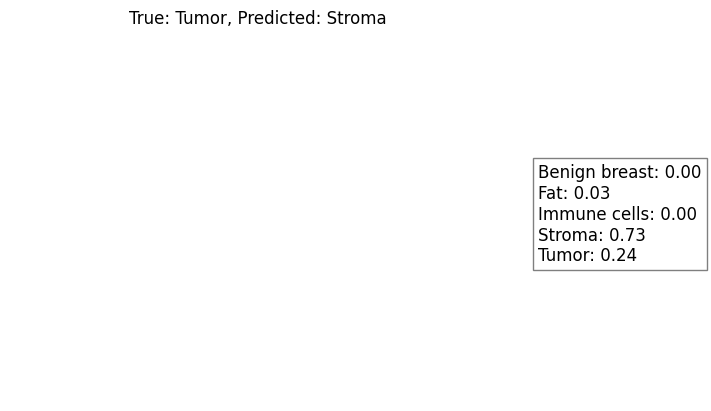

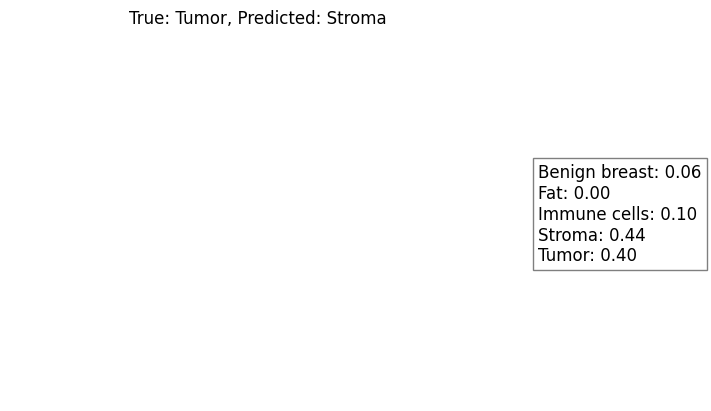

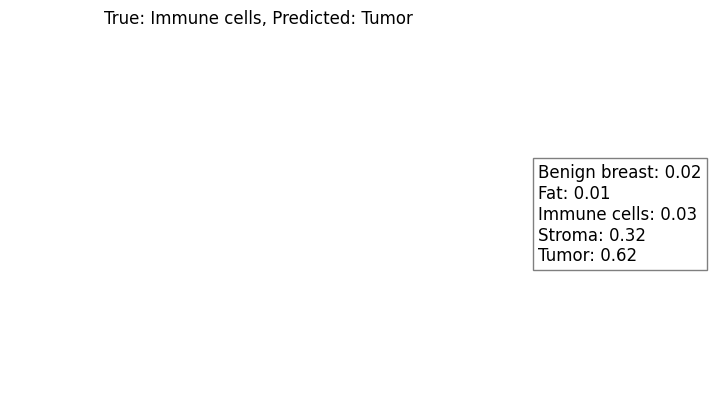

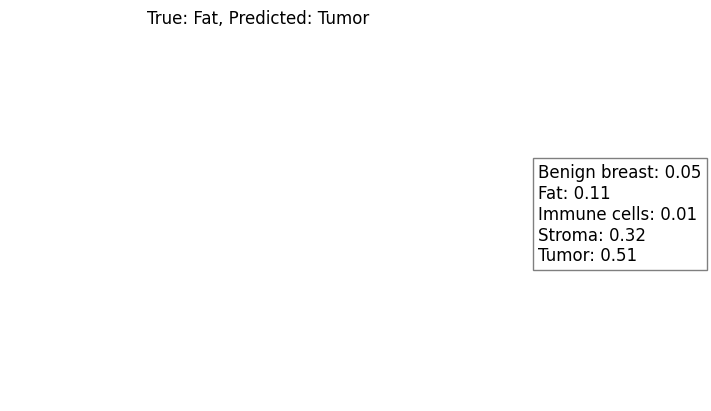

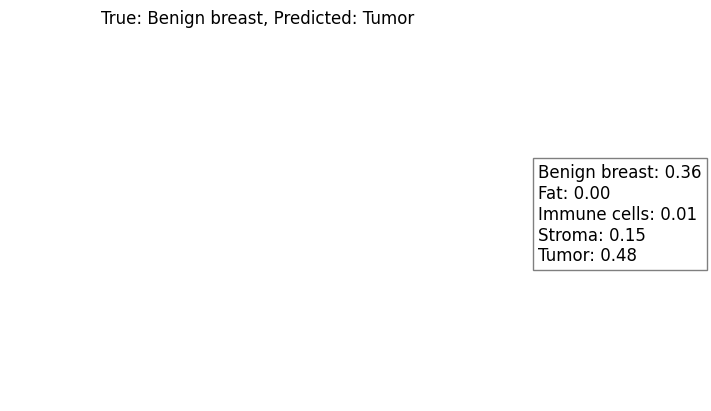

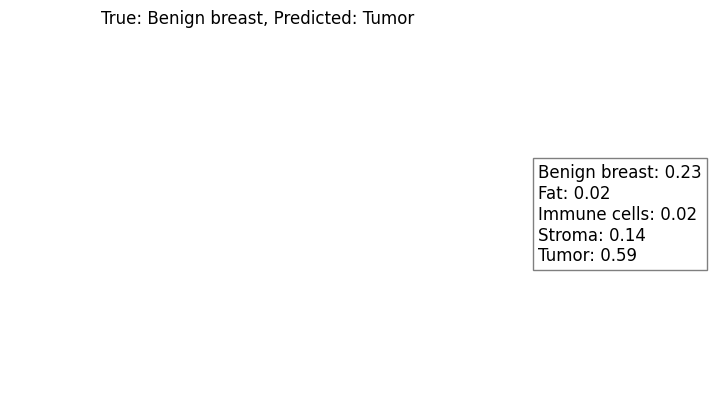

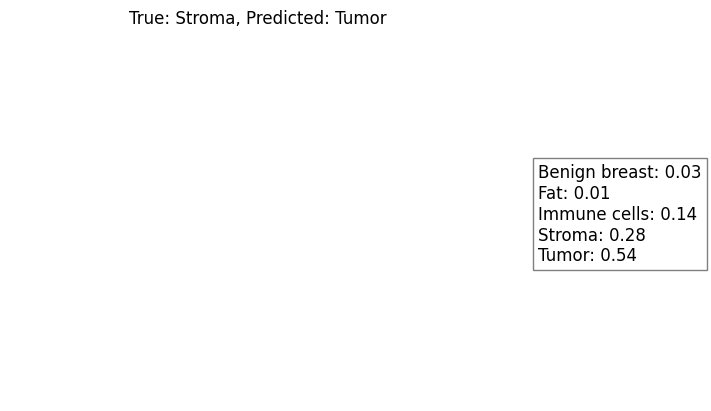

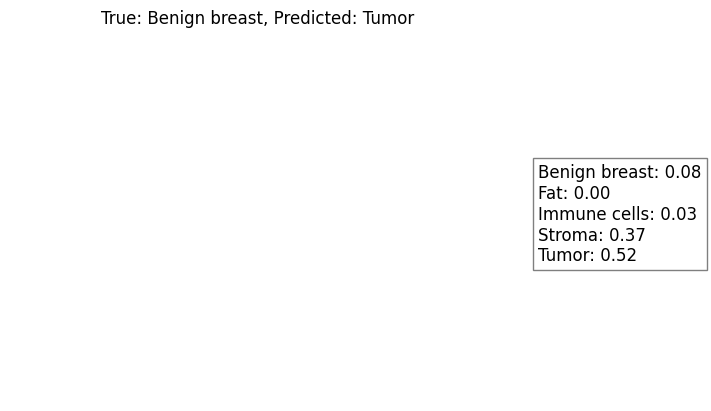

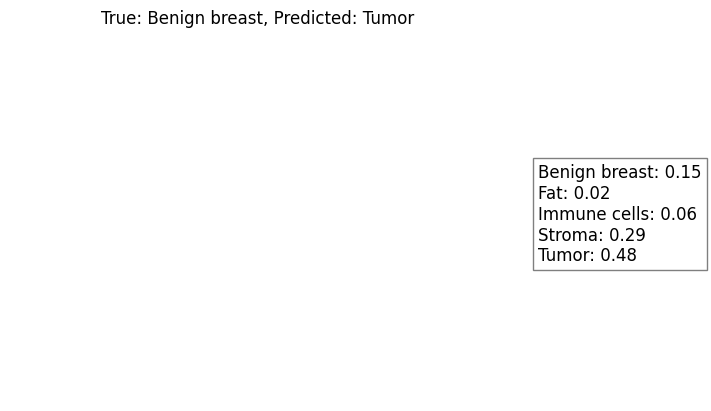

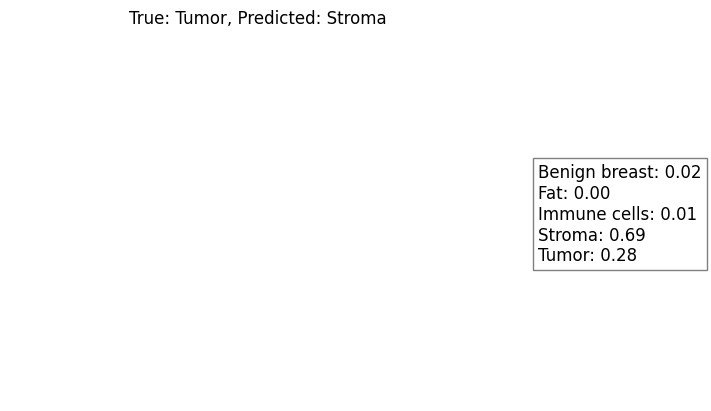

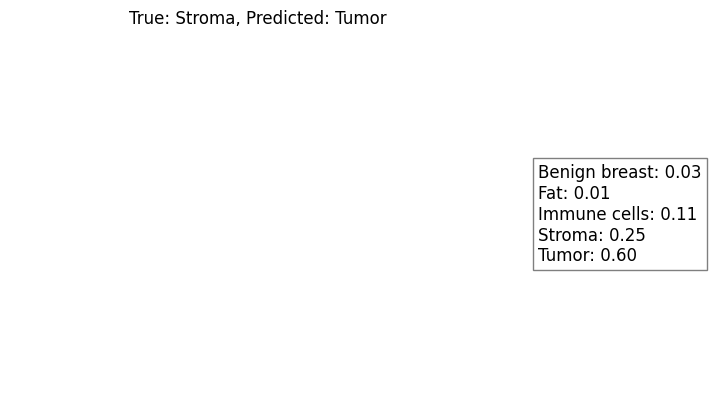

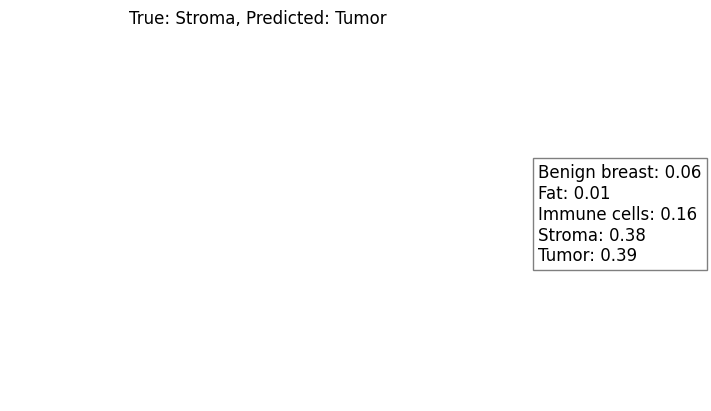

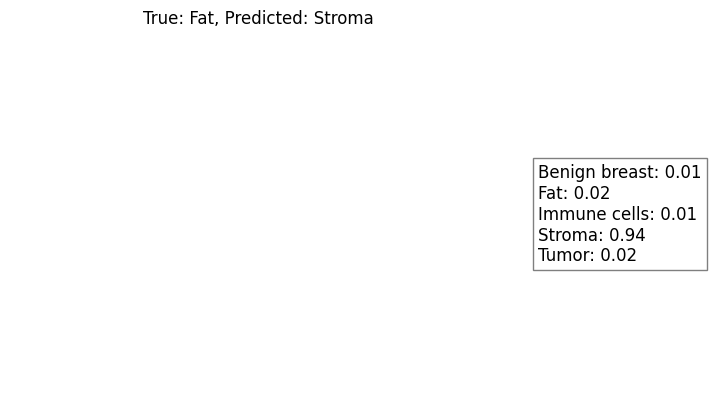

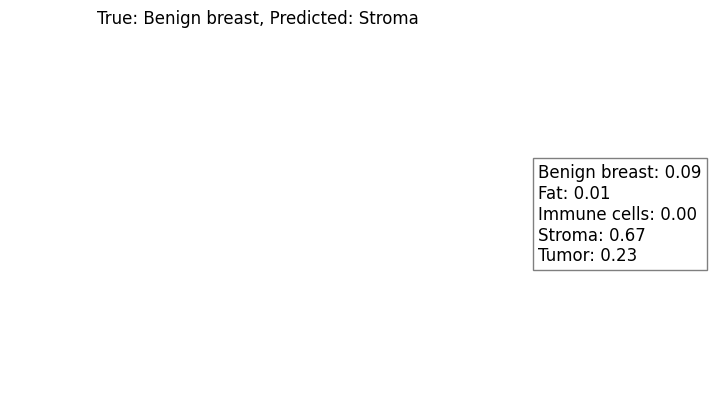

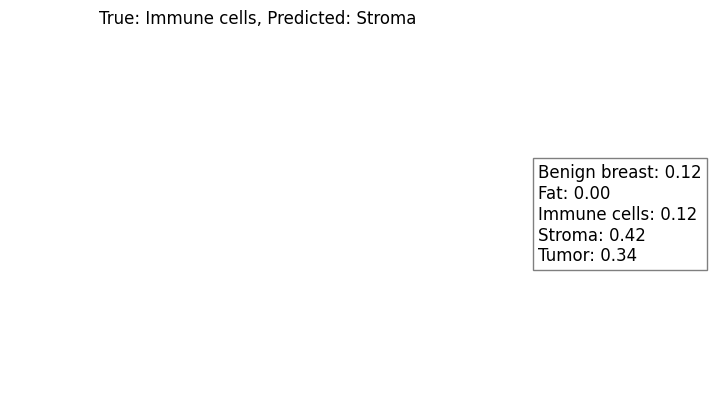

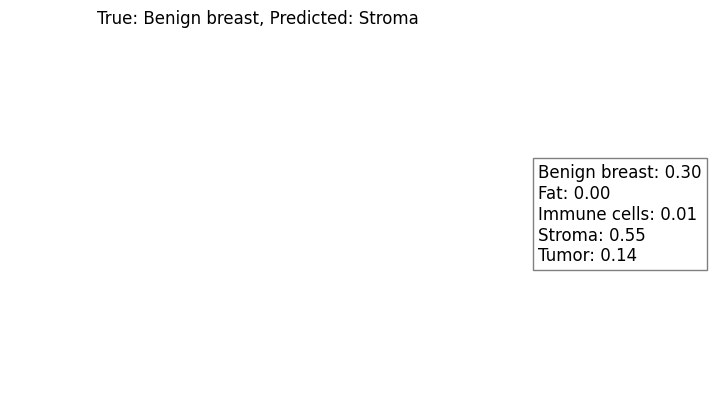

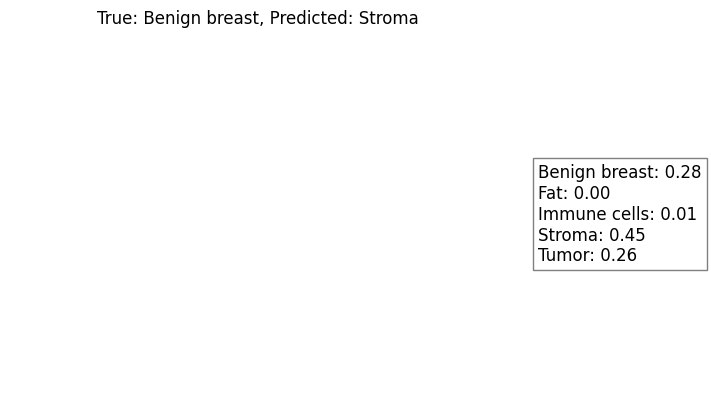

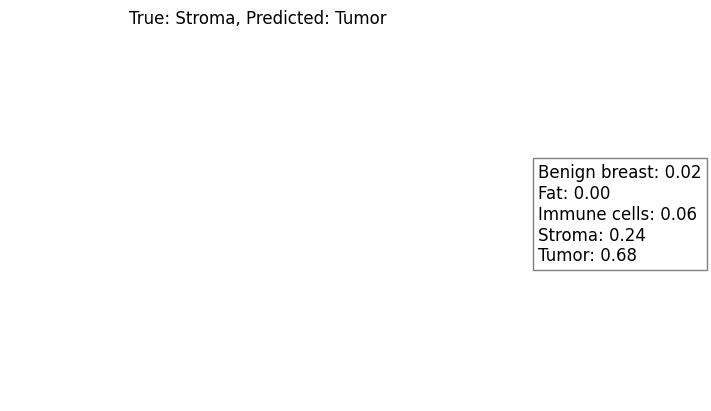

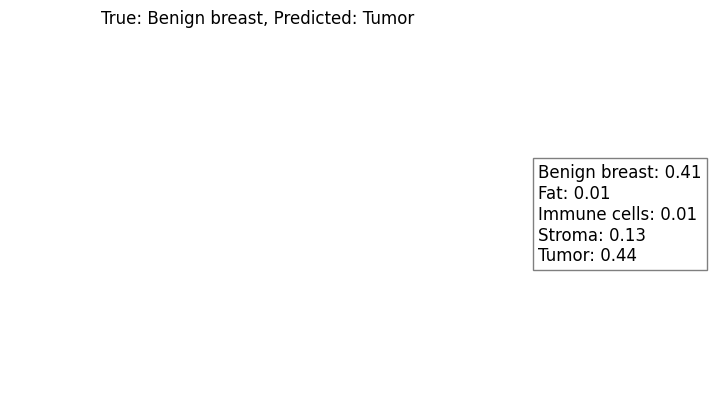

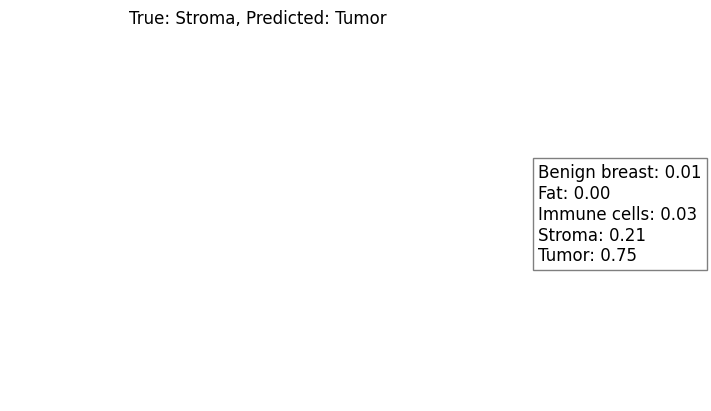

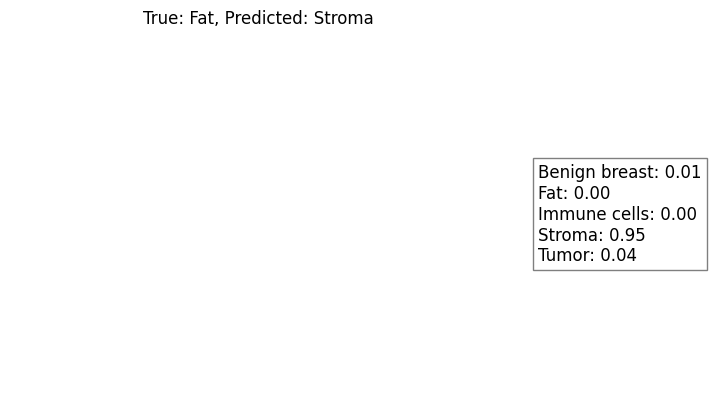

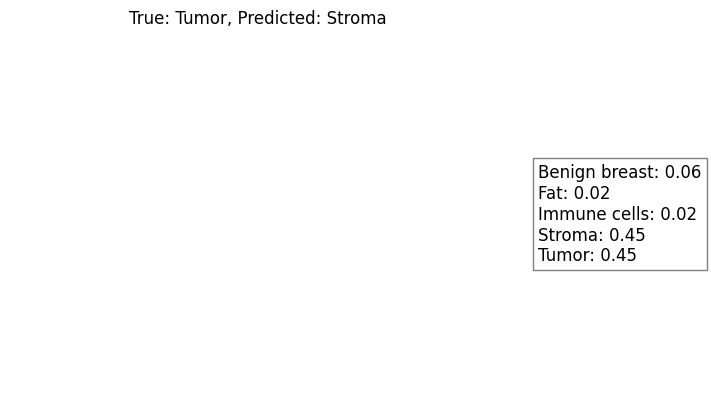

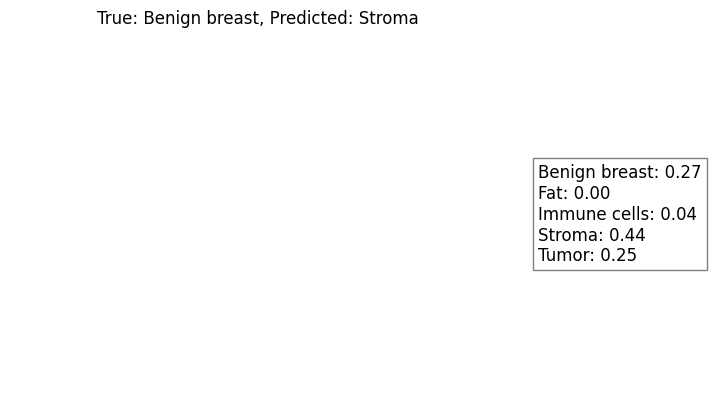

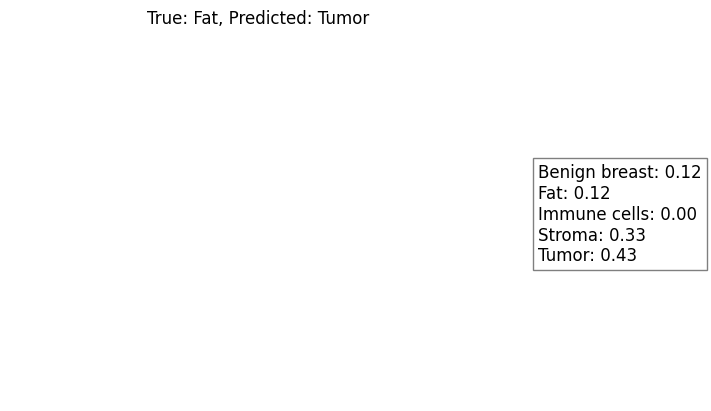

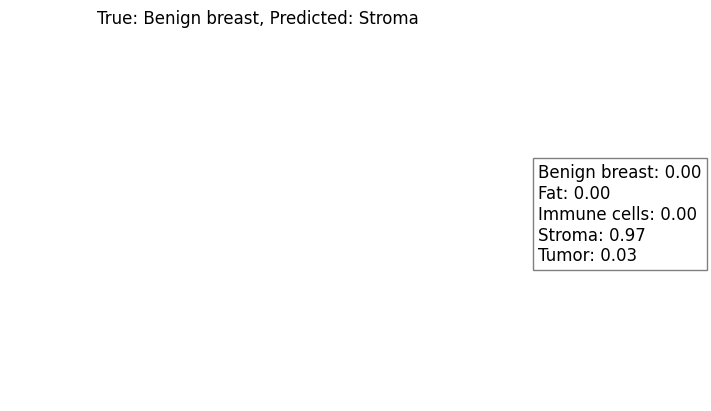

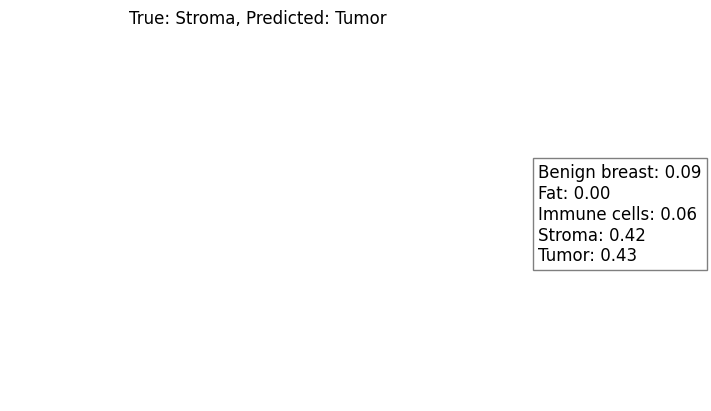

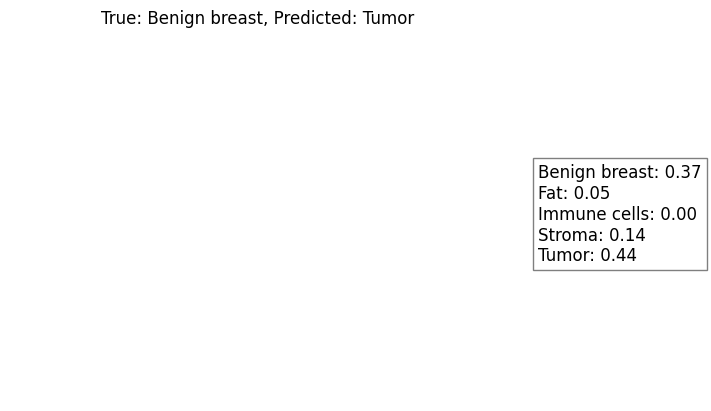

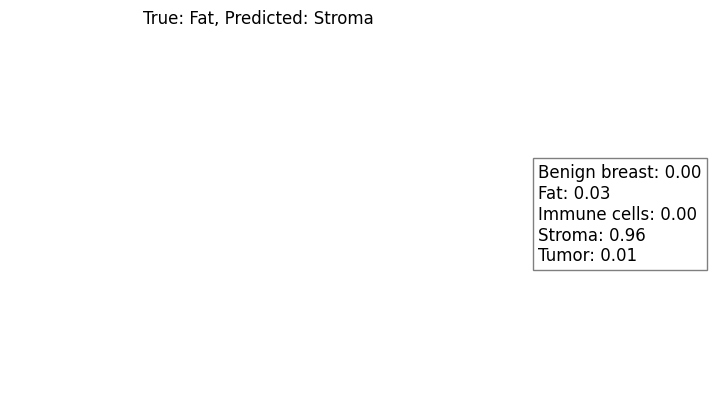

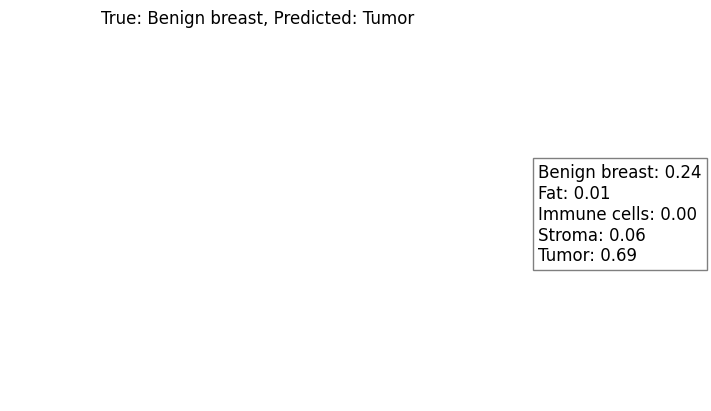

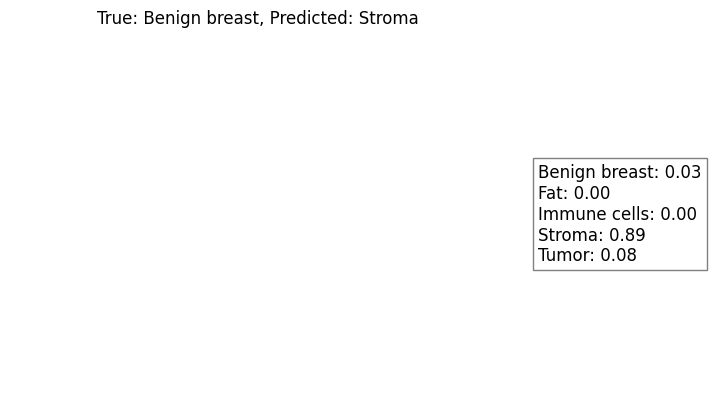

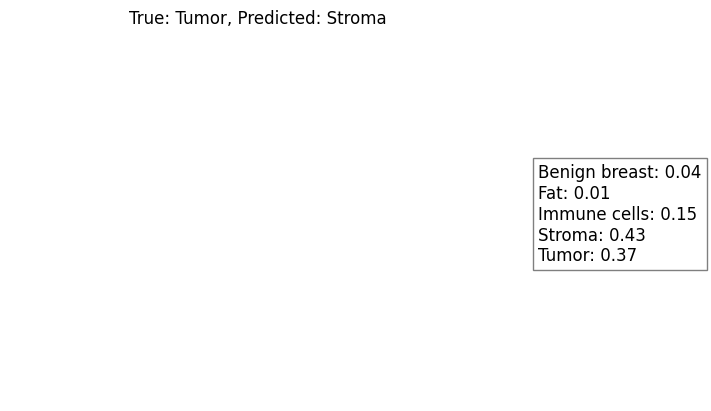

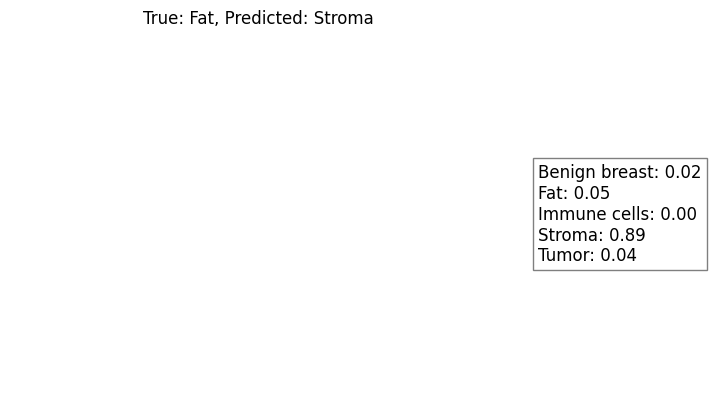

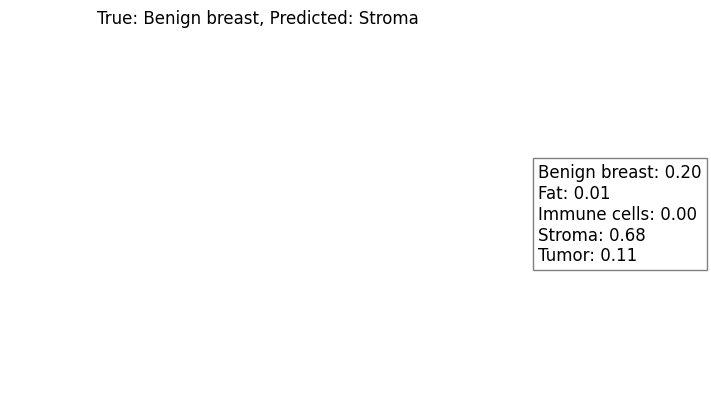

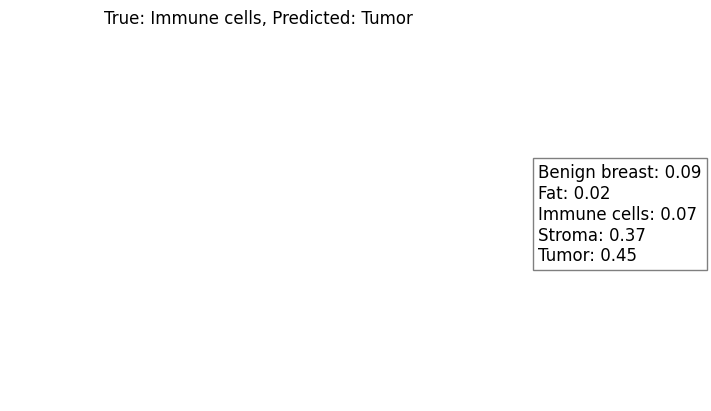

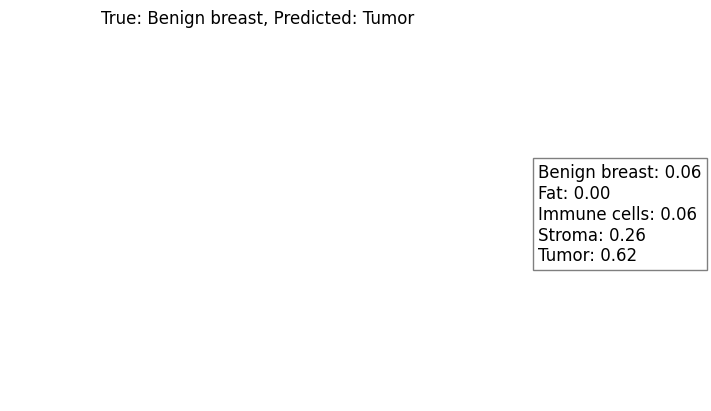

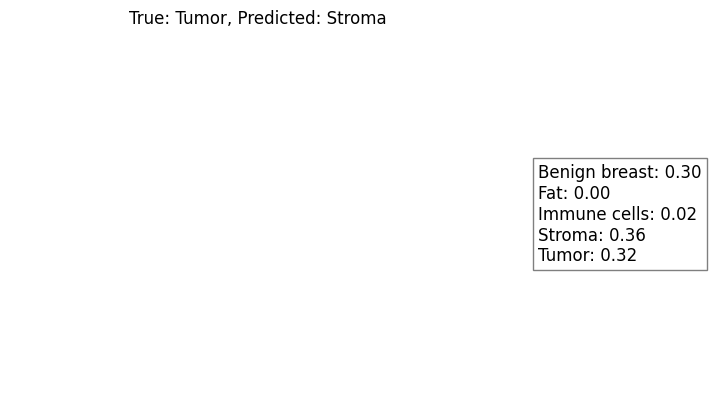

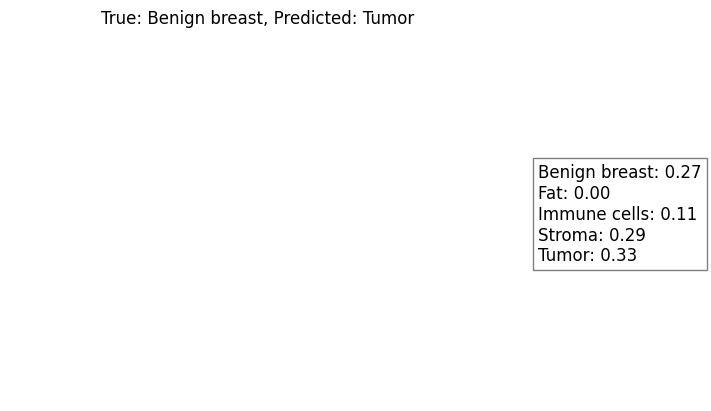

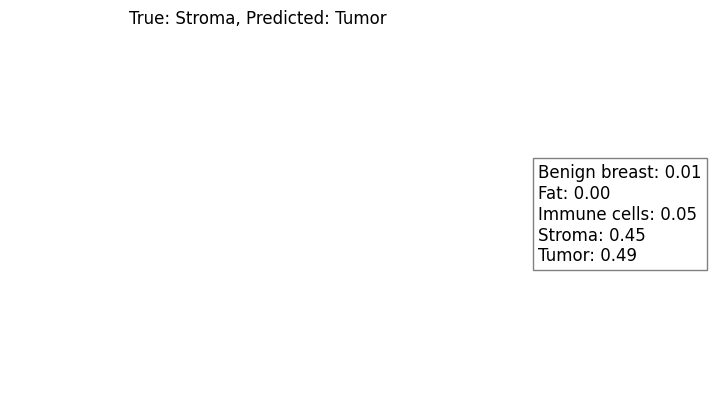

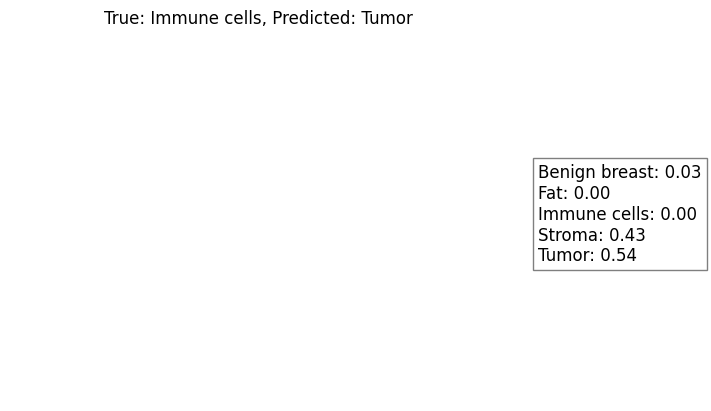

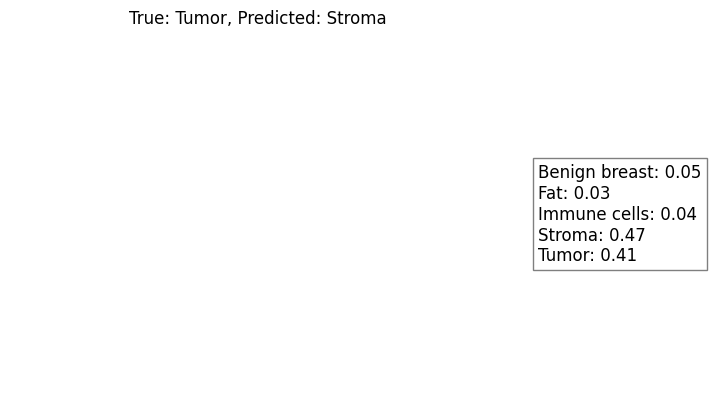

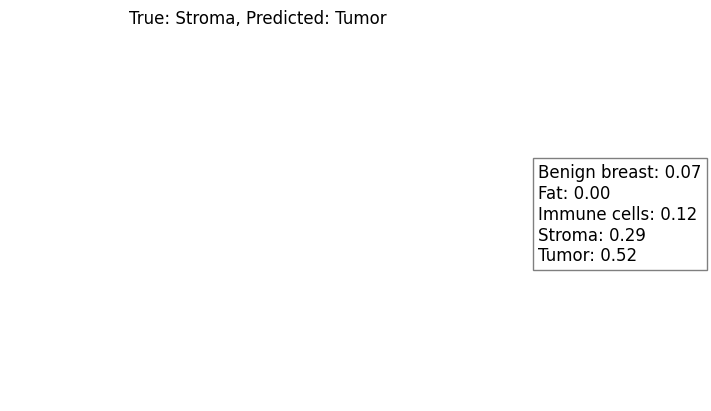

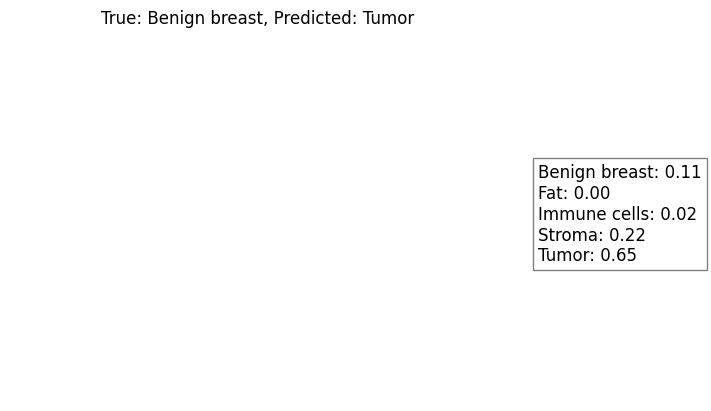

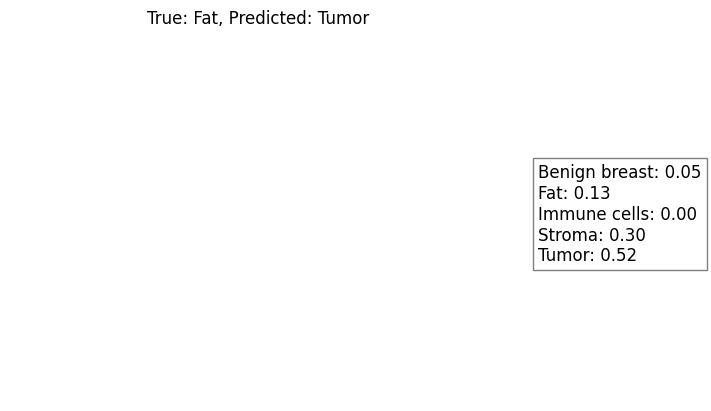

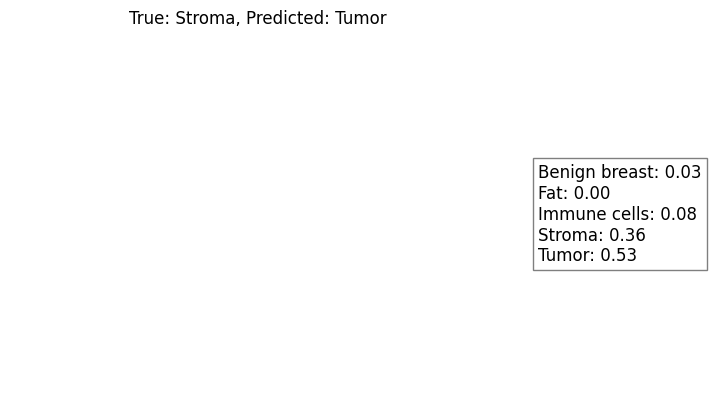

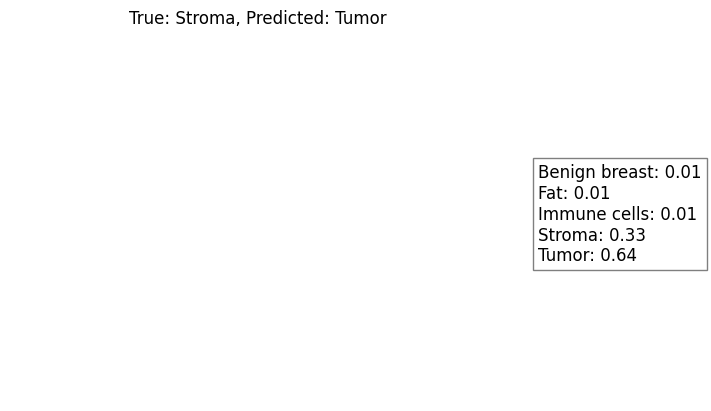

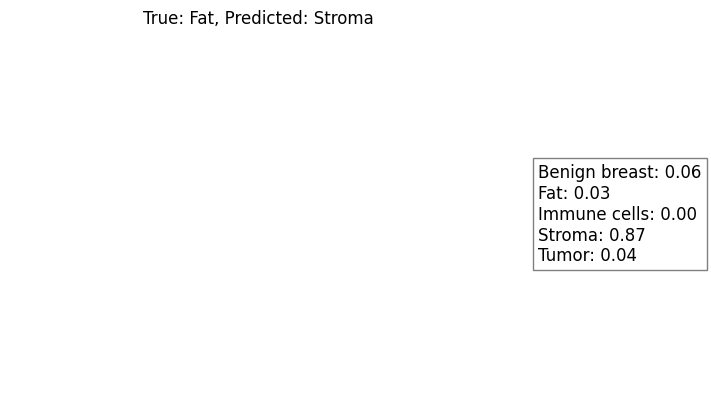

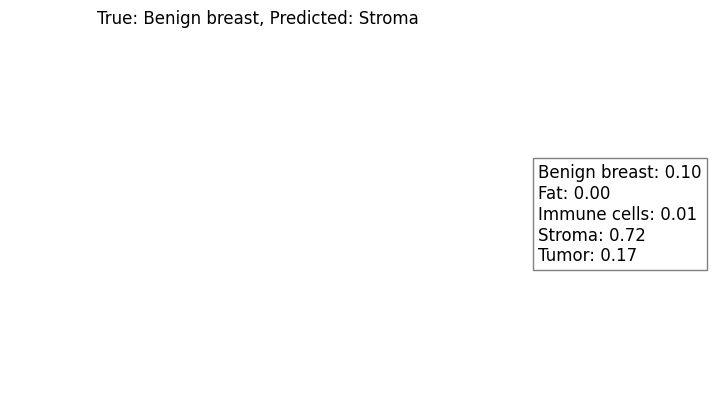

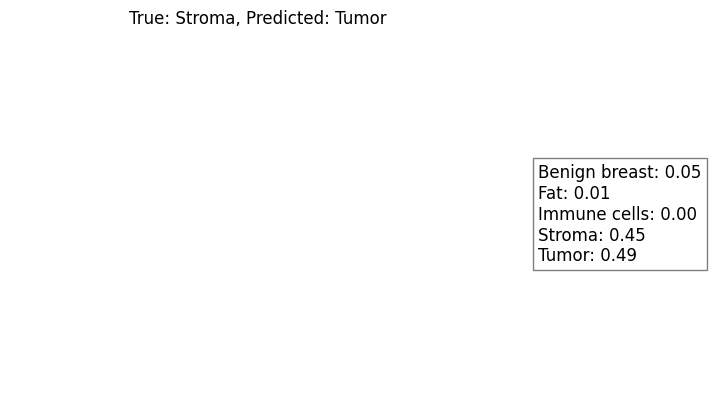

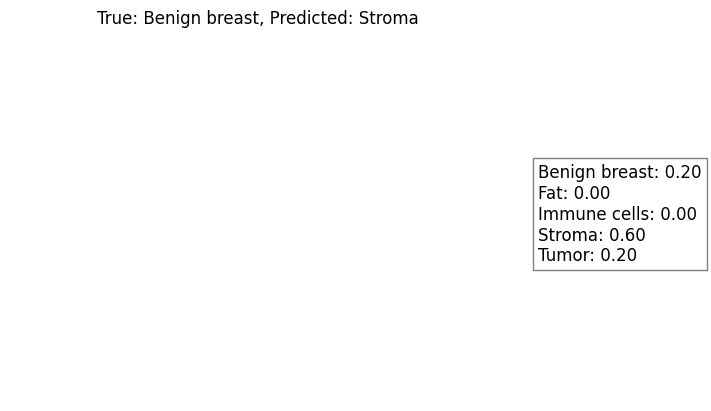

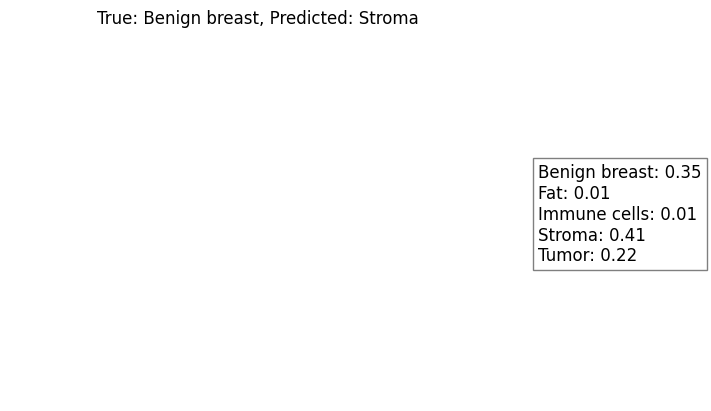

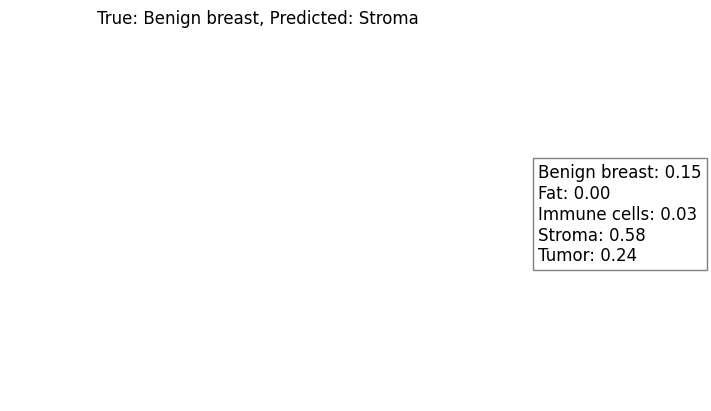

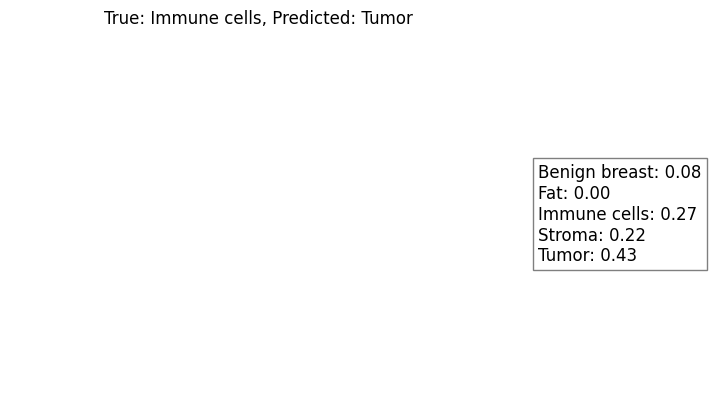

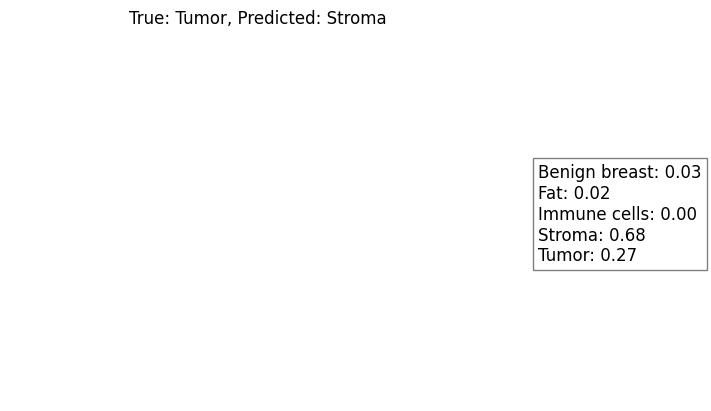

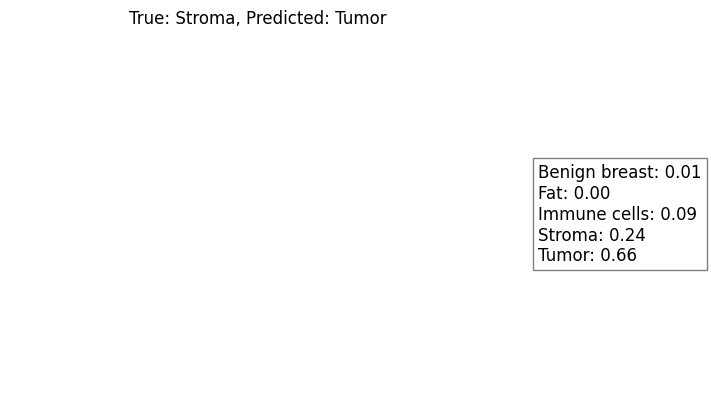

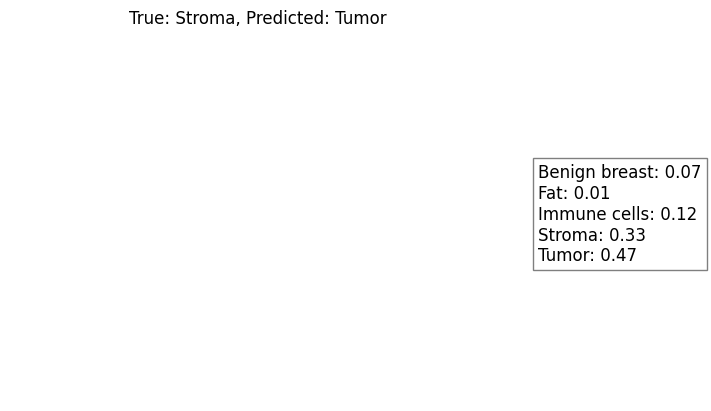

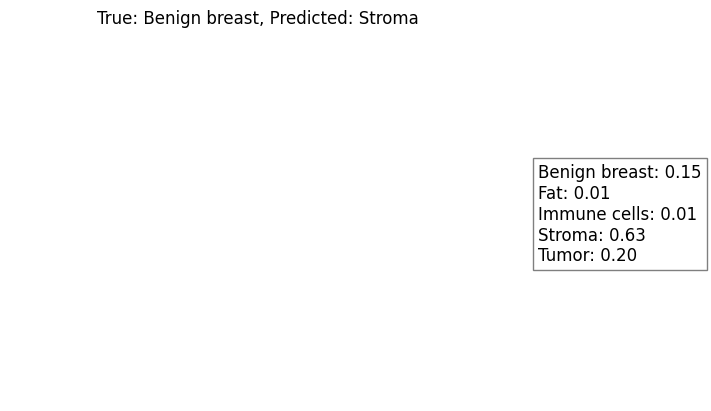

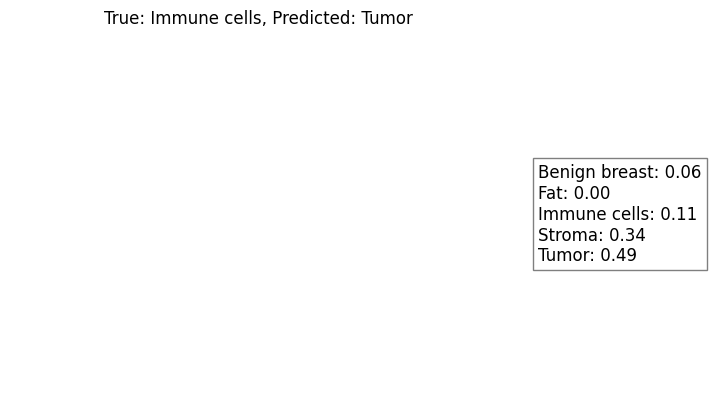

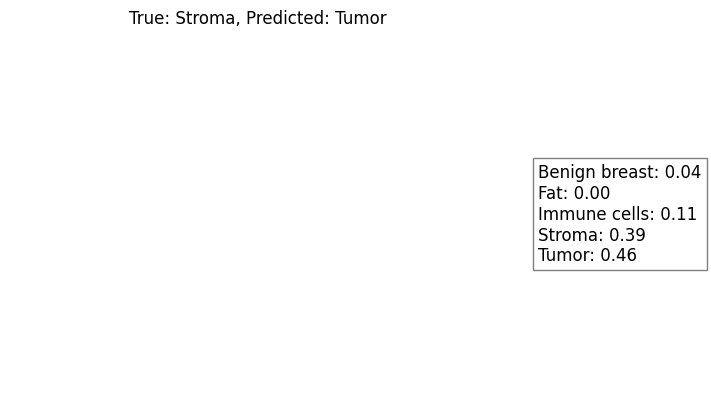

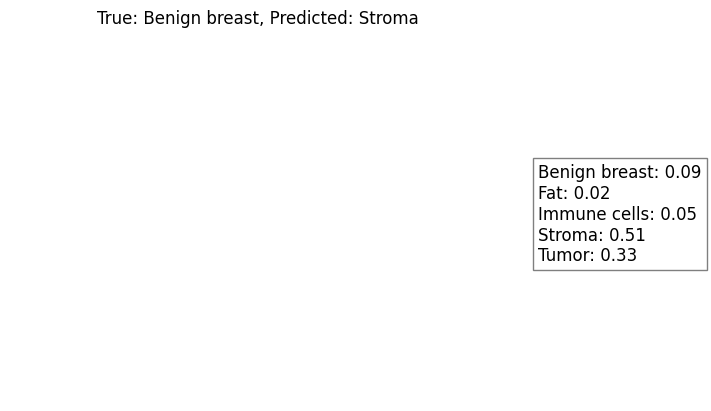

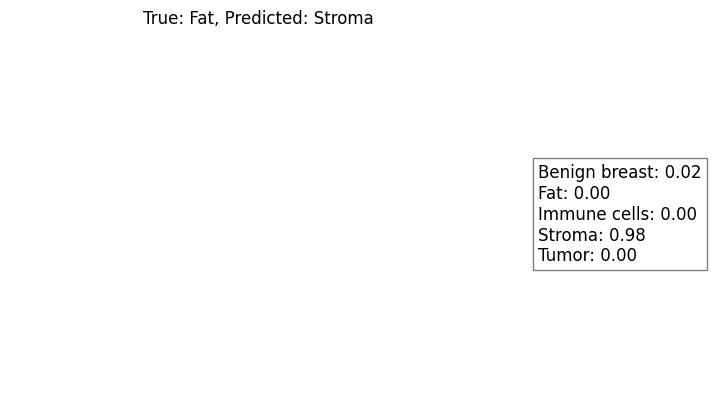

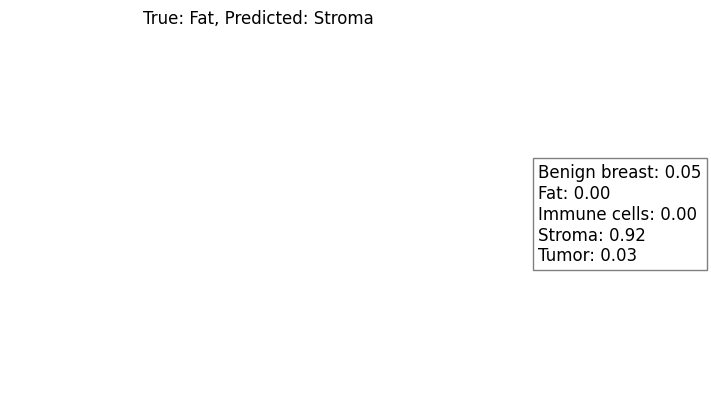

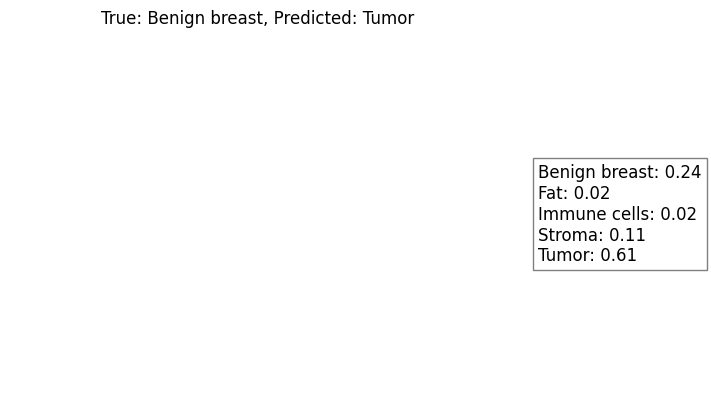

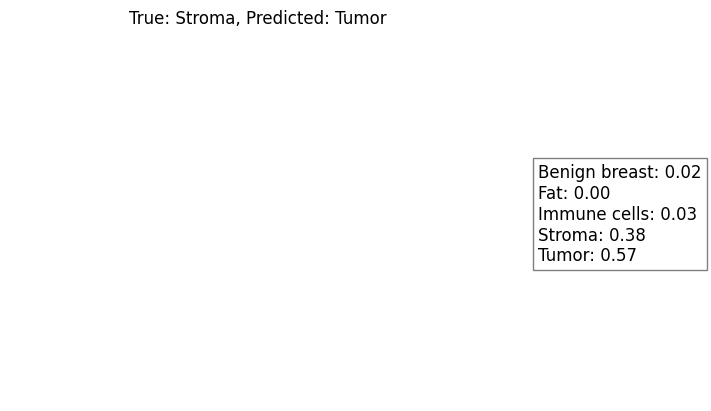

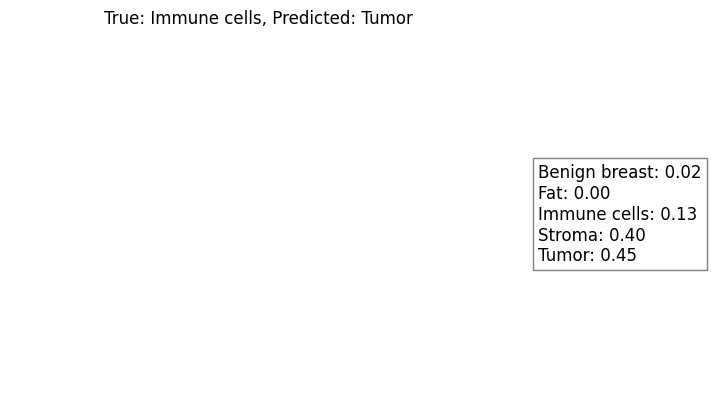

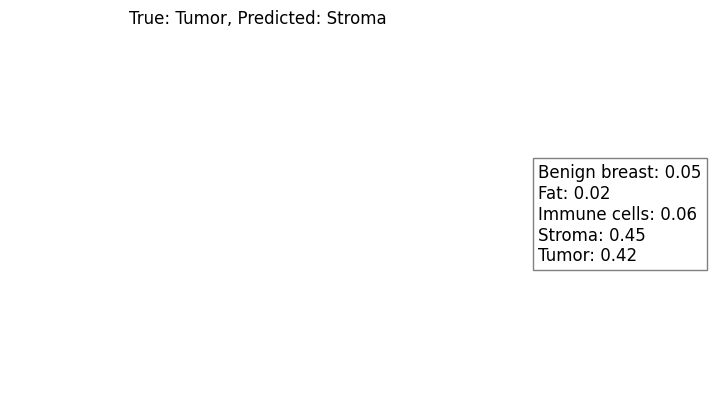

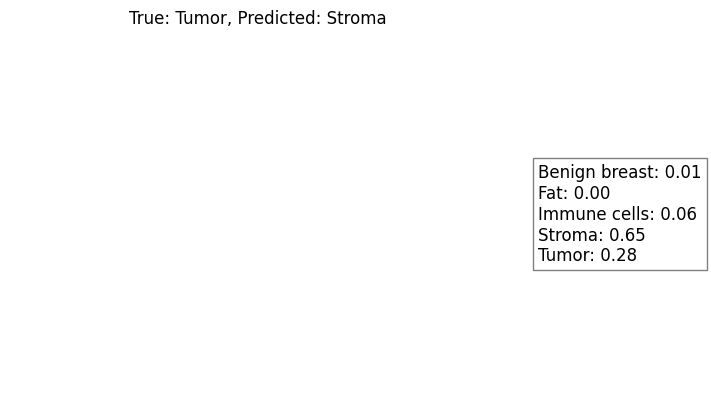

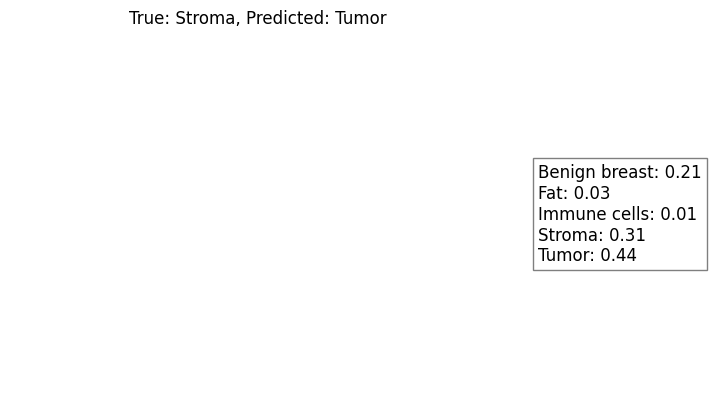

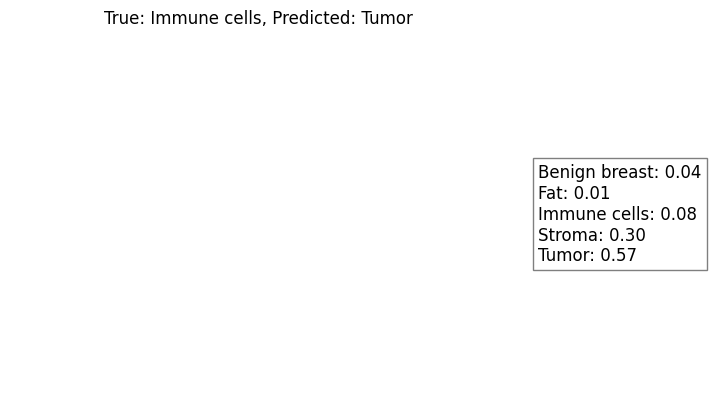

In [14]:
misclassified_indices = np.where(y_test != y_pred)[0]

# Visualize the misclassified images
for index in misclassified_indices:
    true_label = y_test.iloc[index]
    predicted_label = y_pred[index]
    
    plt.figure()
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.axis('off')

    #Get probabilities
    probabilities = y_proba[index]  # Probabilities for this sample
    # Display probabilities
    prob_text = "\n".join([f"{label}: {prob:.2f}" for label, prob in zip(model.classes_, probabilities)])
    plt.gcf().text(0.95, 0.5, prob_text, fontsize=12, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5))
    
    plt.show()

In [15]:
##Perform a machine learning algorithm on the expression dataset (PCA version)

labels = adata.obs["annotation"]  # Extraction of pathologist's annotation

# Extract segmentation features and annotation
X = adata.obsm['X_pca']
y = labels

# Split data in a train dataset and a test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the classification model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test dataset
y_pred = model.predict(X_test)

# Display the classification report
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

Benign breast       1.00      0.25      0.40        97
          Fat       0.50      0.04      0.07        25
 Immune cells       0.67      0.05      0.09        41
       Stroma       0.87      0.94      0.90      1173
        Tumor       0.89      0.92      0.91       868

     accuracy                           0.88      2204
    macro avg       0.78      0.44      0.47      2204
 weighted avg       0.87      0.88      0.86      2204



In [16]:
print(adata.X[4567:4577, :20])

  (1, 2)	0.22969481480143156
  (1, 18)	0.22969481480143156
  (3, 14)	0.736737616634807
  (4, 5)	0.5456944494168146
  (4, 10)	0.2166710368085923
  (4, 11)	0.2166710368085923
  (4, 15)	0.2166710368085923
  (5, 2)	0.24240816289713527
  (5, 4)	0.24240816289713527
  (5, 5)	0.24240816289713527
  (5, 6)	0.24240816289713527
  (5, 18)	0.24240816289713527
  (7, 2)	0.8281423450974501
  (8, 1)	0.09102199728647697
  (8, 7)	0.17444578830447804
  (8, 14)	0.09102199728647697
  (8, 18)	0.09102199728647697
  (9, 6)	0.6312717768418578


Feature 1 importance: 0.27258881869535345
Feature 0 importance: 0.1418219591971113
Feature 6 importance: 0.13192398844228773
Feature 8 importance: 0.08437438146179316
Feature 5 importance: 0.07214750442470368
Feature 3 importance: 0.06861527620492107
Feature 2 importance: 0.060698758586892665
Feature 4 importance: 0.05863271169378543
Feature 7 importance: 0.05639928969239033
Feature 9 importance: 0.052797311600761065


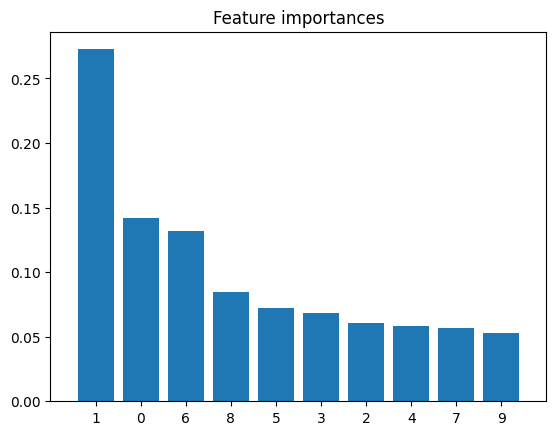

In [17]:
# Observe the most important features of the model

importances = model.feature_importances_

# Display the 10 most important features
indices = np.argsort(importances)[::-1]
for i in range(10):
    print(f"Feature {indices[i]} importance: {importances[indices[i]]}")

import matplotlib.pyplot as plt
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), indices[:10])
plt.xlim([-1, 10])
plt.show()

In [18]:
liste=[]
for i in range(10):
    liste.append(adata.var_names[indices[i]])

In [19]:
liste

['ENSG00000162572',
 'ENSG00000131591',
 'ENSG00000048707',
 'ENSG00000011009',
 'ENSG00000162585',
 'ENSG00000215915',
 'ENSG00000221978',
 'ENSG00000197530',
 'ENSG00000162552',
 'ENSG00000117614']